In [497]:
#!/usr/bin/python

import simulate_visibilities.Bulm as Bulm
import simulate_visibilities.simulate_visibilities as sv
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import time, ephem, sys, os, resource, datetime, warnings
import aipy as ap
import os
#os.environ['QT_QPA_PLATFORM']='offscreen'
import sys
import matplotlib.pyplot as plt
import healpy as hp
import healpy.rotator as hpr
import healpy.pixelfunc as hpf
import healpy.visufunc as hpv
import scipy.interpolate as si
import glob
import astropy
from astropy.io import fits

from pyuvdata import UVData, UVCal, UVFITS
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
import linsolve
from hera_cal.datacontainer import DataContainer
from astropy.time import Time
import omnical
import omnical.calibration_omni as omni
from memory_profiler import memory_usage as memuse
from collections import OrderedDict as odict
import pandas
import aipy.miriad as apm
import re
import copy


PI = np.pi
TPI = PI * 2


def pixelize(sky, nside_distribution, nside_standard, nside_start, thresh, final_index, thetas, phis, sizes):
	# thetas = []
	# phis = []
	for inest in range(12 * nside_start ** 2):
		pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis,
						sizes)
		# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis)
		# thetas += newt.tolist()
		# phis += newp.tolist()
		# return np.array(thetas), np.array(phis)


def pixelize_helper(sky, nside_distribution, nside_standard, nside, inest, thresh, final_index, thetas, phis, sizes):
	# print "visiting ", nside, inest
	starti, endi = inest * nside_standard ** 2 / nside ** 2, (inest + 1) * nside_standard ** 2 / nside ** 2
	##local mean###if nside == nside_standard or np.std(sky[starti:endi])/np.mean(sky[starti:endi]) < thresh:
	if nside == nside_standard or np.std(sky[starti:endi]) < thresh:
		nside_distribution[starti:endi] = nside
		final_index[starti:endi] = len(thetas)  # range(len(thetas), len(thetas) + endi -starti)
		# return hp.pix2ang(nside, [inest], nest=True)
		newt, newp = hp.pix2ang(nside, [inest], nest=True)
		thetas += newt.tolist()
		phis += newp.tolist()
		sizes += (np.ones_like(newt) * nside_standard ** 2 / nside ** 2).tolist()
		# sizes += (np.ones_like(newt) / nside**2).tolist()

	else:
		# thetas = []
		# phis = []
		for jnest in range(inest * 4, (inest + 1) * 4):
			pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh, final_index, thetas,
							phis, sizes)
			# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh)
			# thetas += newt.tolist()
			# phis += newp.tolist()
			# return np.array(thetas), np.array(phis)


def dot(A, B, C, nchunk=10):
	if A.ndim != 2 or B.ndim != 2 or C.ndim != 2:
		raise ValueError("A B C not all have 2 dims: %i %i %i" % (str(A.ndim), str(B.ndim), str(C.ndim)))

	chunk = len(C) / nchunk
	for i in range(nchunk):
		C[i * chunk:(i + 1) * chunk] = A[i * chunk:(i + 1) * chunk].dot(B)
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = A[chunk * nchunk:].dot(B)


def ATNIA(A, Ni, C, nchunk=20):  # C=AtNiA
	if A.ndim != 2 or C.ndim != 2 or Ni.ndim != 1:
		raise ValueError("A, AtNiA and Ni not all have correct dims: %i %i %i"%(A.ndim, C.ndim, Ni.ndim))

	expected_time = 1.3e-11 * (A.shape[0]) * (A.shape[1])**2
	print "Estimated time for A %i by %i"%(A.shape[0], A.shape[1]), expected_time, "minutes",
	sys.stdout.flush()

	chunk = len(C) / nchunk
	for i in range(nchunk):
		ltm = time.time()
		C[i * chunk:(i + 1) * chunk] = np.einsum('ji,jk->ik', A[:, i * chunk:(i + 1) * chunk] * Ni[:, None], A)
		if expected_time >= 1.:
			print "%i/%i: %.1fmins"%(i, nchunk, (time.time() - ltm)/60.),
			sys.stdout.flush()
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = np.einsum('ji,jk->ik', A[:, chunk * nchunk:] * Ni[:, None], A)


def solve_phase_degen(data_xx, data_yy, model_xx, model_yy, ubls, plot=False):#data should be time by ubl at single freq. data * phasegensolution = model
	if data_xx.shape != data_yy.shape or data_xx.shape != model_xx.shape or data_xx.shape != model_yy.shape or data_xx.shape[1] != ubls.shape[0]:
		raise ValueError("Shapes mismatch: %s %s %s %s, ubl shape %s"%(data_xx.shape, data_yy.shape, model_xx.shape, model_yy.shape, ubls.shape))
	A = np.zeros((len(ubls) * 2, 2))
	b = np.zeros(len(ubls) * 2)

	nrow = 0
	for p, (data, model) in enumerate(zip([data_xx, data_yy], [model_xx, model_yy])):
		for u, ubl in enumerate(ubls):
			amp_mask = (np.abs(data[:, u]) > (np.median(np.abs(data[:, u])) / 2.))
			A[nrow] = ubl[:2]
			b[nrow] = omni.medianAngle(np.angle(model[:, u] / data[:, u])[amp_mask])
			nrow += 1
	phase_cal = omni.solve_slope(np.array(A), np.array(b), 1)
	if plot:
		plt.hist((np.array(A).dot(phase_cal)-b + PI)%TPI-PI)
		plt.title('phase fitting error')
		plt.show()

	#sooolve
	return phase_cal

class LastUpdatedOrderedDict(odict):
	'Store items in the order the keys were last added'

	def __setitem__(self, key, value):
		if key in self:
			del self[key]
		odict.__setitem__(self, key, value)

def S_casa_v_t(v, t = 2015.5):		
	S_0 = 2190.294 #S_casA_1GHz
	alpha =  0.725
	belta = 0.0148
	tau = 6.162*1.e-5

	a = -0.00633 #+-0.00024 year-1 
	b = 0.00039 #+-0.00008 year -1
	c = 1.509*1.e-7 #+-0.162*1.e-7 year-1
	
	v *= 1.e-3
	
	#print(v) # from MHz to GHz
	#print(t) # in decimal year
	
	S_casa_v = S_0 * v**(-alpha + belta * np.log(v)) * np.exp(-tau * v**(-2.1)) #S_0: 2015.5
	d_speed_log_v = a + b * np.log(v) + c * v**(-2.1) #a,b,c: 2005.0
	S_casa_v_t = np.exp((t - 2015.5) * d_speed_log_v + np.log(S_casa_v))
	
	#print(d_speed_log_v)
	
	return S_casa_v_t
	
def S_cyga_v(v, t = 2005):
	S_cyga_v = 3.835 * 1.e5 * v**(-0.718) * np.exp(-0.342 * (21.713/v)**2.1)
	
	return S_cyga_v



INSTRUMENT = ''

In [498]:
#####commandline inputs#####
if len(sys.argv) == 1:
	INSTRUMENT = 'hera47'
else:
	INSTRUMENT = sys.argv[1]#'miteor'#'mwa'#'hera-47''paper'

INSTRUMENT = 'hera47' #'hera47'; 'miteor'
print INSTRUMENT

tag = '-ampcal-' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.

AtNiA_only = False
if len(sys.argv) > 3 and sys.argv[3][:5] == 'atnia':
	AtNiA_only = True
	pixel_scheme_number = int(sys.argv[3][5:])
	
simulation_opt = 1

plotcoord = 'CG'
baseline_safety_factor = 10.#max_ubl = 1.4*lambda/baseline_safety_factor
crosstalk_type = 'autocorr'
#pixel_directory = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'

plot_pixelization = True and not AtNiA_only
plot_projection = True and not AtNiA_only
plot_data_error = True and not AtNiA_only

force_recompute = False
force_recompute_AtNiAi_eig = False
force_recompute_AtNiAi = False
force_recompute_S = False
force_recompute_SEi = False

C = 299.792458
kB = 1.3806488 * 1.e-23

try:
	__file__
except NameError:
	#script_dir = '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/simulate_visibilities/scripts'
	script_dir = os.path.join(DATA_PATH, '../../../HERA_MapMaking_VisibilitySimulation/scripts')
	pixel_directory = script_dir
	print 'Run IPython'
else:
	script_dir = os.path.dirname(os.path.realpath(__file__))
	pixel_directory = script_dir
	print 'Run Python'


hera47
Run IPython


In [499]:
len(sys.argv)
DATA_PATH

'/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data'

In [500]:
model_fname = {}
model = {}
mflags = {}
mantpos = {}
mants = {}
model_freqs = {}
model_times = {}
model_lsts = {}
model_pols = {}
model_fname = {}
# model = mflags = mantpos = mant = model_freqs = model_times = model_lsts = model_pols = {}
for i in range(2):
    model_fname[i] = os.path.join(DATA_PATH, "zen.2458042.12552.%s.HH.uvXA"%['xx','yy'][i]) #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
    #model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
    if i == 1:
        try:
            #data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
            if not os.path.isfile(model_fname[i]):
                model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA")
        except:
            pass
    (model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
     model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)

In [501]:
print(mflags[0].keys())
print(np.abs(model[0][mflags[0].keys()[0]][:,32]).shape)
print(np.abs(model[0][mflags[0].keys()[0]][:,32]).mean())
print(np.abs(model[0][mflags[0].keys()[0]][:,32]).max())
print(np.abs(model[0][mflags[0].keys()[0]][:,32]).min())
print(np.abs(model[0][mflags[0].keys()[0]][:,32]).sum())

[(24, 37, 'xx'), (37, 53, 'xx'), (52, 53, 'xx'), (24, 38, 'xx'), (37, 39, 'xx'), (25, 39, 'xx'), (38, 52, 'xx'), (37, 52, 'xx'), (25, 53, 'xx'), (24, 52, 'xx'), (39, 53, 'xx'), (24, 39, 'xx'), (37, 38, 'xx'), (25, 38, 'xx'), (38, 53, 'xx'), (25, 52, 'xx'), (24, 53, 'xx'), (39, 52, 'xx'), (38, 39, 'xx'), (25, 37, 'xx'), (24, 25, 'xx')]
(60,)
3038.447
3741.948
2336.8945
182306.83


In [502]:
####################################################
################data file and load beam##############
####################################################
if INSTRUMENT == 'miteor':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = False
	
	sys.stdout.flush()
	S_type = 'dyS_lowadduniform_lowI' #'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # Determine the resolution of GSM of sky

	pre_calibrate = True
	pre_ampcal = ('qC' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = False
	nside_beamweight = 16 # Determin shape of A matrix
	
	Integration_Time = 144 # seconds
	Frequency_Bin = 0.75*1.e6 # Hz
	
	lat_degree = 45.2977
	lst_offset = 5.#lsts will be wrapped around [lst_offset, 24+lst_offset]
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2016_01_20_avg'#'_seccasa.rad'#
		vartag = '_2016_01_20_avgx100'#''#
	else:
		datatag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollockx100'#''#
#	datadir = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'
	datadir = script_dir + '/../Output/'
	antpairs = None
	# deal with beam: create a callable function of the form y(freq) in MHz and returns 2 by npix
	
	
	############################################ Load Beam and Visibility Data ###########################################
	vis_freq_list = flist = np.array([126.83333,127.6667,128.5000,129.3333,130.1667,131.0000,131.8333,132.6667,133.5000,134.3333,135.1667,136.0000,136.8333,137.6667,139.3333,140.0000,141.83333,142.6667,143.5000,144.3333,145.0000,145.1667,146.0000,146.6667,147.5000,148.3333,150.8333,151.6667,152.5000,153.3333,154.1667,155.0000,155.8333,156.0000,156.6667,156.8333,159.3333,161.8333,164.3333,166.8333,167.8333,170.3333,172.8333])
	freq = vis_freq_selected = 150.8333 #MHz
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	
	bnside = 64 #Depend on beam pattern data
	freqs = range(110, 200, 10)
	local_beam_unpol = si.interp1d(freqs, np.array([la.norm(np.loadtxt(
		script_dir + '/../data/MITEoR/beam/%s.txt'%(p), skiprows=0).reshape(
		(len(freqs), 12 * bnside ** 2, 4)), axis=-1)**2 for p in ['x', 'y']]).transpose(1, 0, 2), axis=0)
	Plot_Beam = True
	if Plot_Beam:
		plt.figure(0)
		#ind = np.where(beam_freqs == freq)[0][0]
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		plt.show(block=False)
		#plt.gcf().clear()
			#plt.clf()
			#plt.close()
			
	time_vis_data = np.array([np.loadtxt(script_dir + '/../data/MITEoR/visibilities/%sMHz_%s%s_A.txt'%(vis_freq_selected,p,p)) for p in ['x','y']])
	
	vis_data = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex128')
	var_data = time_vis_data[:,1:,3::3]
	
	tlist = time_vis_data[0,1:,0]
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	nt = nt_used = len(tlist)
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	nUBL = int(len(time_vis_data[0,0,:])/3)
	
	ubls = {}
	for p in range(2):
		ubls[['x','y'][p]] = time_vis_data[p,0,1:].reshape((nUBL,3))		
	common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()	
	
	
elif INSTRUMENT == 'hera47':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = True
	From_File_Data = True
	Keep_Red = False
	Absolute_Calibration = False
	Absolute_Calibration_red = False
	Absolute_Calibration_mfreq = False
	Absolute_Calibration_dred = False
	Absolute_Calibration_dred_mfreq = True
	PointSource_AbsCal = True
	
	Use_AbsCal = True # Use Model calculated noise which is just fullsim autocorr calculated noise.
	Use_PsAbsCal = True # higher priority over Use_AbsCal and Use_Fullsim_Noise. if comply_ps2mod_autocorr then become just fullsim autocorr calculated noise.
	comply_ps2mod_autocorr = False
	Use_Fullsim_Noise = False # Use fullsim autocorr calculated noise.
	
	Replace_Data = True
	
	pre_calibrate = True
	tag = '-ampcal-' if pre_calibrate else '' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.
	pre_ampcal = ('ampcal' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = True
	
	Erase = True
	
	Add_S_diag = False
	Add_Rcond = True
	
	sys.stdout.flush()
	
	lat_degree = -30.72153 #lon='21:25:41.9' lat='-30:43:17.5'
	lst_offset = 1.43#lsts will be wrapped around [lst_offset, 24+lst_offset]

	Integration_Time = 11 # seconds
	Frequency_Bin = 1.625*1.e6 # Hz

	S_type = 'dyS_lowadduniform_max8I' if Add_S_diag else 'no_use' #'dyS_lowadduniform_minI', 'dyS_lowadduniform_I', 'dyS_lowadduniform_lowI', 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data
	rcond_list = 10.**np.arange(-15., -0., 1.)
    
	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # resolution of sky
	nside_beamweight = 16 # A matrix shape
	bnside = 64 # beam pattern data resolution
	
	
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2018_'#'_seccasa.rad'#
		vartag = '_2018_'#''#
	else:
		datatag = '_2018_ampcaled_'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2018_ampcaled_'#'_2016_01_20_avg_unpollockx100'#''#
	datadir = script_dir + '/../Output/'
	antpairs = None
	
	#######################################################################################################
	##################################### Load Visibility Data ###########################################
	# specify model file and load into UVData, load into dictionary
	Small_ModelData = True
	Model_Calibration = False
	
	model_fname = {}
	model = {}
	mflags = {}
	mantpos = {}
	mants = {}
	model_freqs = {}
	model_times = {}
	model_lsts = {}
	model_pols = {}
	data_fname = {}
	data_fname_full = {}
	dflags = {}
	data = {}
	antpos = {}
	ants = {}
	data_freqs = {}
	data_times = {}
	data_lsts = {}
	data_pols = {}
	
	fulldflags = {}
	
	if Small_ModelData:
		if Model_Calibration:
			model_fname = {}
			model = mflags = mantpos = mant = model_freqs = model_times = model_lsts = model_pols = {}
			for i in range(2):
				model_fname[i] = os.path.join(DATA_PATH, "zen.2458042.12552.%s.HH.uvXA"%['xx','yy'][i]) #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				#model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
				if i == 1:
					try:
						#data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
						if not os.path.isfile(model_fname[i]):
							model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA")
					except:
						pass
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
				 model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
			
#			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, "zen.2458043.12552.%s.HH.uvORA"%['xx', 'yy'][i]) #zen.2457698.40355.xx.HH.uvcA
			if i == 1:
				try:
					#data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
					if not os.path.isfile(data_fname[i]):
						data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
				except:
					pass
			data_fname_full[i] = os.path.join(DATA_PATH, 'Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i])
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], 
			 data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
			
#		try:
#			data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
#			if not os.path.isfile(data_fname_yy):
#				data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#		except:
#			pass
#		data_fname_yy_full = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.yy.HH.uvOR"
#		(data_yy, dflags[1], antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
#		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
	else:
		if Model_Calibration:
#			model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
#			model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
#			model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
#			model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
#			(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
#			 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
#			(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
#			 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
			
			model_fname_dred = {}
			model_dred = mflags_dred = mantpos_dred = mant_dred = model_freqs_dred = model_times_dred = model_lsts_dred = model_pols_dred = {}
			for i in range(2):
				#model_fname[i] = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.12552.%s.HH.uv"%['xx','yy'][i]#/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				model_fname[i] = os.path.join(DATA_PATH, 'Observation-1192115507/2458042/zen.2458042.12552.%s.HH.uv'%['xx','yy'][i])
				#model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
#				(model_dred[i], mflags_dred[i], mantpos_dred[i], mants_dred[i], model_freqs_dred[i], model_times_dred[i], model_lsts_dred[i],
#				 model_pols_dred[i]) = hc.abscal.UVData2AbsCalDict(model_fname_dred[i], return_meta=True)
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
				 model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
			
#			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, 'Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i])
			#data_fname[i] = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i]
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], 
			 data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
		
#		data_fname_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.yy.HH.uvOR'
#		(data_yy, dflags_yy, antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
#		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
#	model, interp_flags = hc.abscal.interp2d_vis(model, model_lsts, model_freqs, data_lsts, data_freqs) #interpolate model onto time & freq axes of data
#	# instantiate class
#	AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs) #Instantiate AbsCal object
	
	################# Select Frequency ####################
	flist = {}
	index_freq = {}
	antloc = {}
	dflags_sf = {} #single frequency
	for i in range(2):
		flist[i] = np.array(data_freqs[i])/10**6
		try:
			index_freq[i] = np.where(flist[i]==150)[0][0]
	#		index_freq = 512
		except:
			index_freq[i] = len(flist[i])/2
	
	for i in range(2):
		dflags_sf[i] = LastUpdatedOrderedDict()
		for key in dflags[i].keys():
			dflags_sf[i][key] = dflags[i][key][:,index_freq[i]]
	
	# ant locations
	for i in range(2): 
		antloc[i] = np.array(map(lambda k: antpos[i][k], ants[i]))
#	antloc_yy = np.array(map(lambda k: antpos_yy[k], ants_yy))
	
	# plot sub-array HERA layout
	for j in range(2):
		plt.figure(100000+5*j, figsize=(6,6))
		plt.grid()
		plt.scatter(antloc[j][:, 0], antloc[j][:, 1], s=3000)
		_ = [plt.text(antloc[j][i, 0]-1, antloc[j][i, 1], str(ants[j][i]), fontsize=14, color='w') for i in range(len(antloc[j]))]
		plt.title('%s-polarization selected subarray'%['xx', 'yy'][j])
		plt.xlim(-30, 30)
		plt.ylim(-30, 30)
		plt.show(block=False)
		#plt.cla()

	############################## Autocorrelation #################################
	xxfile = data_fname[0] if not Small_ModelData else data_fname_full[0]
	yyfile = data_fname[1] if not Small_ModelData else data_fname_full[1]
	
	# Load data for autocorrelation calculating
	uvd_xx = UVData()
	uvd_xx.read_miriad(xxfile)
	uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))
	uvd_yy = UVData()
	uvd_yy.read_miriad(yyfile)
	uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))

	# Get metadata
	freqs = uvd_xx.freq_array.squeeze() / 1e6
	times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
	jd_start = np.floor(times.min())
	Nfreqs = len(freqs)
	Ntimes = len(times)

	# get redundant info
	aa = hc.utils.get_aa_from_uv(uvd_xx)
	info = hc.omni.aa_to_info(aa)
	red_bls = np.array(info.get_reds())
	ants = sorted(np.unique(np.concatenate(red_bls)))
	Nants = len(ants)
	Nside = int(np.ceil(np.sqrt(Nants)))
	Yside = int(np.ceil(float(Nants)/Nside))
	
	try:
		plot_data_autocorr = False
		if plot_data_autocorr: # at specific frequency
			### plot autos
			t_index = 0
			jd = times[t_index]
			utc = Time(jd, format='jd').datetime

			xlim = (-50, Nfreqs+50)
			ylim = (-10,30)

			fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
			fig.subplots_adjust(wspace=0.2, hspace=0.2)
			fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
			fig.tight_layout(rect=(0, 0, 1, 0.95))

			k = 0
			for i in range(Yside):
				for j in range(Nside):
					ax = axes[i,j]
					ax.set_xlim(xlim)
					ax.set_ylim(ylim)
					if k < Nants:
						px, = ax.plot(10*np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])), color='steelblue', alpha=0.75, linewidth=3)
						py, = ax.plot(10*np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])), color='darkorange', alpha=0.75, linewidth=3)
						ax.grid(True, which='both')
						ax.set_title(str(ants[k]), fontsize=14)
						if k == 0:
							ax.legend([px, py], ['East', 'North'], fontsize=12)
					else:
						ax.axis('off')
					if j != 0:
						ax.set_yticklabels([])
					else:
						[t.set_fontsize(12) for t in ax.get_yticklabels()]
						ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
					if i != Yside-1:
						ax.set_xticklabels([])
					else:
						[t.set_fontsize(12) for t in ax.get_xticklabels()]
						ax.set_xlabel('freq channel', fontsize=14)

					k += 1
			plt.show(block=False)
		
	except:
		pass
		
	autocorr_data_mfreq = {} #np.zeros((2, Ntimes, Nfreqs))
	autocorr_data_mfreq[0] = np.mean(np.array([np.abs(uvd_xx.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
	autocorr_data_mfreq[1] = np.mean(np.array([np.abs(uvd_yy.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
	autocorr_data =  {}
	for i in range(2):
		autocorr_data[i] = autocorr_data_mfreq[i][:,index_freq[i]]
		
	if Replace_Data:	
		findex = np.where(freqs==150)
		findex_list = {}
		autocorr_data_mfreq_ff = {}
		for i in range(2):
			findex_list[i] = np.array([np.where(freqs==flist[i][j])[0][0] for j in range(len(flist[i]))])
			
		data_ff = {}
		dflags_ff = {}
		for i in range(2):
			data_ff[i] = LastUpdatedOrderedDict()
			dflags_ff[i] = LastUpdatedOrderedDict()
			for id_key, key in enumerate(dflags[i].keys()):
				#key[2] = 'xx' if i == 0 else 'yy'
				data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = uvd_xx.get_data((key[0], key[1]))[:,findex_list[i]] if i == 0 else uvd_yy.get_data((key[0], key[1]))[:,findex_list[i]]
				autocorr_data_mfreq_ff[i] = autocorr_data_mfreq[i][:, findex_list[i]]
				dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = dflags[i][key]
						#del data_ff[dflags[i].keys()[id_key]]
		
		data = copy.deepcopy(data_ff)
		dflags = copy.deepcopy(dflags_ff)
		autocorr_data_mfreq = copy.deepcopy(autocorr_data_mfreq_ff)	
		
		del(data_ff)
		del(dflags_ff)
		del(autocorr_data_mfreq_ff)
	#del(autocorr_data_mfreq)
		
	del(uvd_xx)
	del(uvd_yy)
	del(aa)
	del(info)
	
	
	
#	plt.figure(100005, figsize=(6,6))
#	plt.grid()
#	plt.scatter(antloc_yy[:, 0], antloc_yy[:, 1], s=3000)
#	_ = [plt.text(antloc_yy[i, 0]-1, antloc_yy[i, 1], str(ants_yy[i]), fontsize=14, color='w') for i in range(len(antloc_yy))]
#	plt.title('yy polarization selected subarray')
#	plt.xlim(-30, 30)
#	plt.ylim(-30, 30)
#	plt.show(block=False)
	
	
	#bls = odict([(x, antpos[x[0]] - antpos[x[1]]) for x in model.keys()])
	bls = [[],[]]
	for i in range(2):
		bls[i] = odict([(x, antpos[i][x[0]] - antpos[i][x[1]]) for x in data[i].keys()])
		#bls[1] = odict([(y, antpos_yy[y[0]] - antpos_yy[y[1]]) for y in data_yy.keys()])
		bls = np.array(bls)
	
	bsl_coord = [[],[]]
	bsl_coord_x = bsl_coord[0] = np.array([bls[0][index] for index in bls[0].keys()])
	bsl_coord_y = bsl_coord[1] = np.array([bls[1][index] for index in bls[1].keys()])
	#bsl_coord_x=bsl_coord_y=bsl_coord
	bsl_coord = np.array(bsl_coord)
	
	
	########################### Visibility ##############################
	vis_data_mfreq = {}
	#vis_data_Omni_mfreq = np.array([data_omni[bslkeys] for bslkeys in data_omni.keys()], dtype='complex128').transpose((2,1,0)) if Model_Calibration else None
	for i in range(2):
		vis_data_mfreq[i] = np.array([data[i][bslkeys] for bslkeys in data[i].keys()], dtype='complex128').transpose((2,1,0))
#	vis_data_mfreq = np.array([data_yy[bslkeys] for bslkeys in data_yy.keys()], dtype='complex128').transpose((2,1,0))
	
#	vis_data_mfreq = np.zeros((2,vis_data_xx_mfreq.shape[0], vis_data_xx_mfreq.shape[1], vis_data_xx_mfreq.shape[2]), dtype='complex128')
#	vis_data_mfreq[0] = vis_data_xx_mfreq
#	vis_data_mfreq[1] = vis_data_yy_mfreq

	vis_freq_selected = freq = flist[0][index_freq[0]] #MHz For Omni:  0:100, 16:125, 32:150, 48:175;;; For Model:  512:150MHz   Choose xx as reference
	#vis_data = np.zeros((2,vis_data_mfreq.shape[2], vis_data_xx_mfreq.shape[3]), dtype='complex128')
	vis_data = {}
	for i in range(2):
		vis_data[i] = vis_data_mfreq[i][index_freq[i], :, :] # [pol][ freq, time, bl] 

	#del(vis_data_mfreq)
		

	################################## Unique Base Lines and Remove Redundancy ########################################
	
#	np.array(omnical.arrayinfo.compute_reds(antloc)) # Alternate way to compute.
	Ubl_list_raw = [[],[]]
	Ubl_list = [[],[]]
	ant_pos = [[],[]]
	
	Nubl_raw = np.zeros(2, dtype=int)
	times_raw = np.zeros(2, dtype=int)
	times_raw_list = [[],[]]
	redundancy = [[],[]]
	bsl_coord_dred = [[],[]]
	vis_data_dred = [[],[]]
	vis_data_dred_mfreq = [[],[]]
	
	for i in range(2):
		Ubl_list_raw[i] = np.array(omnical.arrayinfo.compute_reds_total(antloc[i])) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
	#Ubl_list_raw[1] = np.array(omnical.arrayinfo.compute_reds_total(antloc_yy)) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
		ant_pos[i] = antpos[i]
	#ant_pos[1] = antpos_yy
	for i in range(2):
		for i_ubl in range(len(Ubl_list_raw[i])):
			list_bsl = []
			for i_ubl_pair in range(len(Ubl_list_raw[0][i_ubl])):
				try:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][i])))
				except:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][1-i])))
			Ubl_list[i].append(list_bsl)
	
	for i in range(2):		
		Nubl_raw[i] = len(Ubl_list[i])
		times_raw[i] = len(data_times[i])
		times_raw_list[i] = data_times[i]
		bsl_coord_dred[i] = np.zeros((Nubl_raw[i], 3))
		vis_data_dred[i] = np.zeros((times_raw[i], Nubl_raw[i]), dtype='complex128')
		vis_data_dred_mfreq[i] = np.zeros((len(flist[i]), times_raw[i], Nubl_raw[i]), dtype='complex128')
	
	try:
		var_data_dred = [[],[]]
		var_data_dred[0] = np.zeros((times_raw[0], Nubl_raw[0]), dtype='complex128')
		var_data_dred[1] = np.zeros((times_raw[1], Nubl_raw[1]), dtype='complex128')
	except:
		pass
		
	
	########################### Average on Redundant baselines #############################
	#data_dred = {}
	dflags_dred = {}
		
	for i in range(2):
		#data_dred[i] = {}
		#dflags_dred[i] = {}
		dflags_dred[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred[i][:, i_ubl] = np.mean(vis_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			#if Absolute_Calibration_dred:
			dflags_dred[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags_sf[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]]
#				if i == 0:
#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
#				else:
#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			except:
				pass
				
				
	#vis_data_dred_mfreq = [[],[]]
	dflags_dred_mfreq = {}
		
	for i in range(2):
		#data_dred_mfreq[i] = {}
		#dflags_dred_mfreq[i] = {}
		dflags_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred_mfreq[i][:, :, i_ubl] = np.mean(vis_data_mfreq[i][ :, :, Ubl_list[i][i_ubl]], axis=-1)
			#bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			#if Absolute_Calibration_dred_mfreq:
			dflags_dred_mfreq[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]]
#				if i == 0:
#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
#				else:
#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			#redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i][ :, :, Ubl_list[i][i_ubl]], axis=-1)
			except:
				pass
		

	#wgts_dred = copy.deepcopy(dflags_dred)
		
	
	Del = True
	if Del and not Small_ModelData:
		try:
			#del(red_bls)
			#del(autocorr_data_mfreq)
			#del(vis_data_mfreq)
			del(var_data_mfreq)
				
		except:
			pass
			
		try:
			if not Keep_Red:
				del(bsl_coord)
		except:
			pass
	
	sys.stdout.flush()
	
	
	############################### t and f ##########################
	# Using one of the two polarization, which should basically be same from choosing files
	tlist_JD = np.array(data_times[0])
	JD2SI_time = Time(data_times[0], format='jd').datetime
	tlist = np.zeros(len(data_times[0]))
	nt = len(tlist)
	nf = len(flist[0])
	for i in range(len(data_times[0])):
		tlist[i] = si_t = (JD2SI_time[i].hour*3600. + JD2SI_time[i].minute*60. + JD2SI_time[i].second)/3600.
	#	tlist[i] = '%.2f' %si_t
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	lsts = data_lsts[0][tmask]
	nt_used = len(tlist)
	nf_used = len(flist[0])
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	jansky2kelvin_mfreq = {}
	for j in range(2):
		jansky2kelvin_mfreq[j] = np.array([1.e-26 * (C / flist[j][i]) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2)) for i in range(len(flist[j]))])
	
	############################## Common UBL ###########################
	ubls = {}
	bls_red = {}
	#freq = 150
#	nside_standard = 32
	baseline_safety_factor = 3.
	
	nBL_red = len(bsl_coord_x)
	for p in ['x', 'y']:
		#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
		bls_red[p] = globals()['bsl_coord_' + p]
	common_bls_red = np.array([u for u in bls_red['x'] if (u in bls_red['y'] or -u in bls_red['y'])])
	
	used_common_bls_red = common_bls_red[la.norm(common_bls_red, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nBL_red_used = len(used_common_bls_red)
	
	if Keep_Red:
		nUBL = len(bsl_coord_x)
		for p in ['x', 'y']:
			#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
			ubls[p] = globals()['bsl_coord_' + p]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	else:
		nUBL = len(bsl_coord_dred[0])
		nUBL_yy = len(bsl_coord_dred[1])
		for i in range(2):
			p = ['x', 'y'][i]
			ubls[p] = bsl_coord_dred[i]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	#common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()
	
	######################### Beam Pattern #############################
	
	filename = script_dir + '/../data/HERA-47/Beam-Dipole/healpix_beam.fits'
	beam_E = fits.getdata(filename, extname='BEAM_E').T #E is east corresponding to X polarization
	beam_nside = hp.npix2nside(beam_E.shape[1])
	beam_freqs = fits.getdata(filename, extname='FREQS')

	print('Frequencies: ')
	print(beam_freqs)
	
	# select only 100-200 MHz data
#	freq_select = np.where((freqs >= 100) & (freqs <=200))[0]
#	beams = beams[:, freq_select]
#	freqs = freqs[freq_select]
#	Nfreqs = len(freqs)

	# take East pol and rotate to get North pol
	Nfreqs = len(beam_freqs)
	beam_theta, beam_phi = hp.pix2ang(64, np.arange(64**2 * 12))
	#R = hp.Rotator(rot=[0,0,-np.pi/2], deg=False)
	R = hp.Rotator(rot=[-np.pi/2,0,0], deg=False)
	beam_theta2, beam_phi2 = R(beam_theta, beam_phi)
	beam_N = np.array(map(lambda x: hp.get_interp_val(x, beam_theta2, beam_phi2), beam_E))
	beam_EN = np.array([beam_E, beam_N])
	beam_EN.resize(2, Nfreqs, 49152)
	
#	# normalize each frequency to max of 1
#	for i in range(beam_EN.shape[-2]):
#		beam_EN[:, i, :] /= beam_EN[:, i, :].max()
	
	local_beam_unpol = si.interp1d(beam_freqs, beam_EN.transpose(1, 0, 2), axis=0)
	

KeyboardInterrupt: 

In [ ]:
print INSTRUMENT
print tag
#tag = 'ampcal'
print Nants
print Small_ModelData
print data_fname
print len(antloc)

In [ ]:
print bsl_coord
print red_bls
print len(red_bls)

In [ ]:

Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()



In [ ]:
print local_beam_unpol(150)[0:]
print local_beam_unpol(150)[0:].sum()
print local_beam_unpol(150)[0:].min()
print local_beam_unpol(150)[0:].max()

In [ ]:
Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()


In [ ]:
#################
####set up vs and beam
################
vs = sv.Visibility_Simulator()
vs.initial_zenith = np.array([0, lat_degree * PI / 180])  # self.zenithequ
beam_heal_hor_x = local_beam_unpol(freq)[0]
beam_heal_hor_y = local_beam_unpol(freq)[1]
beam_heal_equ_x = sv.rotate_healpixmap(beam_heal_hor_x, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])
beam_heal_equ_y = sv.rotate_healpixmap(beam_heal_hor_y, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])

if Absolute_Calibration_dred_mfreq:
	beam_heal_hor_x_mfreq = np.array([local_beam_unpol(flist[0][i])[0] for i in range(nf_used)])
	beam_heal_hor_y_mfreq = np.array([local_beam_unpol(flist[1][i])[1] for i in range(nf_used)])
	beam_heal_equ_x_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_x_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])
	beam_heal_equ_y_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_y_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])


Plot_Beam = True
if Plot_Beam:
	plt.figure(10)
	#ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	plt.show(block=False)

sys.stdout.flush()

In [ ]:
if Plot_Beam:
	plt.figure(0)
# 	ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	plt.show(block=False)

In [ ]:
########################### Delete some Input Data ##############################
Del=True
if Del:
	#del(data)
	#del(data_yy)
	try:
		#del(model)
		#del(model_yy)
		del(data_omni)
	except:
		pass

sys.stdout.flush()

In [ ]:
######################
####initial A to compute beam weight
#####################
A_version = 1.0
A = {}
for p in ['x', 'y']:
	pol = p + p
	# ubl file
	#// ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
	#ubls = np.array([[0,0,0]])
	#//np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
	print "%i UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(ubls[p]), np.max(np.linalg.norm(ubls[p], axis=1)) / (C / freq), pol)
	print "%i Used-Common-UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(used_common_ubls), np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq), pol)

	# beam
	if p == 'x':
		beam_heal_equ = beam_heal_equ_x
	elif p == 'y':
		beam_heal_equ = beam_heal_equ_x
	print "Computing sky weighting A matrix for %s pol..." % p
	sys.stdout.flush()

	A[p] = np.zeros((nt_used * len(used_common_ubls), 12 * nside_beamweight ** 2), dtype='complex128')

	timer = time.time()
	for i in np.arange(12 * nside_beamweight ** 2):
		dec, ra = hpf.pix2ang(nside_beamweight, i)  # gives theta phi
		dec = PI / 2 - dec
		print "\r%.1f%% completed" % (100. * float(i) / (12. * nside_beamweight ** 2)),
		sys.stdout.flush()
		if abs(dec - lat_degree * PI / 180) <= PI / 2:
			A[p][:, i] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts).flatten()

	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()
	

In [ ]:
####################################################
###beam weights using an equal pixel A matrix######
#################################################
print "Computing beam weight...",
sys.stdout.flush()
beam_weight = ((la.norm(A['x'], axis=0) ** 2 + la.norm(A['y'], axis=0) ** 2) ** .5)[hpf.nest2ring(nside_beamweight, range(12 * nside_beamweight ** 2))]
beam_weight = beam_weight / np.mean(beam_weight)
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
beam_weight = hpf.get_interp_val(beam_weight, thetas_standard, phis_standard, nest=True) #np.array([beam_weight for i in range(nside_standard ** 2 / nside_beamweight ** 2)]).transpose().flatten()
print "done."
sys.stdout.flush()

In [ ]:
################################################
#####################GSM###########################
#############################################
pca1 = hp.fitsfunc.read_map(script_dir + '/../data/gsm1.fits' + str(nside_standard))
pca2 = hp.fitsfunc.read_map(script_dir + '/../data/gsm2.fits' + str(nside_standard))
pca3 = hp.fitsfunc.read_map(script_dir + '/../data/gsm3.fits' + str(nside_standard))
components = np.loadtxt(script_dir + '/../data/components.dat')
scale_loglog = si.interp1d(np.log(components[:, 0]), np.log(components[:, 1]))
w1 = si.interp1d(components[:, 0], components[:, 2])
w2 = si.interp1d(components[:, 0], components[:, 3])
w3 = si.interp1d(components[:, 0], components[:, 4])
gsm_standard = np.exp(scale_loglog(np.log(freq))) * (w1(freq) * pca1 + w2(freq) * pca2 + w3(freq) * pca3)
if Absolute_Calibration_dred_mfreq:
	gsm_standard_mfreq = np.array([np.exp(scale_loglog(np.log(flist[0][i]))) * (w1(flist[0][i]) * pca1 + w2(flist[0][i]) * pca2 + w3(flist[0][i]) * pca3) for i in range(nf_used)])

# rotate sky map and converts to nest
equatorial_GSM_standard = np.zeros(12 * nside_standard ** 2, 'float')
print "Rotating GSM_standard and converts to nest...",

if INSTRUMENT == 'miteor':
	DecimalYear = 2013.58 #2013, 7, 31, 16, 47, 59, 999998)
elif INSTRUMENT == 'hera47':
	DecimalYear = np.mean(Time(data_times[0], format='jd').decimalyear)
	JulianEpoch = np.mean(Time(data_times[0], format='jd').jyear)

sys.stdout.flush()
equ_to_gal_matrix = hp.rotator.Rotator(coord='cg').mat.dot(sv.epoch_transmatrix(2000, stdtime=JulianEpoch))
ang0, ang1 = hp.rotator.rotateDirection(equ_to_gal_matrix,
					hpf.pix2ang(nside_standard, range(12 * nside_standard ** 2), nest=True))
equatorial_GSM_standard = hpf.get_interp_val(gsm_standard, ang0, ang1)
if Absolute_Calibration_dred_mfreq:
	equatorial_GSM_standard_mfreq = np.array([hpf.get_interp_val(gsm_standard_mfreq[i], ang0, ang1) for i in range(nf_used)])
print "done."

Del=True
if Del:
	del(pca1)
	del(pca2)
	del(pca3)
	del(w1)
	del(w2)
	del(w3)
	del(components)
	del(scale_loglog)
	del(gsm_standard)
	try:
		del(gsm_standard_mfreq)
	except:
		pass
sys.stdout.flush()

In [ ]:
#print A.shape

In [ ]:
###########################################################
####simulate visibilities using non dynamic pixelization###
##########################################
full_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
if simulation_opt == 1:
	
	if os.path.isfile(full_sim_filename):
		fullsim_vis = np.fromfile(full_sim_filename, dtype='complex128').reshape((2, nUBL_used+1, nt_used))
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	else:

		fullsim_vis = np.zeros((2, nUBL_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis[p] += masked_equ_GSM[i] * res
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
				#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis.astype('complex128').tofile(full_sim_filename)
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	autocorr_vis = np.abs(fullsim_vis[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
	else:
		autocorr_vis_normalized = np.ones((2, nt_used))
	fullsim_vis = fullsim_vis[:, :-1].transpose((1, 0, 2))


In [ ]:
fullsim_vis.shape

In [ ]:
print autocorr_vis.mean()
print(np.abs(fullsim_vis[0,0]).mean())
print(np.abs(fullsim_vis[0,0]).max())
print(np.abs(fullsim_vis[0,0]).min())
print(np.abs(fullsim_vis[0,0]).sum())

In [ ]:
if plot_data_error:
	#plt.clf()
	plt.figure(30)
	plt.plot(autocorr_vis_normalized.transpose())
	plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.ylim([0, 2])
	plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()
	#plt.clf()
	#plt.close()
sys.stdout.flush()


In [ ]:
######################################### Absolute Calibration on Omnicaled Data #############################################
if Absolute_Calibration_red:
	full_redabs_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_redabs.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
	redabs_sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_redabs_sim_xx.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
	redabs_sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_redabs_sim_yy.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
		
	if os.path.isfile(full_redabs_sim_filename):
		fullsim_vis_red = np.fromfile(full_redabs_sim_filename, dtype='complex128').reshape((2, nBL_red_used+1, nt_used))
		fullsim_vis_red[0][:-1,:].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1,:].astype('complex128').tofile(redabs_sim_vis_yy_filename)
		
	else:

		fullsim_vis_red = np.zeros((2, nBL_red_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_bls_red = np.concatenate((used_common_bls_red, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating redundant visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nBL_red_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res_red = vs.calculate_pointsource_visibility(ra, dec, full_sim_bls_red, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis_red[p] += masked_equ_GSM[i] * res_red
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
				#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated redundant visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis_red.astype('complex128').tofile(full_redabs_sim_filename)
		fullsim_vis_red[0][:-1,:].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1,:].astype('complex128').tofile(redabs_sim_vis_yy_filename)
		
	autocorr_vis_red = np.abs(fullsim_vis_red[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_red_normalized = np.array([autocorr_vis_red[p] / (la.norm(autocorr_vis_red[p]) / la.norm(np.ones_like(autocorr_vis_red[p]))) for p in range(2)])
	else:
		autocorr_vis_red_normalized = np.ones((2, nt_used))
	fullsim_vis_red = fullsim_vis_red[:, :-1].transpose((1, 0, 2)) 

	if plot_data_error:
		#plt.clf()
		plt.figure(3000000)
		plt.plot(autocorr_vis_red_normalized.transpose())
		plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.ylim([0, 2])
		plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()
	sys.stdout.flush()


In [ ]:
if Absolute_Calibration_dred_mfreq: # Used 9.4 min. 64*9*60*12280
	full_sim_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_xx_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_xx_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_yy_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_yy_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[1]))
	if simulation_opt == 1:
		
		if os.path.isfile(full_sim_filename_mfreq):
			fullsim_vis_mfreq = np.fromfile(full_sim_filename_mfreq, dtype='complex128').reshape((2, nUBL_used+1, nt_used, nf_used))
			fullsim_vis_mfreq[0][:-1].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
			
		else:

			fullsim_vis_mfreq = np.zeros((2, nUBL_used + 1, nt_used, nf_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
			full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
			full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
			full_decs = PI / 2 - full_thetas
			full_ras = full_phis
			full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
			# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

			print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * nf_used * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
			sys.stdout.flush()
			masked_equ_GSM_mfreq = equatorial_GSM_standard_mfreq[:, full_sim_mask]
			timer = time.time()
			for id_f, f in enumerate(flist[0]):
				for p, beam_heal_equ in enumerate([beam_heal_equ_x_mfreq[id_f], beam_heal_equ_y_mfreq[id_f]]):
					for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
						res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, f, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
						fullsim_vis_mfreq[p, :, :, id_f] += masked_equ_GSM_mfreq[id_f, i] * res
						# fullsim_vis_DBG[p, ..., i] = res[:-1]
						#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
			print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
			fullsim_vis_mfreq.astype('complex128').tofile(full_sim_filename_mfreq)
			fullsim_vis_mfreq[0][:-1, :, :].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1, :, :].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
			
		autocorr_vis_mfreq = np.abs(fullsim_vis_mfreq[:, -1])
#		if crosstalk_type == 'autocorr':
#			autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
#		else:
#			autocorr_vis_normalized = np.ones((2, nt_used))
		fullsim_vis_mfreq = fullsim_vis_mfreq[:, :-1].transpose((1, 0, 2, 3)) # (uBL, Pol, Times, Freqs)


In [ ]:
if not Model_Calibration: #and Absolute_Calibration is True:
#		model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
#		model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
#		model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
#		model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
#		(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
#		 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
#		(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
#		 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
	
#		data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#		(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#		 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
	
	#model_list = {}
	#model = {}
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	data_dred_mfreq_pscal = {}
	interp_flags_dred_mfreq ={}
	interp_flags_dred_mfreq_pscal ={}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	AC_dred_mfreq_pscal = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}
	auto_select_dred_mfreq_pscal = {}
	
#	try:
#		cdata = copy.deepcopy(data)
#	except:
#		pass
	
	try:
		cdflags_sf = copy.deepcopy(dflags_sf)
	except:
		pass
		
	try:
		cdflags_dred = copy.deepcopy(dflags_dred)
	except:
		pass
	
	try:
		cdflags = copy.deepcopy(dflags)
	except:
		pass
	
	try:
		cdflags_dred_mfreq = copy.deepcopy(dflags_dred_mfreq)
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)
	
	bl_select = 0
	bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}
	
	bl_dred_select = 0
	bl_dred = dflags_dred[0].keys()[bl_dred_select] #if Absolute_Calibration_dred else None #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}
	
	bl_dred_mfreq_select = 8
	bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}
	
	bl_dred_mfreq_pscal_select = 8
	bl_dred_mfreq_pscal = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_pscal_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_pscal_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig4 = {}
	axes4 = {}
	fig4_data = {}
	axes4_data = {}
	fig4_data_abscorr = {} 
	axes4_data_abscorr = {}
	
	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	delay_corr_data_dred_mfreq_pscal = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	DAC_dred_mfreq_pscal = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	dly_phs_corr_data_dred_mfreq_pscal = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	DPAC_dred_mfreq_pscal = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}
	abs_corr_data_dred_mfreq_pscal = {}
	
	vis_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_mfreq_pscal_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_pscal_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	vis_data_dred_pscal_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]
	autocorr_data_dred_pscal_abscal = [[], []]
	
	add_Autobsl = False # Whether we add (0,0,0) to calculate autocorr or not.
	
#		model = (copy.deepcopy(data)).astype('complex128')
#		model_yy = copy.deepcopy(data_yy).astype('complex128')
	for i in range(2):
		model_sf[i] = LastUpdatedOrderedDict()
		model_sf[i] = LastUpdatedOrderedDict()
		model_dred[i] = LastUpdatedOrderedDict()
		model_dred_mfreq[i] = LastUpdatedOrderedDict()
		#data[i] = LastUpdatedOrderedDict()
		data_sf[i] = LastUpdatedOrderedDict()
		data_dred[i] = LastUpdatedOrderedDict()
		data_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		#fulldflags[i] = hc.abscal.UVData2AbsCalDict(data_fname_full[i], return_meta=True)[1] # assume autocorr no RFI flagged.
		
		if Absolute_Calibration_red:
			keys = dflags_sf[i].keys() # if i == 0 else dflags_yy.keys()
			for key_index, key in enumerate(keys):
				model_sf[i][key] = fullsim_vis_red[key_index, i, :]
				data_sf[i][key] = vis_data[i][:, key_index]
			model_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_red[i] # not lose generality, choose the autocorrelation of first antenna in the first UBL as visibility in last line for autocorrelation calibraiton.
			data_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data[i]
			cdflags_sf[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([False]*len(autocorr_data[i]))
			print(keys)
			print(keys[0][0])
			
				
		if Absolute_Calibration_dred:
			for key_index_dred, key_dred in enumerate(dflags_dred[i].keys()):
				model_dred[i][key_dred] = fullsim_vis[key_index_dred, i, :]
				data_dred[i][key_dred] = vis_data_dred[i][:, key_index_dred]
			model_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
			data_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_data[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
			cdflags_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = np.array([False]*len(autocorr_data[i]))
			print(dflags_dred[i].keys())
			print(dflags_dred[i].keys()[0][0])
			
		
#		if Absolute_Calibration_dred_mfreq:
#			keys = dflags_dred_mfreq[i].keys()
#			for key_index, key in enumerate(keys):
#				model[i][key] = fullsim_vis_mfreq[key_index_dred, i]
#				#data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
#			model[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
#			cdata[i][dflags[i].keys()[0][0], dflags[i].keys()[0][0], dflags[i].keys()[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
#			cdflags[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
#			print(dflags[i].keys())
#			print(dflags[i].keys()[0][0])
#			
							
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
			
			
	###### make wgts #######	
	for i in range(2):
		if i == 0:
			wgts_sf = copy.deepcopy(cdflags_sf)
		for k in wgts_sf[i].keys():
			wgts_sf[i][k] = (~wgts_sf[i][k]).astype(np.float)
		
		if i == 0:
			wgts_dred = copy.deepcopy(cdflags_dred)
		for k in wgts_dred[i].keys():
			wgts_dred[i][k] = (~wgts_dred[i][k]).astype(np.float)
			
#		if i == 0:
#			wgts = copy.deepcopy(cdflags)
#		for k in wgts[i].keys():
#			wgts[i][k] = (~wgts[i][k]).astype(np.float)
				
		if i == 0:
			wgts_dred_mfreq = copy.deepcopy(cdflags_dred_mfreq)
		for k in wgts_dred_mfreq[i].keys():
			wgts_dred_mfreq[i][k] = (~wgts_dred_mfreq[i][k]).astype(np.float)
			
			
re_cal_times = 1


In [ ]:
for i in range(2):
	pol = ['xx', 'yy'][i]
	re_cal = 0
	
	if Absolute_Calibration_dred_mfreq:
		for re_cal in range(re_cal_times): # number of times of absolute calibration
			if re_cal == 0:
				model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
				# instantiate class
				AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
				AC_dred_mfreq[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
			else:
				#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
				# instantiate class
				AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
				AC_dred_mfreq[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
			# apply to data
			delay_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(AC_dred_mfreq[i].data, (AC_dred_mfreq[i].ant_dly_gain))
			# instantiate class
			DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
			# avg phase solver
			DAC_dred_mfreq[i].phs_logcal(avg=True)
			# apply to data
			dly_phs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DAC_dred_mfreq[i].data, (DAC_dred_mfreq[i].ant_phi_gain))
			# instantiate class
			DPAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
			# run amp linsolve
			DPAC_dred_mfreq[i].abs_amp_logcal()
			# run phs linsolve
			DPAC_dred_mfreq[i].TT_phs_logcal(zero_psi=False, four_pol=False)
			# apply to data
			abs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DPAC_dred_mfreq[i].data, 
									(DPAC_dred_mfreq[i].abs_psi_gain, DPAC_dred_mfreq[i].TT_Phi_gain, DPAC_dred_mfreq[i].abs_eta_gain), gain_convention='multiply')
								
		vis_data_dred_mfreq_abscal[i] = np.zeros_like(vis_data_dred_mfreq[i], dtype='complex128')
		for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
			vis_data_dred_mfreq_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq[i][key].transpose()
			#vis_data_dred_mfreq_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq[i][key].transpose()))*1j
		if add_Autobsl:
			autocorr_data_dred_mfreq_abscal[i] = abs_corr_data_dred_mfreq[i][auto_select_dred_mfreq[i]]
		else:
			autocorr_data_dred_mfreq_abscal[i] = autocorr_vis_mfreq[i]
			
		vis_data_dred_abscal[i] = vis_data_dred_mfreq_abscal[i][index_freq[i], :, :]
		if add_Autobsl: 
			autocorr_data_dred_abscal[i] = autocorr_data_dred_mfreq_abscal[i][:, index_freq[i]]
		else:
			autocorr_data_dred_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
		

In [ ]:
for i in range(2):
	pol = ['xx', 'yy'][i]
	
	if Absolute_Calibration_dred_mfreq:								
		plt.figure(80000000+10*i)
		fig3[i], axes3[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3[i][0])
		uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
		plt.colorbar()
		plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3[i][1])
		uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)			
		#plt.cla()
			
		plt.figure(90000000+10*i)
		fig3_data[i], axes3_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3_data[i][0])
		uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=1, drng=2)
		plt.colorbar()
		plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3_data[i][1])
		uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)
		#plt.cla()		
			
		####################### after ABS Calibration #########################	
		plt.figure(8000000+10*i)
		fig3_data_abscorr[i], axes3_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3_data_abscorr[i][0])
		uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
		plt.colorbar()
		plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3_data_abscorr[i][1])
		uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)
		#plt.cla()


In [ ]:
for i in range(2):	
	if Absolute_Calibration_dred:
		# instantiate class
		#AC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
		AC_dred[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
		# apply to data
		delay_corr_data_dred[i] = hc.abscal.apply_gains(AC_dred[i].data, (AC_dred[i].ant_dly_gain))
		# instantiate class
		DAC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# avg phase solver
		DAC_dred[i].phs_logcal(avg=True)
		# apply to data
		dly_phs_corr_data_dred[i] = hc.abscal.apply_gains(DAC_dred[i].data, (DAC_dred[i].ant_phi_gain))
		# instantiate class
		DPAC_dred[i] = hc.abscal.AbsCal(model_dred[i], dly_phs_corr_data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# run amp linsolve
		DPAC_dred[i].abs_amp_logcal()
		# run phs linsolve
		DPAC_dred[i].TT_phs_logcal(zero_psi=False, four_pol=False)
		# apply to data
		abs_corr_data_dred[i] = hc.abscal.apply_gains(DPAC_dred[i].data, 
								(DPAC_dred[i].abs_psi_gain, DPAC_dred[i].TT_Phi_gain, DPAC_dred[i].abs_eta_gain), gain_convention='multiply')
		
		
		plt.figure(60000000+10*i)
		fig2[i], axes2[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2[i][0])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred))
			plt.show(block=False)			
		else:
			plt.sca(axes2[i][0])
			plt.plot(np.real(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Real {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			plt.plot(np.imag(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
		plt.figure(70000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
			
		####################### after ABS Calibration #########################	
		plt.figure(7000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()


In [ ]:
################# Noise and Vis Data Loading ##################
if len(tlist) >= 2:
	Time_seperation_real = np.array([3600.*np.abs(tlist[i+1]-tlist[i]) for i in range(len(tlist)-1)]) # in second
elif INSTRUMENT == 'hera47':
	 Time_seperation_real = 11
elif INSTRUMENT == 'miteor':
	Time_seperation_real = 144
Frequency_gap_real = np.array([1.e6*np.abs(flist[0][i+1]-flist[0][i]) for i in range(len(flist[0])-1)]) # Hz

Integration_Time = np.mean(Time_seperation_real)
Frequency_Bin = np.mean(Frequency_gap_real)

Calculate_SimulationData_Noise = True
Calculate_Data_Noise = True

scale_noise = True
#Use_AbsCal = False

noise = {}
noise_data = {}
if Calculate_SimulationData_Noise:
	if Keep_Red:	
		noise['x'] = np.array([np.random.normal(0, autocorr_vis_red[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([np.random.normal(0, autocorr_vis_red[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	else:
		noise['x'] = np.array([(np.random.normal(0, autocorr_vis[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([(np.random.normal(0, autocorr_vis[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	
#	N_acu = {}
#	N_acu['x'] = np.outer(noise['x'], noise['x'].T)
#	N_acu['y'] = np.outer(noise['y'], noise['y'].T)
	N = {}
	N['x'] = noise['x'] * noise['x']
	N['y'] = noise['y'] * noise['y']
	
	sim_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	sim_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	N['x'].astype('complex128').tofile(sim_var_xx_filename)
	N['y'].astype('complex128').tofile(sim_var_yy_filename)
	
	Del = True
	if Del:
		del(noise)
		del(N)

if Calculate_Data_Noise:
	if INSTRUMENT == 'miteor':
		noise_data['x'] = (var_data[0].flatten())**0.5
		noise_data['y'] = (var_data[1].flatten())**0.5
		
	elif INSTRUMENT == 'hera47':
		if Keep_Red:
			noise_data['x'] = np.array([np.random.normal(0,autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Not Absolute Calibrated
			noise_data['y'] = np.array([np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
		else:
			if scale_noise:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index]/(Integration_Time*Frequency_Bin) **0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_data_dred_abscal[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index]/(Integration_Time*Frequency_Bin) **0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_data_dred_abscal[1]))],dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			else:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data_dred_abscal[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data_dred_abscal[1]))],dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
						
#	N_data_acu = {}
#	N_data_acu['x'] = np.outer(noise_data['x'], noise_data['x'].T)
#	N_data_acu['y'] = np.outer(noise_data['y'], noise_data['y'].T)
	N_data = {}
	N_data['x'] = noise_data['x'] * noise_data['x']
	N_data['y'] = noise_data['y'] * noise_data['y']
	
	Store_Data_Noise = True

	if Store_Data_Noise:
		data_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		data_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		N_data['x'].astype('complex128').tofile(data_var_xx_filename)
		N_data['y'].astype('complex128').tofile(data_var_yy_filename)
	
	Del = True
	if Del:
		del(noise_data)
		#del(N_data)
#		try:
#			del(autocorr_data)
#		except:
#			pass

sys.stdout.flush()


In [ ]:
JD2SI_time
tlist
tlist[0], tlist[1]
lsts

In [535]:
southern_points = {'hyd':{'ra': '09:18:05.7', 'dec': '-12:05:44'},
'cen':{'ra': '13:25:27.6', 'dec': '-43:01:09'},
'cyg':{'ra': '19:59:28.3', 'dec': '40:44:02'},
'pic':{'ra': '05:19:49.7', 'dec': '-45:46:44'},
'vir':{'ra': '12:30:49.4', 'dec': '12:23:28'},
'for':{'ra': '03:22:41.7', 'dec': '-37:12:30'},
'sag':{'ra': '17:45:40.045', 'dec': '-29:0:27.9'},
'cas':{'ra': '23:23:26', 'dec': '58:48:00'},
'crab':{'ra': '5:34:31.97', 'dec': '22:00:52.1'}}
southern_points.keys()
for source in southern_points.keys():
	southern_points[source]['body'] = ephem.FixedBody()
	southern_points[source]['body']._ra = southern_points[source]['ra']
	southern_points[source]['body']._dec = southern_points[source]['dec']



In [597]:
flux_raw_gsm_ps = {}
flux_gsm_ps = {}
flux_raw_dis_gsm_ps = {}
flux_dis_gsm_ps = {}
pix_index_gsm_ps = {}
pix_raw_index_gsm_ps = {}
pix_max_index_gsm_ps = {}
pt_sources = southern_points.keys()
for source in pt_sources:
    flux_raw_gsm_ps[source] = 0
    flux_gsm_ps[source] = 0
    flux_raw_dis_gsm_ps[source] = []
    flux_dis_gsm_ps[source] = []
    pix_raw_index_gsm_ps[source] = []
    pix_index_gsm_ps[source] = []
    #pix_max_index_gsm_ps[source] = []
    for i in range(len(equatorial_GSM_standard)):
        if la.norm(np.array([full_phis[i] - southern_points[source]['body']._ra, 
                               (PI / 2 - full_thetas[i]) - southern_points[source]['body']._dec])) <= 0.1:
            flux_raw_gsm_ps[source] += equatorial_GSM_standard[i]
            flux_raw_dis_gsm_ps[source].append(equatorial_GSM_standard[i])
            pix_raw_index_gsm_ps[source].append(i)
            
    pix_max_index_gsm_ps[source] = pix_raw_index_gsm_ps[source][flux_raw_dis_gsm_ps[source].index(np.array(flux_raw_dis_gsm_ps[source]).max())]
    for j in range(len(flux_raw_dis_gsm_ps[source])):
        if flux_raw_dis_gsm_ps[source][j] >= 0.45 * equatorial_GSM_standard[pix_max_index_gsm_ps[source]]:
            flux_gsm_ps[source] += equatorial_GSM_standard[pix_raw_index_gsm_ps[source][j]]
            flux_dis_gsm_ps[source].append(equatorial_GSM_standard[pix_raw_index_gsm_ps[source][j]])
            pix_index_gsm_ps[source].append(pix_raw_index_gsm_ps[source][j])
            
    print('total flux of %s'%source, flux_gsm_ps[source])
    print('total raw flux of %s'%source, flux_raw_gsm_ps[source])
    print('maximum pix flux of %s'%source, equatorial_GSM_standard[pix_max_index_gsm_ps[source]])
    print('pix-index with maximum flux of %s'%source, pix_max_index_gsm_ps[source])
    print('raw-pix-indexes of %s'%source, pix_raw_index_gsm_ps[source])
    print('pix-indexes of %s'%source, pix_index_gsm_ps[source])
    print('\n')
    

('total flux of vir', 1842.4623611128527)
('total raw flux of vir', 8096.686338925452)
('maximum pix flux of vir', 750.3986828261366)
('pix-index with maximum flux of vir', 6941)
('raw-pix-indexes of vir', [6590, 6591, 6634, 6929, 6931, 6932, 6933, 6934, 6935, 6937, 6939, 6940, 6941, 6942, 6943, 6964, 6965, 6976, 6977, 6978, 6979, 6982, 6984, 6985, 6986, 6987, 6988, 6990, 7008, 7009])
('pix-indexes of vir', [6935, 6941, 6984])


('total flux of cas', 14498.811813011947)
('total raw flux of cas', 24261.40355233916)
('maximum pix flux of cas', 5537.374207736806)
('pix-index with maximum flux of cas', 3571)
('raw-pix-indexes of cas', [3542, 3545, 3547, 3548, 3550, 3568, 3569, 3570, 3571, 3572, 3574, 3577, 3579, 3580, 3582])
('pix-indexes of cas', [3569, 3571, 3572, 3574])


('total flux of hyd', 4934.231650370021)
('total raw flux of hyd', 4934.231650370021)
('maximum pix flux of hyd', 238.47216683712242)
('pix-index with maximum flux of hyd', 10194)
('raw-pix-indexes of hyd', [10093, 100

In [598]:
######################
####simulate cas and cyg
#######################
southern_points = {'hyd':{'ra': '09:18:05.7', 'dec': '-12:05:44'},
'cen':{'ra': '13:25:27.6', 'dec': '-43:01:09'},
'cyg':{'ra': '19:59:28.3', 'dec': '40:44:02'},
'pic':{'ra': '05:19:49.7', 'dec': '-45:46:44'},
'vir':{'ra': '12:30:49.4', 'dec': '12:23:28'},
'for':{'ra': '03:22:41.7', 'dec': '-37:12:30'},
'sag':{'ra': '17:45:40.045', 'dec': '-29:0:27.9'},
'cas':{'ra': '23:23:26', 'dec': '58:48:00'},
'crab':{'ra': '5:34:31.97', 'dec': '22:00:52.1'}}


for source in southern_points.keys():
	southern_points[source]['body'] = ephem.FixedBody()
	southern_points[source]['body']._ra = southern_points[source]['ra']
	southern_points[source]['body']._dec = southern_points[source]['dec']

flux_func = {}
#flux_func['cas'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,2])
#flux_func['cyg'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,2])
flux_func['cas'] = si.interp1d(flist[0], np.array([S_casa_v_t(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))
flux_func['cyg'] = si.interp1d(flist[0], np.array([S_cyga_v(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))


# pt_sources = ['cyg', 'cas']
pt_sources = southern_points.keys()
pt_vis = np.zeros((len(pt_sources), 2, nUBL_used, nt_used), dtype='complex128')
if INSTRUMENT == 'miteor':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
# 			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
			pt_vis[i, p] = flux_gsm_ps[source] * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
elif INSTRUMENT == 'hera47':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
# 			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
			pt_vis[i, p] = flux_gsm_ps[source] * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2



if PointSource_AbsCal:
	vis_freq = {}
	
	autocorr_data_dred_mfreq_pscal = {}
	vis_data_dred_mfreq_pscal = {}
	
	for j, p in enumerate(['x', 'y']):
		pol = p+p
		vis_data_dred_mfreq_pscal[j] = np.zeros_like(vis_data_dred_mfreq_abscal[j])
		autocorr_data_dred_mfreq_pscal[j] = np.zeros_like(autocorr_data_dred_mfreq_abscal[j])
	
	for id_f in range(len(flist[0])):
		vis_freq[0] = flist[0][id_f]
		vis_freq[1] = flist[1][id_f]
		#cal_lst_range = np.array([5, 6]) / TPI * 24.
		cal_lst_range = np.array([tlist[15], tlist[-15]])
		calibrate_ubl_length = 2600 / np.mean([vis_freq[0], vis_freq[1]]) #10.67
		#cal_time_mask = tmask	 #(tlist>cal_lst_range[0]) & (tlist<cal_lst_range[1])#a True/False mask on all good data to get good data in cal time range
		cal_time_mask = (tlist>cal_lst_range[0]) & (tlist<cal_lst_range[1])
		#cal_ubl_mask = np.linalg.norm(ubls[p], axis=1) >= calibrate_ubl_length
		
		print('%i times used'%len(lsts[cal_time_mask]))       
		
		Ni = {}
		cubls = copy.deepcopy(ubls)
		ubl_sort = {}
		noise_data_pscal = {}
		N_data_pscal = {}
		vis_data_dred_pscal = {}
		
		From_AbsCal = False
		
		for i, p in enumerate(['x', 'y']):
			pol = p+p
			cal_ubl_mask = np.linalg.norm(ubls[p], axis=1) >= calibrate_ubl_length
			#get Ni (1/variance) and data
			#var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
			#noise_data_pscal['y'] = np.array([(np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			
			if From_AbsCal:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq_abscal[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_abscal[i][t_index, id_f]/(Integration_Time*Frequency_Bin)**0.5, nUBL) / np.array(redundancy[0])**0.5 ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
			else:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_mfreq[i][t_index, id_f]/(Integration_Time*Frequency_Bin)**0.5, nUBL) / np.array(redundancy[0])**0.5 ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
				
			N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
			#N_data_pscal[p] = N_data[p]
			#N_data_pscal['y'] = noise_data_pscal['y'] * noise_data_pscal['y']
			Ni[p] = 1./N_data_pscal[p].reshape((nt, nUBL))[np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
			ubls[p] = ubls[p][cal_ubl_mask]
			ubl_sort[p] = np.argsort(la.norm(ubls[p], axis=1))

			print "%i UBLs to include"%len(ubls[p])
		
		del(noise_data_pscal)
		
		print "Computing UNpolarized point sources matrix..."
		sys.stdout.flush()
		#cal_sources = ['cyg', 'cas']
		cal_sources = southern_points.keys()      
		Apol = np.empty((np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask), len(cal_sources)), dtype='complex128')
		timer = time.time()
		for n, source in enumerate(cal_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec

			Apol[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[0], beam_heal_equ=beam_heal_equ_x_mfreq[id_f], tlist=lsts[cal_time_mask])
			Apol[:, 1, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[1], beam_heal_equ=beam_heal_equ_y_mfreq[id_f], tlist=lsts[cal_time_mask])

		Apol = np.conjugate(Apol).reshape((np.sum(cal_ubl_mask), 2 * np.sum(cal_time_mask), len(cal_sources)))
		Ni = np.transpose([Ni['x'], Ni['y']], (1, 0, 2))

		realA = np.zeros((2 * Apol.shape[0] * Apol.shape[1], 1 + 2 * np.sum(cal_ubl_mask) * 2), dtype='complex128')
# 		realA[:, 0] = np.concatenate((np.real(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2]))), np.imag(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2])))), axis=0).dot([jansky2kelvin_mfreq[0][id_f] * flux_func[source](vis_freq[0]) for source in cal_sources])
		realA[:, 0] = np.concatenate((np.real(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2]))), np.imag(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2])))), axis=0).dot([flux_gsm_ps[source] for source in cal_sources])
		vis_scale = la.norm(realA[:, 0]) / len(realA)**.5
		for coli, ncol in enumerate(range(1, realA.shape[1])):
			realA[coli * np.sum(cal_time_mask): (coli + 1) * np.sum(cal_time_mask), ncol] = vis_scale

		realNi = np.concatenate((Ni.flatten() * 2, Ni.flatten() * 2))
		realAtNiAinv = np.linalg.pinv(np.einsum('ji,j,jk->ik', realA, realNi, realA))


		b = np.transpose([vis_data_dred_pscal[0], vis_data_dred_pscal[1]], (1, 0, 2))
		phase_degen_niter = 0
		phase_degen2 = {'x': np.zeros(2), 'y': np.zeros(2)}
		phase_degen_iterative_x = np.zeros(2)
		phase_degen_iterative_y = np.zeros(2)
		def tocomplex(realdata):
			reshapedata = realdata.reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))
			return reshapedata[0] + reshapedata[1] * 1.j

		phase_degen_niter_max = 100
		while (phase_degen_niter < phase_degen_niter_max and max(np.linalg.norm(phase_degen_iterative_x), np.linalg.norm(phase_degen_iterative_y)) > 1e-5) or phase_degen_niter == 0:
			phase_degen_niter += 1
			b[:, 0] = b[:, 0] * np.exp(1.j * ubls['x'][:, :2].dot(phase_degen_iterative_x))[:, None]
			b[:, -1] = b[:, -1] * np.exp(1.j * ubls['y'][:, :2].dot(phase_degen_iterative_y))[:, None]
			realb = np.concatenate((np.real(b.flatten()), np.imag(b.flatten())))

			psol = realAtNiAinv.dot(np.transpose(realA).dot(realNi * realb))
			realb_fit = realA.dot(psol)
			perror = ((realb_fit - realb) * (realNi**.5)).reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))

			realbfit_noadditive = realA[:, 0] * psol[0]
			realbfit_additive = realb_fit - realbfit_noadditive
			realb_noadditive = realb - realbfit_additive
			bfit_noadditive = tocomplex(realbfit_noadditive)
			b_noadditive = tocomplex(realb_noadditive)
			if phase_degen_niter == phase_degen_niter_max:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])#, [3, 3, 1e3])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])#, [3, 3, 1e3])

			else:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])
			phase_degen2['x'] += phase_degen_iterative_x
			phase_degen2['y'] += phase_degen_iterative_y
			print phase_degen_niter, phase_degen2['x'], phase_degen2['y'], np.linalg.norm(perror)

		renorm = 1 / (2 * psol[0])

		print (renorm, vis_freq[0],  phase_degen2['x'], vis_freq[1], phase_degen2['y'])

		#freqs[fi] = vis_freq

		################################# apply to data and var and output unpolarized version ####################################
		data_var_xx_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx_pscal.simvis'%(INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		data_var_yy_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy_pscal.simvis'%(INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		
		#vis_data_dred_pscal = {}
		#N_data_pscal = {}
		
		######### recover ubls and ubl_sort ##########
		ubls = cubls
		#ubl_sort = cubl_sort
		
		if Keep_Red:
			nUBL = len(bsl_coord_x)
			for p in ['x', 'y']:
				#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
				ubls[p] = globals()['bsl_coord_' + p]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
			
		else:
			nUBL = len(bsl_coord_dred[0])
			nUBL_yy = len(bsl_coord_dred[1])
			for i in range(2):
				p = ['x', 'y'][i]
				ubls[p] = bsl_coord_dred[i]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
		#get data and var and apply change
		
		for j, p in enumerate(['x', 'y']):
			pol = p+p

			if From_AbsCal:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq_abscal[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_dred_mfreq_abscal[j][:, id_f] * np.abs(renorm)  # Absolute Calibrated
			else:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_mfreq[j][:, id_f] * np.abs(renorm) # Absolute Calibrated
		
		
	noise_data_pscal = {}
	N_data_pscal = {}
	vis_data_dred_pscal = {}
	for i, p in enumerate(['x', 'y']):
		pol = p+p
#		data_filename = glob.glob(datadir + tag + '_%s%s_*_*'%(p, p) + datatag)[0]
#		nt_nUBL = os.path.basename(data_filename).split(datatag)[0].split('%s%s_'%(p, p))[-1]
#		nt = int(nt_nUBL.split('_')[0])
#		nUBL = int(nt_nUBL.split('_')[1])
#		var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
#
#		op_data_filename = datadir + tag + '_%s%s_%i_%i%s'%(p, p, nt, nUBL, dataoptag)
#		op_var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag)
#		op_var100_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag+'x100')

		#ubl file
		#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl'%(p, p, nUBL, 3)
		#ubls = np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
		
#		if From_AbsCal:
#			vis_data_dred_pscal[i] = vis_data_dred_abscal[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_abscal[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
#		else:
#			vis_data_dred_pscal[i] = vis_data_dred[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
		vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
		noise_data_pscal[p] = np.array([(np.random.normal(0, autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/ (Integration_Time*Frequency_Bin)**0.5, nUBL)/ np.array(redundancy[i])**0.5 ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
#		if From_AbsCal:
#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
#		else:
#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
					
		N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
		N_data_pscal[p] = N_data_pscal[p].reshape((nt, nUBL))
		
		#save
#		if os.path.isfile(op_data_filename) and not overwrite:
#			raise IOError(op_data_filename + ' exists.')
#		else:
#			new_data.astype('complex128').tofile(op_data_filename)

		N_data_pscal[p].astype('complex128').tofile(globals()['data_var_' + pol + '_filename_pscal'])
		#(new_var * 100.).astype('float32').tofile(op_var100_filename)
	del(noise_data_pscal)


Simulating cyg casvisibilities, 2018-03-09 17:54:06.564527, expected time 0.0 min 29 times used
3 UBLs to include
3 UBLs to include
Computing UNpolarized point sources matrix...
1 [0.00055267 0.00032062] [-0.00640743 -0.01337524] 1.33103476601035
2 [0.00110534 0.00064124] [-0.00963623 -0.02123115] 1.3309834433467826
3 [0.00165801 0.00096186] [-0.01130139 -0.02639116] 1.3309987607088876
4 [0.00221069 0.00128248] [-0.01198767 -0.02987294] 1.3310238792600784
5 [0.00276336 0.0016031 ] [-0.01228199 -0.0326955 ] 1.3310446212583251
6 [0.00331603 0.00192372] [-0.0120716 -0.0346592] 1.3310626088933255
7 [0.0038687  0.00224434] [-0.01154134 -0.03608001] 1.33107415106667
8 [0.00442137 0.00256496] [-0.01081278 -0.03716478] 1.33108109703539
9 [0.00497404 0.00288558] [-0.00996421 -0.03804626] 1.3310850460203516
10 [0.00552672 0.0032062 ] [-0.00904414 -0.03880647] 1.3310871389356025
11 [0.00607939 0.00352682] [-0.00808194 -0.03949489] 1.331088114738346
12 [0.00663206 0.00384744] [-0.00709517 -0.04014

20 [-0.00986119  0.0134141 ] [-0.02859324 -0.05302239] 0.6838399067342579
21 [-0.01035425  0.0140848 ] [-0.02783113 -0.05184386] 0.6838486167334595
22 [-0.01084731  0.01475551] [-0.0269682  -0.05048917] 0.6838583135657939
23 [-0.01134037  0.01542621] [-0.02597407 -0.04890525] 0.6838691301920184
24 [-0.01183343  0.01609692] [-0.02480061 -0.04700797] 0.6838812234686619
25 [-0.01232649  0.01676762] [-0.02336199 -0.04464739] 0.6838947529111625
26 [-0.01281955  0.01743833] [-0.02147607 -0.04150524] 0.6839098382183573
27 [-0.01331261  0.01810903] [-0.01860712 -0.03664547] 0.6839263456433424
28 [-0.01380567  0.01877974] [-0.01091648 -0.02336082] 0.6839424457035648
29 [-0.01429873  0.01945044] [-0.01355157 -0.02811817] 0.6839214661575175
30 [-0.01479179  0.02012115] [-0.01798692 -0.03602109] 0.6839396078201403
31 [-0.01528485  0.02079185] [-0.00841503 -0.01944936] 0.6839437917172628
32 [-0.01577791  0.02146256] [-0.01037201 -0.02302186] 0.6838982023034533
33 [-0.01627097  0.02213326] [-0.01290

31 [0.06202508 0.00866008] [ 0.10705564 -0.03085131] 27.421527738274943
32 [0.06480558 0.01028512] [ 0.10713641 -0.03081949] 27.419612047545012
33 [0.06757309 0.01164036] [ 0.10721127 -0.03079491] 27.418925484669074
34 [0.07080585 0.01241633] [ 0.10727901 -0.03077696] 27.418960728530454
35 [0.07383786 0.01296981] [ 0.10733866 -0.03076529] 27.41953999503211
36 [0.07671525 0.01346852] [ 0.10739121 -0.0307567 ] 27.4198741116888
37 [0.07943573 0.01382479] [ 0.10743797 -0.03074913] 27.419897619798085
38 [0.08174254 0.01420362] [ 0.10748025 -0.03074131] 27.41957849406324
39 [0.08390575 0.01443447] [ 0.10751891 -0.03073314] 27.41911273595606
40 [0.08611856 0.01464703] [ 0.10755497 -0.0307241 ] 27.41836909193637
41 [0.08816038 0.01477583] [ 0.10758935 -0.03071385] 27.417340804257876
42 [0.09007934 0.01489936] [ 0.10762278 -0.03070235] 27.416086052265037
43 [0.09159595 0.0151193 ] [ 0.1076557  -0.03068985] 27.414695535926878
44 [0.0930558 0.0151878] [ 0.10768756 -0.03067792] 27.413635339423163


76 [-0.19012228 -0.22252597] [ 0.16382081 -0.12662149] 44192.598630741246
77 [-0.19317229 -0.22083888] [ 0.16742853 -0.13007117] 43606.819839889686
78 [-0.19696099 -0.21829017] [ 0.17204749 -0.13404867] 44026.152075985985
79 [-0.20151998 -0.21093528] [ 0.17809526 -0.13375093] 44251.467146747884
80 [-0.18959179 -0.22155629] [ 0.1634235  -0.12734141] 44192.274672720385
81 [-0.19264989 -0.21988152] [ 0.16704295 -0.13079561] 43607.76748469706
82 [-0.19649713 -0.21733943] [ 0.17168321 -0.13478007] 44027.60489152551
83 [-0.2010711  -0.21006724] [ 0.17792448 -0.13426008] 44251.88517506562
84 [-0.18911135 -0.22053148] [ 0.16325235 -0.12781869] 44188.63961334496
85 [-0.1921909  -0.21886402] [ 0.16688957 -0.1312818 ] 43616.539103313786
86 [-0.19610644 -0.21631023] [ 0.17156098 -0.13527257] 44034.20720635272
87 [-0.20051806 -0.20889369] [ 0.17766343 -0.13366392] 44253.06088546821
88 [-0.18764972 -0.22048046] [ 0.16306775 -0.12736876] 44207.09749089066
89 [-0.19077441 -0.21882073] [ 0.16666179 -0.

87 [ 0.03944912 -0.04211028] [ 0.16635043 -0.10845176] 9238.383496052751
88 [ 0.03882603 -0.04197071] [ 0.16726693 -0.1103805 ] 9237.383657458533
89 [ 0.03831801 -0.04185885] [ 0.16784    -0.11218972] 9236.925320549179
90 [ 0.0378882  -0.04177971] [ 0.1681337  -0.11389051] 9236.998046618975
91 [ 0.03750504 -0.04172981] [ 0.16824027 -0.11549882] 9237.33181377353
92 [ 0.03712898 -0.04168708] [ 0.16820448 -0.11700514] 9237.84934999794
93 [ 0.03677166 -0.04163373] [ 0.16805507 -0.11840452] 9238.45426565688
94 [ 0.03643868 -0.0415886 ] [ 0.16782937 -0.1197114 ] 9239.144646766505
95 [ 0.0361219  -0.04156112] [ 0.16755681 -0.12094139] 9239.893717284092
96 [ 0.0358473  -0.04154981] [ 0.16724763 -0.12211495] 9240.68316195229
97 [ 0.03562308 -0.0415558 ] [ 0.16691484 -0.1232511 ] 9241.574430635239
98 [ 0.03534632 -0.04152363] [ 0.16656533 -0.12435513] 9242.610626166177
99 [ 0.03510493 -0.04150238] [ 0.16620746 -0.12542331] 9243.710818852882
100 [ 0.03489412 -0.04149049] [ 0.16586689 -0.12645868]

1 [-0.00469062  0.00472514] [ 0.02941313 -0.01407931] 13727.635536688489
2 [-0.00543439  0.00607   ] [ 0.0345227  -0.01717718] 13485.786175987207
3 [-0.00609833  0.00729675] [ 0.03916876 -0.02004347] 13443.915060735304
4 [-0.00671299  0.00845521] [ 0.04339343 -0.02281339] 13415.28494768364
5 [-0.0073005   0.00957927] [ 0.04717913 -0.02544052] 13398.452088257856
6 [-0.00787923  0.0106768 ] [ 0.05059145 -0.0279242 ] 13392.171995327835
7 [-0.00846198  0.01176684] [ 0.05382117 -0.03031606] 13394.35193048643
8 [-0.00905836  0.01286247] [ 0.05690561 -0.03262447] 13403.628737149762
9 [-0.00967373  0.0139678 ] [ 0.05983836 -0.03487098] 13418.856840166387
10 [-0.01031207  0.01510226] [ 0.06251708 -0.03703775] 13438.622207784909
11 [-0.01099122  0.01627873] [ 0.0650622 -0.0391267] 13460.756389669335
12 [-0.01170926  0.01752297] [ 0.06732651 -0.04116067] 13485.02826071139
13 [-0.01246641  0.01883387] [ 0.06925386 -0.04312418] 13508.954495469092
14 [-0.01325956  0.02019614] [ 0.07088219 -0.0450332

12 [-0.00414857 -0.01020919] [-0.00486624 -0.02726726] 64611.84203480252
13 [-0.00454645 -0.01103691] [-0.00560586 -0.02944958] 64794.88205791089
14 [-0.00495336 -0.01186362] [-0.00646896 -0.03162206] 64998.02722557816
15 [-0.00536953 -0.01268953] [-0.00746733 -0.0337905 ] 65234.913996369134
16 [-0.00579548 -0.01351448] [-0.0085785  -0.03595745] 65507.92421165296
17 [-0.00623235 -0.01433724] [-0.00978798 -0.03812885] 65812.59741586397
18 [-0.00668086 -0.01515744] [-0.01112103 -0.04031104] 66146.11995440998
19 [-0.00714131 -0.01597556] [-0.0125285  -0.04250503] 66512.6499040337
20 [-0.0076144  -0.01679144] [-0.01402593 -0.04471127] 66900.94407006781
21 [-0.00810091 -0.01760486] [-0.01558503 -0.04693019] 67312.17567507392
22 [-0.00860168 -0.01841564] [-0.01727491 -0.04916206] 67738.81976628363
23 [-0.00911779 -0.01922348] [-0.0190667  -0.05140747] 68191.52319656163
24 [-0.00964981 -0.02002905] [-0.02085482 -0.05366617] 68661.88141225922
25 [-0.01019841 -0.0208327 ] [-0.02261476 -0.055936

24 [0.0518918  0.23494538] [-0.01777857  0.17969591] 12165.389582666041
25 [0.0617762  0.23795156] [-0.04202246  0.18015214] 12331.401537524953
26 [0.05370949 0.23633663] [-0.02673584  0.17805247] 12224.911615190487
27 [0.22292918 0.24903087] [0.02794382 0.15413822] 12355.26122064692
28 [0.22327028 0.24829528] [0.02199054 0.15349034] 11664.624943041403
29 [0.2237289  0.24750086] [0.01510136 0.15285265] 11728.902870729764
30 [0.22437817 0.24662128] [0.00641328 0.15217246] 11819.066907637036
31 [0.22540992 0.24562108] [-0.00375395  0.15143337] 11946.911789695094
32 [0.22738742 0.24436075] [-0.01596641  0.1504732 ] 12096.248920692162
33 [0.23378772 0.24305559] [-0.03114355  0.14845586] 12242.59087609678
34 [0.24738526 0.24754444] [-0.05053705  0.14014173] 12331.854367873668
35 [0.27048588 0.24577984] [-0.24312144 -0.06773108] 12350.381603590293
36 [0.25805694 0.24719442] [-0.25337999 -0.05915363] 12265.49200484601
37 [0.2452398  0.24813121] [-0.26200067 -0.04994741] 12284.26445058965
38 [

36 [0.07706974 0.00309528] [ 0.00556318 -0.00362169] 27005.249833635815
37 [0.07824517 0.00298412] [ 0.00634716 -0.00409392] 27097.863723657192
38 [0.07922878 0.0029254 ] [ 0.00681186 -0.00440092] 27189.8791852745
39 [0.08043195 0.00268782] [ 0.00680921 -0.00445244] 27242.369204502065
40 [0.08160117 0.00250855] [ 0.006809   -0.00450179] 27245.08064272816
41 [0.08274507 0.00237354] [ 0.00681088 -0.00454916] 27247.40600716355
42 [0.08387125 0.00227047] [ 0.00681453 -0.00459468] 27249.38233894312
43 [0.08498466 0.00219795] [ 0.00681967 -0.0046385 ] 27251.035692044148
44 [0.08608997 0.00215473] [ 0.00682605 -0.00468074] 27252.361602891873
45 [0.08738815 0.00202719] [ 0.00683343 -0.00472151] 27253.352217851796
46 [0.08865767 0.0019518 ] [ 0.00684161 -0.00476091] 27253.917723742485
47 [0.08990505 0.00192545] [ 0.00685037 -0.00479903] 27254.002127924297
48 [0.09117922 0.00192055] [ 0.00685952 -0.00483597] 27253.612994042833
49 [0.09244697 0.00195841] [ 0.00686888 -0.00487181] 27252.6916922120

47 [-0.00950071  0.10230815] [-0.0183664  -0.08170295] 8310.01943829371
48 [-0.00943563  0.10241741] [-0.01835684 -0.08349725] 8305.208175483676
49 [-0.00937839  0.10252024] [-0.01839251 -0.08523429] 8300.983537621998
50 [-0.00932815  0.10261689] [-0.01845743 -0.08696516] 8297.36157154584
51 [-0.00928307  0.10270827] [-0.01855177 -0.08863747] 8294.311577160786
52 [-0.00922365  0.10279431] [-0.0185933  -0.09039979] 8291.855176491397
53 [-0.00917277  0.10287496] [-0.01863382 -0.09222218] 8290.243659953963
54 [-0.0091297   0.10295026] [-0.01867088 -0.09414525] 8289.447593447458
55 [-0.00909391  0.10302016] [-0.01873644 -0.09602302] 8289.589880584683
56 [-0.00906484  0.10308471] [-0.01893197 -0.09790777] 8290.457818086046
57 [-0.00904146  0.1031442 ] [-0.01922835 -0.09979129] 8291.453020009536
58 [-0.0090231   0.10319886] [-0.01946916 -0.1016258 ] 8292.721686044793
59 [-0.0090099   0.10324849] [-0.01966644 -0.10339758] 8295.076934200031
60 [-0.00902191  0.10329287] [-0.01982996 -0.10511848

58 [-0.03622781 -0.0018643 ] [0.11658339 0.14272864] 58582.24925949602
59 [-0.0363122 -0.0019965] [0.11742486 0.13984447] 58616.40347761257
60 [-0.03639617 -0.00212882] [0.1182771  0.13695259] 58650.064884796346
61 [-0.03647973 -0.00226126] [0.11914221 0.13405261] 58683.40579878131
62 [-0.03656286 -0.0023938 ] [0.12000034 0.1311564 ] 58716.28102591122
63 [-0.03664556 -0.00252645] [0.12085441 0.12826277] 58748.12160948173
64 [-0.03672785 -0.00265919] [0.12169984 0.12537486] 58778.83118367806
65 [-0.03680972 -0.00279201] [0.12253473 0.12249349] 58808.18241923142
66 [-0.03689117 -0.0029249 ] [0.12335716 0.11961939] 58836.02727487036
67 [-0.0369722  -0.00305786] [0.1241663 0.1167539] 58862.23684800161
68 [-0.03705282 -0.00319086] [0.12496181 0.11389859] 58886.71357873038
69 [-0.03713304 -0.00332389] [0.1257427  0.11105458] 58909.38531121226
70 [-0.03721285 -0.00345694] [0.12650805 0.10822297] 58930.19425760773
71 [-0.03729226 -0.00359   ] [0.12725697 0.10540479] 58949.103419018225
72 [-0.0

70 [-0.12634287 -0.07852161] [0.01529988 0.10951844] 12667.840613750584
71 [-0.12696336 -0.07935629] [0.01557153 0.10940906] 12667.128598381969
72 [-0.12755712 -0.08013185] [0.01578717 0.10932489] 12666.86495708253
73 [-0.12811263 -0.08084404] [0.01595743 0.10926075] 12666.887063143598
74 [-0.12868961 -0.08146825] [0.01612311 0.10919491] 12667.095116535998
75 [-0.12921683 -0.08205981] [0.01630801 0.10911515] 12667.609054691857
76 [-0.12971487 -0.08263353] [0.01651534 0.10901887] 12667.890012157044
77 [-0.13022208 -0.08316695] [0.0167488  0.10890337] 12667.98421772721
78 [-0.13069005 -0.08369187] [0.01701223 0.10876645] 12668.083312532925
79 [-0.13113041 -0.084199  ] [0.0173113  0.10860388] 12667.90248726479
80 [-0.13156272 -0.08466824] [0.01762634 0.10842605] 12667.486796210014
81 [-0.13199818 -0.08511702] [0.01798176 0.1082191 ] 12667.043239817604
82 [-0.13243249 -0.08554977] [0.01838328 0.10797919] 12666.480208565474
83 [-0.1328651  -0.08596752] [0.01875709 0.1077477 ] 12665.74959123

80 [-0.06512415 -0.1364982 ] [-0.01790196 -0.06373655] 13478.422596474153
81 [-0.06515687 -0.13723324] [-0.01790689 -0.06376325] 13478.55771305743
82 [-0.06519246 -0.13789891] [-0.01791151 -0.0637865 ] 13478.651781322502
83 [-0.06522909 -0.13850179] [-0.0179158  -0.06380667] 13478.713017545442
84 [-0.06526712 -0.13905063] [-0.01791976 -0.0638241 ] 13478.748217955766
85 [-0.06530577 -0.13955138] [-0.01792339 -0.06383912] 13478.763784705196
86 [-0.0653162  -0.14002414] [-0.01792669 -0.06385201] 13478.764107506502
87 [-0.06530936 -0.14046884] [-0.0179297  -0.06386294] 13478.732077952242
88 [-0.06528965 -0.14088758] [-0.01793244 -0.0638721 ] 13478.67729622019
89 [-0.06528357 -0.14126902] [-0.01793493 -0.06387967] 13478.604703005924
90 [-0.06528659 -0.14161668] [-0.01793716 -0.06388591] 13478.536020269294
91 [-0.0652955  -0.14193369] [-0.01793916 -0.06389101] 13478.470506688165
92 [-0.06530808 -0.14222286] [-0.01794092 -0.06389516] 13478.40776455995
93 [-0.06532276 -0.14248672] [-0.01794247

47 [-0.09169286 -0.11181871] [0.0351886  0.03882278] 23835.609135768562
48 [-0.09315405 -0.11489305] [0.03614693 0.03982771] 23891.386676489874
49 [-0.09457196 -0.11793018] [0.03711537 0.04084512] 23944.445581591644
50 [-0.09594459 -0.12092497] [0.03809382 0.04187513] 23994.520934472042
51 [-0.09726663 -0.12387523] [0.03908665 0.04291528] 24041.855576819657
52 [-0.09853176 -0.12678034] [0.04010352 0.04396001] 24087.316512167436
53 [-0.09973776 -0.12963829] [0.04113248 0.04501617] 24132.507194420676
54 [-0.10088353 -0.13244671] [0.04216981 0.04608576] 24176.136473847662
55 [-0.10197077 -0.13520479] [0.0432153  0.04716871] 24218.00541614598
56 [-0.10300564 -0.13790755] [0.04426924 0.04826458] 24258.359396702668
57 [-0.10397365 -0.14056313] [0.04534536 0.04936522] 24297.473572370087
58 [-0.10487309 -0.14317274] [0.04644436 0.05047002] 24337.518332624237
59 [-0.10571135 -0.14573445] [0.04756693 0.05157832] 24378.83356504262
60 [-0.10648847 -0.1482537 ] [0.04869955 0.05269759] 24421.6762469

60 [0.09882686 0.16696916] [-0.03707728  0.03270867] 404647.40848409047
61 [0.0971197  0.16376462] [-0.03880159  0.03374887] 409670.2373376911
62 [0.0957074  0.16071725] [-0.04089035  0.0349383 ] 414439.73797667836
63 [0.0930362  0.15537922] [-0.04370758  0.03631702] 418835.432313178
64 [0.09012717 0.15055616] [-0.04880553  0.0384225 ] 422336.76820060506
65 [0.16082369 0.28155839] [-0.04408823  0.0361214 ] 421521.6045147814
66 [0.15903923 0.29715726] [-0.050432    0.03867857] 422610.9757729119
67 [0.15804706 0.28558492] [-0.04759346  0.03726506] 419279.0161274057
68 [0.1607499  0.26555713] [-0.03775395  0.03237402] 422533.99315603497
69 [0.16241755 0.27407726] [-0.03960906  0.03347392] 411743.9102185607
70 [0.1631048 0.2821772] [-0.04197765  0.03476171] 416381.92306608934
71 [0.16226816 0.29073594] [-0.04532461  0.03636122] 420557.35574994783
72 [0.15191071 0.30086391] [-0.05811683  0.03853565] 423082.3511099716
73 [0.15217753 0.29848987] [-0.05750824  0.03817615] 396333.696631724
74 [

71 [-0.09869943  0.1267594 ] [ 0.00999384 -0.01137219] 12045.042055880822
72 [-0.09920603  0.12742126] [ 0.00998988 -0.0115363 ] 12046.048090890954
73 [-0.09974106  0.12813162] [ 0.00998466 -0.01169499] 12047.19503246071
74 [-0.10026053  0.12884223] [ 0.00997875 -0.01184813] 12048.591909546627
75 [-0.10076934  0.12954086] [ 0.00997253 -0.01199573] 12050.124712182489
76 [-0.10122796  0.13019939] [ 0.00996621 -0.01213788] 12051.695346855418
77 [-0.10170445  0.13089997] [ 0.00995993 -0.0122747 ] 12053.277192250971
78 [-0.10218153  0.13159318] [ 0.00995093 -0.01240777] 12055.105597483087
79 [-0.10268524  0.13229393] [ 0.0099398  -0.01253735] 12056.929863271605
80 [-0.10314636  0.13296262] [ 0.00992715 -0.01266356] 12058.74743288819
81 [-0.10358645  0.13363169] [ 0.00991422 -0.01278605] 12060.563544726057
82 [-0.10403994  0.13435385] [ 0.00990336 -0.01290353] 12062.496382707253
83 [-0.10444592  0.13503596] [ 0.00989434 -0.01301568] 12064.755538299836
84 [-0.1048005   0.13567653] [ 0.0098867

40 [0.54949229 0.32650371] [-0.15008649 -0.18309707] 10387.975787199397
41 [0.56577383 0.31485589] [-0.136068   -0.18930787] 10338.805516734026
42 [0.57710405 0.30677762] [-0.12925109 -0.19340361] 10278.78631037833
43 [0.58565921 0.30050724] [-0.12515173 -0.19641393] 10243.05543894581
44 [0.5916476  0.29549196] [-0.12286015 -0.19868583] 10227.626418724778
45 [0.5964814  0.29132065] [-0.12155438 -0.200497  ] 10225.539797842692
46 [0.60036823 0.28777137] [-0.120745   -0.20208356] 10228.470428305784
47 [0.60350039 0.28473164] [-0.12029488 -0.20345957] 10234.330647106035
48 [0.60600778 0.28216659] [-0.12005509 -0.2046978 ] 10241.189814322443
49 [0.60803604 0.28004566] [-0.11994351 -0.20583768] 10248.001135864986
50 [0.60967675 0.27835121] [-0.11992949 -0.20689981] 10254.147617115083
51 [0.61095736 0.27694081] [-0.11999794 -0.20791231] 10259.253473355746
52 [0.61196048 0.27573582] [-0.12013769 -0.20886329] 10263.48435064069
53 [0.61276278 0.27464718] [-0.12031827 -0.20977129] 10266.95775241

50 [-0.00935201 -0.11904456] [ 0.05895693 -0.0160649 ] 21703.04886018883
51 [-0.00983375 -0.11980291] [ 0.06000393 -0.01604909] 21763.311542149
52 [-0.01032991 -0.12055728] [ 0.06105344 -0.01602197] 21826.267760968432
53 [-0.01077577 -0.12122252] [ 0.06204782 -0.01597053] 21889.07475795706
54 [-0.01118507 -0.12183343] [ 0.06300098 -0.01588827] 21948.38353380949
55 [-0.01157425 -0.12241409] [ 0.06391261 -0.01578476] 22004.366639952175
56 [-0.0119084  -0.12292202] [ 0.0648286  -0.01566415] 22056.938961941134
57 [-0.01223403 -0.12341377] [ 0.06573652 -0.01552625] 22110.08613681389
58 [-0.01255341 -0.12389461] [ 0.06659811 -0.01534916] 22161.884703170777
59 [-0.01286533 -0.12436315] [ 0.06747771 -0.01515864] 22208.72725257766
60 [-0.01317315 -0.12482132] [ 0.0683169  -0.01493033] 22256.127891096578
61 [-0.01347172 -0.12527304] [ 0.06914233 -0.01464654] 22299.047665974755
62 [-0.01374883 -0.12571713] [ 0.06992074 -0.01433511] 22338.728672831465
63 [-0.01400321 -0.12615061] [ 0.07066238 -0.0

62 [0.07177576 0.26396833] [ 0.04155064 -0.02959622] 17209.124046951918
63 [0.07126061 0.26519036] [ 0.0412961  -0.02986801] 17235.22982063401
64 [0.07086757 0.26625786] [ 0.04100347 -0.03009037] 17254.54321351933
65 [0.07080332 0.26723487] [ 0.0407167  -0.03022831] 17268.93451763193
66 [0.07093955 0.26798711] [ 0.04048398 -0.0303241 ] 17276.959696787613
67 [0.07107484 0.26864048] [ 0.04029891 -0.03038919] 17280.415854461102
68 [0.07120403 0.26920793] [ 0.04015303 -0.03042338] 17283.16285678149
69 [0.0713238  0.26970102] [ 0.04004359 -0.03043177] 17285.338617866684
70 [0.07143276 0.27012964] [ 0.03996368 -0.03042106] 17287.10451695011
71 [0.07153064 0.27050225] [ 0.03991096 -0.03039849] 17288.559969864153
72 [0.07175095 0.27074968] [ 0.0397671  -0.03030328] 17289.806654887965
73 [0.07177293 0.27107676] [ 0.03976091 -0.03029849] 17287.595686537003
74 [0.07194423 0.2712731 ] [ 0.03965523 -0.0302106 ] 17289.819631304104
75 [0.07194741 0.27155737] [ 0.03968036 -0.03020889] 17288.0976392710

76 [0.07464007 0.00662439] [-0.05854291  0.15884076] 45251.72207552614
77 [0.075236   0.00719318] [-0.05951009  0.16092578] 45113.497928645615
78 [0.07583363 0.00776345] [-0.06047804  0.16301879] 44974.46919783796
79 [0.07643276 0.00833509] [-0.06144583  0.16511909] 44834.71327927904
80 [0.07703324 0.00890801] [-0.06241257  0.16722589] 44694.30670122572
81 [0.07763489 0.00948211] [-0.06337734  0.1693384 ] 44553.32576488545
82 [0.07823758 0.0100573 ] [-0.06433924  0.17145581] 44411.840997701845
83 [0.07884491 0.01063349] [-0.06529736  0.17357727] 44269.899721025904
84 [0.07945667 0.01121055] [-0.06625077  0.17570191] 44125.47294091048
85 [0.08007264 0.01178834] [-0.06719855  0.17782884] 43978.589921072344
86 [0.0806926  0.01236602] [-0.0681398   0.17995718] 43829.27920787153
87 [0.08131635 0.012943  ] [-0.06907365  0.18208604] 43677.32629180845
88 [0.08194367 0.01351916] [-0.06999928  0.18421455] 43522.61185949726
89 [0.08257434 0.01409438] [-0.07091587  0.18634186] 43365.1567684245
90 

89 [0.00619686 0.10200439] [-0.01162245  0.1493919 ] 20488.67935758833
90 [5.95443301e-05 9.20596368e-02] [-0.01582848  0.15521983] 20500.89590027209
91 [-0.03414618  0.10932585] [-0.0832501  -0.09353733] 20500.449498758677
92 [-0.03208514  0.11097459] [-0.0841218  -0.09145979] 18809.38119825301
93 [-0.03018892  0.1126699 ] [-0.08498291 -0.08940928] 18775.68802124103
94 [-0.0284066   0.11442012] [-0.08584109 -0.08738366] 18753.987753965914
95 [-0.02675767  0.11620691] [-0.08672943 -0.08538054] 18742.967437209936
96 [-0.02526276  0.11801413] [-0.08760505 -0.08340219] 18743.39884167555
97 [-0.0239017   0.11985242] [-0.08843809 -0.08144876] 18754.710872923388
98 [-0.02265394  0.12172366] [-0.08927669 -0.0795201 ] 18775.39492631371
99 [-0.02150341  0.1236309 ] [-0.09013956 -0.07761678] 18805.491509490526
100 [-0.02049264  0.12554113] [-0.09102991 -0.07573969] 18844.744502091184
((863.5476332947022+0j), 135.9375, array([-0.02049264,  0.12554113]), 135.9375, array([-0.09102991, -0.07573969])

33 [-0.01529549 -0.01418946] [0.00968524 0.01724703] 17703.187927088085
34 [-0.0158592  -0.01508676] [0.00970981 0.01743426] 17703.391685721228
35 [-0.01637993 -0.01601082] [0.0097294  0.01761462] 17703.516277732546
36 [-0.01680957 -0.01692058] [0.00974022 0.01778547] 17703.63838752807
37 [-0.01717517 -0.0178151 ] [0.00974587 0.01794695] 17703.647635354377
38 [-0.01749547 -0.01868618] [0.00974715 0.01810153] 17703.60364893516
39 [-0.01779346 -0.01953218] [0.00974618 0.01824895] 17703.502096094948
40 [-0.01811232 -0.0203534 ] [0.00974373 0.01838965] 17703.387664454287
41 [-0.0184275  -0.02116481] [0.00974199 0.01852496] 17703.308775616904
42 [-0.01876731 -0.02195109] [0.0097387  0.01866291] 17703.26718300593
43 [-0.01901238 -0.0227816 ] [0.00973277 0.0188063 ] 17703.18385635687
44 [-0.01928035 -0.02359045] [0.00972575 0.01895476] 17702.96895665356
45 [-0.01953905 -0.02437996] [0.00971947 0.01910353] 17702.697408430653
46 [-0.0196884  -0.02521809] [0.00971741 0.0192427 ] 17702.3981437236

45 [ 0.08981904 -0.10184525] [ 0.04695026 -0.11176242] 17179.46670836755
46 [ 0.08993223 -0.10209325] [ 0.04725583 -0.1128291 ] 17179.448190660685
47 [ 0.09001961 -0.10231131] [ 0.04754414 -0.11385554] 17179.425168632177
48 [ 0.09008701 -0.10250304] [ 0.0477991  -0.11481455] 17179.405971685916
49 [ 0.09013896 -0.10267174] [ 0.04802322 -0.11571135] 17179.475076011364
50 [ 0.09017898 -0.10282029] [ 0.0482188  -0.11655072] 17179.625745801746
51 [ 0.09020977 -0.10295125] [ 0.04839052 -0.11734141] 17179.852080453402
52 [ 0.09023346 -0.1030668 ] [ 0.04854696 -0.11809962] 17180.13623023364
53 [ 0.09025169 -0.10316884] [ 0.04868888 -0.11882723] 17180.44264592715
54 [ 0.09026569 -0.10325902] [ 0.04881698 -0.11952584] 17180.77243753882
55 [ 0.09027897 -0.10334314] [ 0.04893192 -0.12019697] 17181.126596235175
56 [ 0.09029252 -0.10342342] [ 0.04903429 -0.120842  ] 17181.520423980972
57 [ 0.09030609 -0.10350003] [ 0.0491417  -0.12149151] 17181.95844565539
58 [ 0.09031957 -0.1035732 ] [ 0.04924521 -

55 [ 0.27760756 -0.39620844] [-0.00941317  0.01974597] 26476.785474549473
56 [ 0.28786605 -0.3826332 ] [-0.01122325  0.0213396 ] 27911.167263368778
57 [ 0.30375795 -0.36972128] [-0.01420382  0.02384577] 28696.781673424033
58 [ 0.32205066 -0.3640038 ] [-0.0184664   0.02797153] 28910.156792103302
59 [ 0.33215361 -0.35545815] [-0.02086102  0.03020778] 28629.14846085766
60 [ 0.33880823 -0.35338235] [-0.02370694  0.03297138] 28818.485739913718
61 [ 0.34541918 -0.34936936] [-0.02592971  0.03514862] 28703.30956967044
62 [ 0.34958827 -0.34707727] [-0.02802323  0.03724115] 28715.042306669016
63 [ 0.35286406 -0.34392905] [-0.02994425  0.0391944 ] 28702.55269060056
64 [ 0.35622515 -0.34101632] [-0.03186898  0.04123978] 28782.82241855701
65 [ 0.35846475 -0.33967574] [-0.03405465  0.04351772] 28834.68026764539
66 [ 0.36729081 -0.32569483] [-0.03601654  0.04561469] 28832.015834701368
67 [ 0.33368711 -0.55235858] [-0.02342239  0.03750553] 28951.575841947757
68 [ 0.33927077 -0.53962667] [-0.0231973   

65 [-0.14965269  0.18354882] [0.00533986 0.3986249 ] 9088.775832178657
66 [-0.1497035   0.18384388] [0.00449068 0.3987911 ] 9090.05076685629
67 [-0.14981065  0.18399186] [0.00383723 0.39885605] 9090.901462900178
68 [-0.14992801  0.18416607] [0.00343722 0.3989026 ] 9091.494678396746
69 [-0.1500741   0.18434875] [0.00319177 0.39892714] 9091.897842796243
70 [-0.15024595  0.18453318] [0.00307145 0.39891436] 9092.182778427707
71 [-0.15037816  0.18467336] [0.00299589 0.39889284] 9092.3532151627
72 [-0.15043427  0.18474632] [0.00294969 0.39886984] 9092.460228760378
73 [-0.15045845  0.18478265] [0.00292486 0.39885126] 9092.503199136967
74 [-0.15046899  0.1847999 ] [0.00291307 0.39883719] 9092.516931937485
75 [-0.15047357  0.18480752] [0.00290856 0.39882687] 9092.517613719385
76 [-0.15047552  0.18481044] [0.00290777 0.39881942] 9092.51314678665
((12385.234364003303+0j), 143.75, array([-0.15047552,  0.18481044]), 143.75, array([0.00290777, 0.39881942]))
29 times used
6 UBLs to include
6 UBLs to 

1 [ 0.00226919 -0.00529021] [-4.07225484e-03  5.09344447e-05] 13920.579019400773
2 [ 0.00394237 -0.00971605] [-0.00755665  0.00017019] 13878.70617424793
3 [ 0.00533322 -0.0134639 ] [-0.01064669  0.00033612] 13841.306385400283
4 [ 0.00657075 -0.01668802] [-0.01345644  0.00053578] 13808.680969120054
5 [ 0.0077196  -0.01951028] [-0.01604359  0.00076529] 13780.392292583374
6 [ 0.00878629 -0.02203376] [-0.01840812  0.00105112] 13755.669906640207
7 [ 0.00967971 -0.024297  ] [-0.02056948  0.00139492] 13733.746424848952
8 [ 0.01043985 -0.02620659] [-0.02261436  0.00175551] 13714.994078350966
9 [ 0.01108248 -0.02797264] [-0.02450157  0.00216598] 13700.422343573298
10 [ 0.01162233 -0.02965727] [-0.02630151  0.00258902] 13687.537283432532
11 [ 0.01212607 -0.03124148] [-0.02798351  0.0030442 ] 13675.796388323473
12 [ 0.01256336 -0.03269168] [-0.02959046  0.00350839] 13664.925043489016
13 [ 0.01289311 -0.03401906] [-0.03112947  0.00397959] 13655.455341457522
14 [ 0.01313642 -0.03524989] [-0.0325911

10 [ 0.01161346 -0.00429866] [-0.01655878  0.00068485] 7529.126762798932
11 [ 0.0122463  -0.00466849] [-0.01821493  0.00078707] 7518.618707101648
12 [ 0.01280378 -0.00502834] [-0.01986446  0.0009014 ] 7510.584116740266
13 [ 0.01329558 -0.00537882] [-0.02150517  0.00102842] 7504.73020263367
14 [ 0.01372798 -0.00572045] [-0.02313612  0.00116786] 7500.80783152337
15 [ 0.01410636 -0.00605367] [-0.02475572  0.00132018] 7498.632316760109
16 [ 0.01444612 -0.00637927] [-0.02636223  0.0014858 ] 7498.032186174135
17 [ 0.01472418 -0.00668524] [-0.0279536   0.00166493] 7498.659858172403
18 [ 0.01493965 -0.00696718] [-0.02952839  0.0018581 ] 7500.929542713604
19 [ 0.01511201 -0.00723234] [-0.03108519  0.00206587] 7504.799493532364
20 [ 0.01526779 -0.0074922 ] [-0.03262222  0.00228852] 7509.798809099831
21 [ 0.01541114 -0.00774535] [-0.0341372   0.00252598] 7515.326851781535
22 [ 0.01554057 -0.00799338] [-0.03562793  0.00277811] 7521.2633411235465
23 [ 0.01565754 -0.0082363 ] [-0.03709239  0.0030447

23 [-0.00117402 -0.01346184] [-0.09488517 -0.00821822] 11517.105222046432
24 [-0.0012118  -0.01365716] [-0.09679704 -0.00957077] 11513.465970925026
25 [-0.00124683 -0.01383463] [-0.09851572 -0.01092287] 11509.823383400048
26 [-0.00128273 -0.01399924] [-0.10011937 -0.0123892 ] 11506.525371681108
27 [-0.00131875 -0.01415209] [-0.10159034 -0.01387561] 11503.719923430752
28 [-0.00135719 -0.014302  ] [-0.1028632 -0.0153083] 11501.319698952922
29 [-0.00139813 -0.01445171] [-0.10431598 -0.01669919] 11499.614869315934
30 [-0.0014376  -0.01459166] [-0.10570594 -0.01804845] 11496.746239073394
31 [-0.00146576 -0.01471703] [-0.1069225  -0.01935552] 11493.822893227636
32 [-0.00149153 -0.01484083] [-0.10797904 -0.020625  ] 11491.214258331062
33 [-0.00151139 -0.01495673] [-0.10890064 -0.0218542 ] 11489.18687662275
34 [-0.00152393 -0.01506031] [-0.10971002 -0.02304031] 11487.540761747916
35 [-0.00153148 -0.01515301] [-0.11069459 -0.02418528] 11486.129180423952
36 [-0.00153752 -0.01523688] [-0.11158068

1 [-0.0081091  0.0070442] [-0.02374778  0.01259684] 26793.33298173244
2 [ 0.0130384  -0.00847292] [-0.01773    0.0062962] 26683.330656863673
3 [ 0.02701805 -0.02349853] [-0.01489738  0.000657  ] 26841.48747467466
4 [ 0.03608089 -0.03408   ] [-0.01137966 -0.00488817] 26818.4724264053
5 [ 0.04215525 -0.04189639] [-0.00821448 -0.00976413] 26799.710004715704
6 [ 0.04555333 -0.04790516] [-0.00549991 -0.0143811 ] 26799.969686835262
7 [ 0.04766887 -0.05279942] [-0.00240638 -0.01900884] 26822.377762405853
8 [ 0.05039843 -0.05707036] [0.09092567 0.22325325] 26861.536512389353
9 [ 0.05180906 -0.05964177] [0.09594614 0.21939072] 24989.22468033871
10 [ 0.05288475 -0.06200345] [0.10059897 0.21562854] 25193.146332743287
11 [ 0.05387801 -0.06415029] [0.10441251 0.21210032] 25444.144183110348
12 [ 0.05440365 -0.06604361] [0.10739781 0.20869886] 25677.422369145235
13 [ 0.05480339 -0.06770616] [0.1098245  0.20538615] 25882.559176984007
14 [ 0.05512391 -0.06913115] [0.11297778 0.20162803] 26059.607535535

16 [0.03057219 0.03016738] [-0.02986736  0.05710843] 15970.095821201627
17 [0.03098922 0.03192168] [-0.0285247  0.0604936] 15970.290917508462
18 [0.03140438 0.03358461] [-0.02730673  0.06383092] 15970.823055928206
19 [0.03197261 0.03524709] [-0.02619373  0.06707817] 15971.578007628148
20 [0.03243068 0.03680158] [-0.02517181  0.07014596] 15972.13096738717
21 [0.03280896 0.03822626] [-0.02423691  0.07305364] 15972.61858395229
22 [0.03328813 0.03960221] [-0.0233892   0.07584417] 15973.151784957632
23 [0.03363606 0.04084856] [-0.02263539  0.07846079] 15973.594583101169
24 [0.03389877 0.04197474] [-0.02195546  0.08102625] 15974.231331275823
25 [0.03411746 0.04302084] [-0.02132484  0.08348678] 15975.270414074608
26 [0.0343193  0.04401974] [-0.0207384   0.08584013] 15976.366226101773
27 [0.03450639 0.0449727 ] [-0.02019846  0.08812125] 15977.423685665543
28 [0.03468343 0.04589072] [-0.01968692  0.09033122] 15978.556061703639
29 [0.03486596 0.04680231] [-0.01922741  0.09243909] 15979.661926528

28 [-0.02622015  0.00719455] [ 0.02767691 -0.07341979] 38601.0352531989
29 [-0.03247166  0.00606958] [ 0.02368468 -0.07718844] 38687.125672061105
30 [-0.03977348  0.00506193] [ 0.01942657 -0.08143233] 38780.812414858796
31 [-0.05049285  0.0056511 ] [ 0.01471028 -0.08645928] 38855.522203799555
32 [-0.0618777   0.00620014] [ 0.0082881  -0.09091671] 38913.23405123481
33 [-0.06287759 -0.22460713] [ 0.07554676 -0.05558001] 38949.03375358677
34 [-0.06275201 -0.22478961] [ 0.07537709 -0.05820556] 34299.179165603455
35 [-0.06262961 -0.224973  ] [ 0.07521028 -0.0608751 ] 34078.4064237797
36 [-0.06251021 -0.22515721] [ 0.0750467  -0.06358612] 33855.128080045084
37 [-0.06239772 -0.22533982] [ 0.07489608 -0.06632733] 33630.35650300117
38 [-0.0622873  -0.22552346] [ 0.07476053 -0.06909539] 33404.69317842269
39 [-0.06218201 -0.22570621] [ 0.07462882 -0.07189468] 33178.87255269458
40 [-0.06207821 -0.22588998] [ 0.07449931 -0.07472375] 32955.601229865446
41 [-0.06197599 -0.22607455] [ 0.07437751 -0.07

38 [ 0.04631601 -0.18253659] [ 0.04862507 -0.09698493] 7340.183395086154
39 [ 0.04658664 -0.18288616] [ 0.04938801 -0.09799682] 7346.617974257502
40 [ 0.04682343 -0.18317714] [ 0.0500869  -0.09893427] 7352.238570757684
41 [ 0.04703089 -0.18341775] [ 0.05073839 -0.09980147] 7357.130031665809
42 [ 0.04721306 -0.18361545] [ 0.05133451 -0.10060233] 7361.375835634464
43 [ 0.04737333 -0.18377689] [ 0.05187493 -0.10134115] 7365.055230757977
44 [ 0.04751465 -0.18390906] [ 0.05236355 -0.10202243] 7368.240681811219
45 [ 0.04763947 -0.18401631] [ 0.05280412 -0.10265039] 7371.007005459275
46 [ 0.04774993 -0.18410243] [ 0.05320019 -0.10322911] 7373.4064943052845
47 [ 0.04784789 -0.1841707 ] [ 0.05355602 -0.10376286] 7375.485986134274
48 [ 0.04793497 -0.18422394] [ 0.0538753  -0.10425547] 7377.287411664
49 [ 0.04801256 -0.18426458] [ 0.05416104 -0.10471022] 7378.847641363812
50 [ 0.04808186 -0.18429471] [ 0.05441605 -0.10513018] 7380.1987409950625
51 [ 0.04814571 -0.18431506] [ 0.05464233 -0.1055178

50 [-0.03408804  0.02640738] [0.08090312 0.08697966] 14537.15292654332
51 [-0.03422349  0.02649242] [0.08124461 0.08832935] 14497.807443682035
52 [-0.03434772  0.02655637] [0.08158004 0.08967201] 14456.75308772133
53 [-0.03446399  0.02660493] [0.08192812 0.09101549] 14415.401584313719
54 [-0.03457456  0.02664242] [0.08227006 0.09234524] 14374.537247119652
55 [-0.03467959  0.02666943] [0.08262496 0.09367633] 14333.795353238804
56 [-0.03477925  0.02668666] [0.08299326 0.09500983] 14293.663884081236
57 [-0.03487368  0.02669478] [0.08337358 0.09634517] 14254.190412095611
58 [-0.03496556  0.02669292] [0.08373735 0.09766032] 14215.3871105257
59 [-0.03505857  0.02667939] [0.08410408 0.09896736] 14176.5810727158
60 [-0.0351525   0.02665485] [0.08448057 0.10027147] 14138.438069444806
61 [-0.03524713  0.02662001] [0.08485458 0.10156684] 14101.195576233407
62 [-0.03534231  0.02657539] [0.08520816 0.10284097] 14064.40864036482
63 [-0.03543794  0.02652132] [0.08555172 0.10410602] 14027.552092876595

64 [0.03405271 0.16575458] [0.00032859 0.05367461] 20371.69698362783
65 [0.03427868 0.16784917] [0.00047538 0.05429236] 20373.95869169966
66 [0.03449885 0.16995629] [0.00062259 0.05490679] 20379.687544376295
67 [0.03471501 0.17207723] [0.00077012 0.05551796] 20389.413826521424
68 [0.03492696 0.17421326] [0.00091791 0.0561259 ] 20403.344292875503
69 [0.03513452 0.17636562] [0.00106591 0.05673067] 20421.62819705776
70 [0.03533713 0.17853557] [0.00121403 0.05733231] 20444.42580975371
71 [0.03552615 0.18072431] [0.00136221 0.05793084] 20471.904547265873
72 [0.03570894 0.18293313] [0.00151041 0.0585263 ] 20504.228999611387
73 [0.03588542 0.18516324] [0.00165855 0.05911872] 20541.697128514003
74 [0.03604897 0.18741581] [0.00180658 0.05970813] 20584.522800112347
75 [0.03619789 0.18969203] [0.00195446 0.06029453] 20633.00409283067
76 [0.03633273 0.19199307] [0.00210212 0.06087794] 20687.48628146101
77 [0.03645404 0.19432007] [0.00224953 0.06145837] 20748.297525046728
78 [0.03656234 0.19667413]

77 [0.02534871 0.06881387] [-0.02074045 -0.00820513] 14212.477320432594
78 [0.02566965 0.0695274 ] [-0.02087193 -0.00830388] 14205.281657218407
79 [0.02598892 0.07023473] [-0.02100328 -0.00840235] 14198.084413862798
80 [0.02630649 0.07093585] [-0.02113449 -0.00850053] 14190.885269214363
81 [0.02662237 0.07163076] [-0.02126556 -0.00859844] 14183.683987133138
82 [0.02693652 0.07231947] [-0.02139651 -0.00869608] 14176.480412154418
83 [0.02724894 0.073002  ] [-0.02152733 -0.00879346] 14169.27446695111
84 [0.02755962 0.07367834] [-0.02165803 -0.00889057] 14162.06614971278
85 [0.02786855 0.07434851] [-0.02178861 -0.00898744] 14154.855531443618
86 [0.02817572 0.07501254] [-0.02191907 -0.00908405] 14147.642753215247
87 [0.02848112 0.07567043] [-0.02204943 -0.00918042] 14140.428023954126
88 [0.02878475 0.0763222 ] [-0.02217967 -0.00927655] 14133.211633936708
89 [0.02908659 0.07696789] [-0.02230981 -0.00937245] 14125.993916385847
90 [0.02938666 0.0776075 ] [-0.02243902 -0.00946811] 14118.7752474

9 [ 0.08667817 -0.03838824] [0.07606438 0.21311342] 10817.258970823505
10 [ 0.09021867 -0.03968153] [0.07708047 0.21181366] 10757.4319194407
11 [ 0.09296392 -0.04060243] [0.07797783 0.21058175] 10705.860237785648
12 [ 0.09516718 -0.04124964] [0.07878938 0.20943634] 10664.585467523446
13 [ 0.09696495 -0.04166161] [0.07952198 0.20836012] 10630.94336073835
14 [ 0.09839889 -0.04193658] [0.08018349 0.20733876] 10603.953145783225
15 [ 0.09959803 -0.04213009] [0.0808127  0.20635323] 10582.371447015252
16 [ 0.10064781 -0.04224294] [0.08144432 0.20539807] 10563.99815567309
17 [ 0.10154257 -0.04226372] [0.08207811 0.20447142] 10547.54315808435
18 [ 0.10231393 -0.04220974] [0.08264912 0.20357205] 10533.27380932039
19 [ 0.1029942  -0.04209963] [0.08316724 0.20269699] 10522.024034665827
20 [ 0.10360568 -0.04194629] [0.08362527 0.2018443 ] 10513.140042186476
21 [ 0.10415499 -0.04175378] [0.0840292 0.2010175] 10506.440339797466
22 [ 0.10464335 -0.04152303] [0.08440835 0.20021656] 10501.690501229341
2

23 [-0.03409819 -0.00020868] [-0.02285978  0.00836529] 19529.031569307066
24 [-0.0351284  -0.00069637] [-0.02299277  0.00849827] 19482.564272020583
25 [-0.03616925 -0.00119762] [-0.02309817  0.00862718] 19439.92533860864
26 [-0.03722266 -0.00170962] [-0.02318105  0.00875176] 19399.085914237847
27 [-0.03827123 -0.00223218] [-0.0232428   0.00887341] 19359.961687132087
28 [-0.03929624 -0.00276471] [-0.02328697  0.00899255] 19323.578109436585
29 [-0.04031459 -0.0033064 ] [-0.02331837  0.00910923] 19290.852264264373
30 [-0.04134753 -0.00385688] [-0.0233382   0.00922391] 19260.8527922017
31 [-0.04239557 -0.00441623] [-0.02334738  0.00933701] 19232.61421451486
32 [-0.04342961 -0.00498441] [-0.02334676  0.00944892] 19206.252409518926
33 [-0.04446883 -0.00556099] [-0.02333743  0.00956   ] 19183.067054517156
34 [-0.04551215 -0.00614588] [-0.02332022  0.00967056] 19162.24894088557
35 [-0.0465264  -0.00673872] [-0.02329594  0.00978088] 19143.890868652645
36 [-0.04751394 -0.00733914] [-0.0232656   

36 [-0.03618436  0.07080096] [-0.01164925 -0.02079461] 16365.352221271276
37 [-0.03678701  0.07399529] [-0.01169023 -0.0212271 ] 16363.019307882081
38 [-0.03736526  0.07743509] [-0.01173882 -0.02164746] 16362.666555875194
39 [-0.03799055  0.08120064] [-0.01179477 -0.02205524] 16364.413824201481
40 [-0.03861419  0.08531841] [-0.01185766 -0.02245024] 16367.654879940308
41 [-0.03921544  0.08986095] [-0.01192747 -0.02283174] 16373.4101140717
42 [-0.03972805  0.0948675 ] [-0.01200449 -0.02319854] 16382.429980457433
43 [-0.04014167  0.10040955] [-0.01208942 -0.02354883] 16395.829387167254
44 [-0.04035803  0.10650139] [-0.01218311 -0.02388037] 16414.1150268151
45 [-0.04054553  0.11327249] [-0.01229313 -0.02419377] 16438.403332212016
46 [-0.04070584  0.12071192] [-0.01242163 -0.02448742] 16467.68335244496
47 [-0.04083141  0.12805807] [-0.01256522 -0.02475608] 16502.09420246245
48 [-0.04093467  0.13479262] [-0.01284789 -0.02494011] 16537.79248412267
49 [-0.04102127  0.14154761] [-0.01314206 -0.

46 [ 0.00302883 -0.02084154] [0.03454974 0.03906377] 15805.488142206003
47 [ 0.0030014  -0.02110446] [0.03498988 0.03995622] 15845.779962920431
48 [ 0.00297316 -0.02136071] [0.03543146 0.04084645] 15886.12400805586
49 [ 0.00294418 -0.02160841] [0.0358744  0.04173443] 15925.753147102625
50 [ 0.00291456 -0.0218479 ] [0.03631447 0.04262009] 15964.549649984394
51 [ 0.00288439 -0.02207948] [0.03673238 0.0435033 ] 16004.072524074474
52 [ 0.00285379 -0.02230343] [0.03714471 0.04438384] 16051.995290251813
53 [ 0.00282282 -0.02252001] [0.03755699 0.04526164] 16102.203040519555
54 [ 0.00279156 -0.02272949] [0.03795333 0.04613661] 16152.499537675252
55 [ 0.0027601  -0.02293208] [0.03832959 0.04700854] 16209.731871801703
56 [ 0.00272851 -0.02312802] [0.03868712 0.04787721] 16276.326937664377
57 [ 0.00269686 -0.0233175 ] [0.03902717 0.04874241] 16352.485050393858
58 [ 0.00266523 -0.02350071] [0.03935092 0.04960397] 16438.44753429861
59 [ 0.00263367 -0.02367784] [0.03967161 0.05046176] 16534.4698459

63 [0.03646993 0.09910261] [ 0.04068252 -0.09680675] 25678.496671503322
64 [0.03670584 0.10023671] [ 0.04132364 -0.09825957] 25749.07600078506
65 [0.03692234 0.10134525] [ 0.04198728 -0.09972817] 25825.312417859295
66 [0.03713629 0.10242042] [ 0.0426747  -0.10121391] 25907.621116245078
67 [0.037335   0.10346955] [ 0.04338725 -0.1027182 ] 25996.43926005756
68 [0.03752537 0.1044897 ] [ 0.04412642 -0.10424259] 26091.867312869676
69 [0.03800198 0.10548254] [ 0.04489382 -0.10578869] 26194.2299954458
70 [0.03841609 0.10645135] [ 0.04569111 -0.10735817] 26304.955240741103
71 [0.03878219 0.10739302] [ 0.04652019 -0.10895293] 26422.72483381672
72 [0.03931766 0.10831293] [ 0.04738092 -0.11057106] 26547.88624328988
73 [0.03978304 0.10920143] [ 0.04827275 -0.11220989] 26681.056832027156
74 [0.04019639 0.11005329] [ 0.0491977  -0.11387089] 26821.120052887916
75 [0.04055108 0.11087538] [ 0.05015808 -0.11555569] 26968.26790702035
76 [0.04086424 0.11166123] [ 0.05115645 -0.11726607] 27122.4438548611
7

76 [-0.09264018 -0.00663967] [ 0.04232185 -0.08781507] 9575.797520229538
77 [-0.09264037 -0.00663903] [ 0.04230539 -0.08797109] 9575.779529333746
78 [-0.09264058 -0.00663834] [ 0.04228946 -0.08811914] 9575.763548944436
79 [-0.0926408  -0.00663764] [ 0.04227408 -0.08825963] 9575.749366828168
80 [-0.09264102 -0.00663692] [ 0.04225927 -0.08839296] 9575.73678304793
81 [-0.09264125 -0.0066362 ] [ 0.04224506 -0.08851949] 9575.725612882277
82 [-0.09264147 -0.00663548] [ 0.04223143 -0.08863958] 9575.715688165557
83 [-0.0926417  -0.00663477] [ 0.04221839 -0.08875356] 9575.706857552306
84 [-0.09264192 -0.00663407] [ 0.04220593 -0.08886174] 9575.698986068262
85 [-0.09264213 -0.00663338] [ 0.04219403 -0.08896441] 9575.69195421576
86 [-0.09264234 -0.00663271] [ 0.04218268 -0.08906187] 9575.685656824957
87 [-0.09264255 -0.00663206] [ 0.04217186 -0.08915437] 9575.680001780087
88 [-0.09264275 -0.00663143] [ 0.04216156 -0.08924217] 9575.674908713094
89 [-0.09264294 -0.00663082] [ 0.04215175 -0.08932551

88 [-0.01390877 -0.12724849] [0.01395082 0.02715694] 6239.732244730688
89 [-0.01389589 -0.12727715] [0.01394641 0.02727037] 6239.996651347067
90 [-0.01388413 -0.12730348] [0.01394312 0.02737919] 6240.243016827705
91 [-0.01387342 -0.12732765] [0.01393069 0.02748939] 6240.480358522113
92 [-0.01386369 -0.12734981] [0.0139084 0.0276017] 6240.731271841558
93 [-0.01385493 -0.1273701 ] [0.01387541 0.02771692] 6240.998653819148
94 [-0.0138471  -0.12738865] [0.01383076 0.02783594] 6241.285843249196
95 [-0.01384016 -0.12740556] [0.01377333 0.02795973] 6241.596710648815
96 [-0.0138341  -0.12742092] [0.01366828 0.0281094 ] 6241.935764908125
97 [-0.01382906 -0.12743479] [0.01356031 0.02825911] 6242.391010586236
98 [-0.01382494 -0.12744724] [0.01344932 0.02840909] 6242.8590072809
99 [-0.01382169 -0.12745833] [0.01334956 0.02855167] 6243.3407262364935
100 [-0.01381918 -0.12746818] [0.01326244 0.02868581] 6243.800742431921
((4549.323646932258+0j), 175.0, array([-0.01381918, -0.12746818]), 175.0, array

100 [-0.01142534 -0.1721485 ] [0.21473998 0.34187114] 12579.876433161688
((7878.56333133678+0j), 176.5625, array([-0.01142534, -0.1721485 ]), 176.5625, array([0.21473998, 0.34187114]))
29 times used
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.0085325   0.01812093] [-0.01327065  0.0169149 ] 14126.877141535078
2 [-0.01364258  0.02874275] [-0.01873967  0.02587286] 14094.811909344824
3 [-0.01619879  0.03682284] [-0.02071202  0.03109785] 14069.544389959496
4 [-0.01672179  0.04136676] [-0.02106271  0.0344334 ] 14050.046833388262
5 [-0.01634552  0.0441227 ] [-0.02078164  0.03674683] 14042.38246440877
6 [-0.01555866  0.0460967 ] [-0.02016013  0.0384655 ] 14040.560647984616
7 [-0.01478831  0.04814119] [-0.01942921  0.0398461 ] 14040.79654902611
8 [-0.01385776  0.04965175] [-0.0187097   0.04097685] 14040.171427028274
9 [-0.01291526  0.05082561] [-0.01805706  0.0419132 ] 14041.057918590028
10 [-0.01203117  0.05177339] [-0.01749865  0.04268628] 14042.594

68 [-0.03482405  0.08686337] [-0.07048227 -0.0580372 ] 32084.34017486637
69 [-0.03469205  0.08716088] [-0.07135926 -0.059492  ] 32095.395062229316
70 [-0.03456092  0.0874508 ] [-0.07221102 -0.06095756] 32106.60084104116
71 [-0.03443114  0.0877335 ] [-0.07304088 -0.06242853] 32118.121061016376
72 [-0.03431253  0.08800924] [-0.07385036 -0.06389807] 32129.785546013463
73 [-0.0342053   0.08827753] [-0.07464437 -0.0653559 ] 32141.31986674773
74 [-0.03410679  0.08853793] [-0.0754244  -0.06680018] 32152.46377800711
75 [-0.0340152   0.08879022] [-0.07618448 -0.06823975] 32163.205941054926
76 [-0.03392922  0.08903433] [-0.07692897 -0.06966781] 32173.84493806987
77 [-0.03384796  0.08927031] [-0.07765549 -0.07109828] 32184.21687300227
78 [-0.03376776  0.08949826] [-0.07836033 -0.07252966] 32194.623680612327
79 [-0.03368511  0.08971858] [-0.07904352 -0.07396024] 32205.179396468357
80 [-0.03360114  0.08993189] [-0.07971065 -0.07537069] 32215.923526955463
81 [-0.03351668  0.09013874] [-0.08035798 -0

77 [ 0.06862687 -0.0439321 ] [-0.06732396  0.01972702] 15977.61504580281
78 [ 0.06863212 -0.04393249] [-0.0671601   0.01963373] 15975.101830189009
79 [ 0.06863069 -0.04393219] [-0.06705895  0.01957434] 15973.554770544486
80 [ 0.06863373 -0.04393181] [-0.06762915  0.0198981 ] 15972.588481776596
81 [ 0.06862408 -0.04393277] [-0.06734733  0.01974112] 15977.971526057128
82 [ 0.06862998 -0.04393321] [-0.06717445  0.01964285] 15975.321111946856
83 [ 0.06862917 -0.0439329 ] [-0.06706777  0.01958036] 15973.690403819937
84 [ 0.06863268 -0.04393247] [-0.06700183  0.01954009] 15972.67258990829
85 [ 0.06863667 -0.04393179] [-0.06759131  0.01987438] 15972.042273572295
86 [ 0.06862681 -0.04393241] [-0.06732436  0.01972576] 15977.61579385804
87 [ 0.06863207 -0.04393274] [-0.06716045  0.01963265] 15975.102515163679
88 [ 0.06863066 -0.04393239] [-0.06705925  0.0195734 ] 15973.555390770827
89 [ 0.0686337  -0.04393196] [-0.06762941  0.01989728] 15972.589037801636
90 [ 0.06862406 -0.04393289] [-0.06734756

86 [ 0.11349461 -0.04343045] [ 0.04734479 -0.10141566] 10010.223009814063
87 [ 0.1131855  -0.04254075] [ 0.04484873 -0.10113828] 10018.82709481071
88 [ 0.11302195 -0.04246382] [ 0.04958378 -0.10095127] 10013.797636800271
89 [ 0.11274422 -0.04187113] [ 0.03723408 -0.10100522] 10021.206471504727
90 [ 0.11323283 -0.04297748] [ 0.03846323 -0.10136189] 9998.550594699094
91 [ 0.11343088 -0.04349963] [ 0.03964497 -0.10154751] 10002.559257671417
92 [ 0.11348058 -0.0436311 ] [ 0.04294895 -0.10151618] 10005.501661304208
93 [ 0.11335965 -0.04328815] [ 0.04843232 -0.10135129] 10011.624054802649
94 [ 0.11315136 -0.04271403] [ 0.03636939 -0.10082928] 10020.309739531525
95 [ 0.11375638 -0.04380435] [ 0.03773979 -0.10129095] 9997.767356083561
96 [ 0.11400246 -0.04424055] [ 0.03905466 -0.10154212] 10002.237779660167
97 [ 0.11412765 -0.04437063] [ 0.04152739 -0.10152852] 10005.4527554652
98 [ 0.11393193 -0.04398195] [ 0.0470092  -0.10142736] 10010.137895279235
99 [ 0.11348795 -0.04287529] [ 0.04465275 -

98 [-0.12082426  0.0378914 ] [0.01027431 0.24468496] 17008.637806209757
99 [-0.12082264  0.03789408] [0.01030529 0.24476862] 17008.65202452549
100 [-0.12082101  0.03789678] [0.01033408 0.24484375] 17008.666117028508
((-28408.96095203057-0j), 184.375, array([-0.12082101,  0.03789678]), 184.375, array([0.01033408, 0.24484375]))
29 times used
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 9.94649278e-05 -1.91257343e-03] [-0.00013984  0.00354444] 94137.01246440924
2 [ 0.0002151  -0.00384703] [-0.00029934  0.0071006 ] 94175.72908907081
3 [ 0.0003468  -0.00580458] [-0.00047787  0.01066744] 94218.70060032987
4 [ 0.00049451 -0.00778652] [-0.00067478  0.01424379] 94265.76169361985
5 [ 0.00065823 -0.00979424] [-0.00088929  0.01782848] 94316.75565548822
6 [ 0.00083804 -0.01182921] [-0.00112056  0.02142031] 94371.53464029277
7 [ 0.00103405 -0.01389301] [-0.00136767  0.02501802] 94429.96096859868
8 [ 0.00124644 -0.01598734] [-0.00162964  0.02862033] 94491.9072

9 [ 0.03554464 -0.18017477] [0.01324681 0.04384802] 22093.11323418658
10 [ 0.03557087 -0.17849446] [0.01353453 0.0462997 ] 22094.42374680752
11 [ 0.03564431 -0.17713237] [0.01382635 0.04851481] 22095.599005328244
12 [ 0.03575904 -0.17598886] [0.01410422 0.05052566] 22096.564720073493
13 [ 0.03587207 -0.17499942] [0.01436723 0.05234665] 22097.294380397896
14 [ 0.036002   -0.17418369] [0.01460523 0.05400829] 22097.868927099295
15 [ 0.0361208  -0.17349277] [0.01481281 0.05553942] 22098.273511268533
16 [ 0.03621525 -0.17294831] [0.01499673 0.05695037] 22098.55255544377
17 [ 0.03627393 -0.17252574] [0.01516158 0.05825045] 22098.765712019474
18 [ 0.03632098 -0.17217081] [0.01531633 0.0594381 ] 22098.950832778428
19 [ 0.03636801 -0.17185804] [0.01546507 0.06051574] 22099.092397873905
20 [ 0.036412   -0.17158281] [0.01560563 0.06149441] 22099.189662438584
21 [ 0.03644448 -0.17135395] [0.01573701 0.06238445] 22099.25263353832
22 [ 0.03646448 -0.17117274] [0.01585887 0.06319441] 22099.3027393653

46 [0.25900193 0.28306171] [0.28619834 0.17209887] 13142.866627871292
47 [0.26239104 0.2808274 ] [0.28705667 0.17044896] 13149.758106410349
48 [0.26554922 0.27865415] [0.28797461 0.16888404] 13157.83829933196
49 [0.26824167 0.27667705] [0.28875133 0.16741193] 13166.480105061735
50 [0.27057264 0.2748373 ] [0.28987799 0.16571706] 13175.957670760456
51 [0.27272665 0.27301265] [0.29078895 0.16414269] 13188.577811448926
52 [0.27461903 0.27130065] [0.29167227 0.16272066] 13201.178797079534
53 [0.27626851 0.26970988] [0.292569   0.16131873] 13213.243612071123
54 [0.27772134 0.26822777] [0.2933406  0.16011967] 13225.79817060655
55 [0.28076682 0.26577397] [0.29411277 0.15896634] 13236.936121454444
56 [0.28382922 0.26331771] [0.29470432 0.15801144] 13246.651062822804
57 [0.28691406 0.26095308] [0.29507158 0.1572289 ] 13254.995343281698
58 [0.28976499 0.25865841] [0.29525727 0.15659172] 13261.96528813588
59 [0.29236204 0.2564376 ] [0.2954171  0.15601162] 13268.239363120405
60 [0.29489434 0.254298

58 [-0.03832359 -0.02038797] [-0.03650974 -0.07925129] 35553.188702719344
59 [-0.0383978 -0.0207106] [-0.03659163 -0.07951595] 35554.68633520345
60 [-0.03846845 -0.02101797] [-0.03668243 -0.0797677 ] 35556.040877005755
61 [-0.03853581 -0.02131031] [-0.03677934 -0.08000978] 35557.070939048666
62 [-0.03860011 -0.02158802] [-0.03688041 -0.08024454] 35557.869639314886
63 [-0.03866606 -0.02185426] [-0.03698191 -0.08047498] 35558.50234312041
64 [-0.03873433 -0.02211133] [-0.03708215 -0.08070187] 35559.07724062198
65 [-0.03880302 -0.02236009] [-0.03715212 -0.0809338 ] 35559.636222266105
66 [-0.03886759 -0.02260039] [-0.03721627 -0.08114832] 35560.84140420759
67 [-0.03892918 -0.02283234] [-0.03726585 -0.08136275] 35561.96051376771
68 [-0.03898651 -0.0230533 ] [-0.03731692 -0.08155864] 35563.3595194559
69 [-0.03904126 -0.02326201] [-0.03736695 -0.0817379 ] 35564.51909002338
70 [-0.03909389 -0.0234593 ] [-0.03741467 -0.08190211] 35565.51189470289
71 [-0.03914454 -0.02364592] [-0.03745946 -0.0820

67 [-0.04601827  0.11638712] [-0.04392111 -0.0708792 ] 12665.993146441273
68 [-0.04600958  0.11643108] [-0.04392679 -0.07088378] 12666.101087741654
69 [-0.0460018   0.11647042] [-0.04393184 -0.07088732] 12666.19970289522
70 [-0.04599485  0.11650561] [-0.04393634 -0.07089003] 12666.289627675724
71 [-0.04598863  0.11653709] [-0.04394033 -0.07089206] 12666.371487243936
72 [-0.04598306  0.11656524] [-0.04394389 -0.07089356] 12666.445889067438
73 [-0.04597809  0.11659043] [-0.04394706 -0.07089463] 12666.513417284583
74 [-0.04597364  0.11661294] [-0.04394988 -0.07089536] 12666.5746285951
75 [-0.04596967  0.11663308] [-0.04395239 -0.07089583] 12666.630049530379
76 [-0.04596611  0.11665109] [-0.04395463 -0.07089609] 12666.680174881554
77 [-0.04596293  0.11666718] [-0.04395662 -0.0708962 ] 12666.725467056678
78 [-0.04596009  0.11668157] [-0.04395839 -0.07089618] 12666.766356159758
79 [-0.04595756  0.11669444] [-0.04395998 -0.07089608] 12666.803240614841
80 [-0.04595529  0.11670594] [-0.04396139

97 [-0.07838804  0.19066833] [0.08647887 0.07139313] 20254.514815737773
98 [-0.07840785  0.19156526] [0.08664832 0.07192563] 20268.235443121335
99 [-0.07841148  0.19244066] [0.08681917 0.07244842] 20281.594479359817
100 [-0.07840354  0.19330234] [0.08699054 0.07296166] 20294.575564082013
((21371.166718760505+0j), 193.75, array([-0.07840354,  0.19330234]), 193.75, array([0.08699054, 0.07296166]))
29 times used
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00936412  0.00902955] [-0.00220663 -0.00633689] 4018.459829925275
2 [-0.01703949  0.01531089] [-0.00502728 -0.01027461] 4013.244792630649
3 [-0.0230829  0.020529 ] [-0.00688307 -0.01323392] 4011.386645705042
4 [-0.02811998  0.02496048] [-0.00866585 -0.01578243] 4011.544908379891
5 [-0.03286636  0.02854831] [-0.0102143  -0.01781243] 4012.918527621658
6 [-0.03731438  0.03186345] [-0.01118762 -0.01977   ] 4014.926704328068
7 [-0.04187301  0.03484702] [-0.01141958 -0.02199004] 4017.2508368965864
8 

27 [-0.10428681 -0.01947017] [ 0.01594507 -0.06019373] 8332.954967463824
28 [-0.17793283  0.06182761] [-0.10300235  0.05907199] 8336.197818545541
29 [-0.18030932  0.06221185] [-0.10274102  0.05689359] 8199.825972096784
30 [-0.18251952  0.06249493] [-0.10225509  0.05466872] 8199.774380746629
31 [-0.18430817  0.06269585] [-0.10190956  0.05240962] 8200.546494564318
32 [-0.18591404  0.06288556] [-0.10175677  0.05019669] 8201.218729830938
33 [-0.18735712  0.06301168] [-0.10168607  0.04803099] 8201.876412192545
34 [-0.1885525   0.06307323] [-0.1015896   0.04596665] 8202.649556346956
35 [-0.18955667  0.06308365] [-0.10139166  0.04396386] 8203.606850562315
36 [-0.19032595  0.06304269] [-0.10098483  0.04196451] 8204.944136334438
37 [-0.19096212  0.06295574] [-0.10060653  0.04002578] 8206.882338276531
38 [-0.19146036  0.06283804] [-0.10026792  0.03809688] 8208.957932088524
39 [-0.19200686  0.06269403] [-0.09997136  0.03616325] 8211.087090374054
40 [-0.19240931  0.06252623] [-0.09971163  0.034254

In [599]:
print(2600 / np.mean([vis_freq[0], vis_freq[1]]))
print(vis_data_dred_pscal[0].shape)
print(np.abs(vis_data_dred_pscal[0][:,0]).mean())
print(np.abs(vis_data_dred_pscal[0][:,0]).max())
print(np.abs(vis_data_dred_pscal[0][:,0]).min())
print(np.abs(vis_data_dred_pscal[0][:,0]).sum())
print('%i times used'%len(lsts[cal_time_mask]))

13.10236220472441
(60, 9)
6237.457990316707
8115.057057977236
4442.9319770555785
374247.4794190024
29 times used


In [ ]:
# print(ra, dec)
# print(full_phis, PI / 2 - full_thetas)
# #full_phis[full_phis>=6.1 & full_phis<=6.2]
# print(full_phis[(full_phis>6.11) & (full_phis<=6.14)])
# print(np.where((full_phis>6.11) & (full_phis<=6.14)))
# print(full_thetas[((PI / 2 - full_thetas)>1.02) & ((PI / 2 - full_thetas)<=1.03)])
# print(np.where(((PI / 2 - full_thetas)>1.01) & ((PI / 2 - full_thetas)<=1.04)))
# print(np.where(((PI / 2 - full_thetas)>1.01) & ((PI / 2 - full_thetas)<=1.04) & (full_phis>6.11) & (full_phis<=6.14))
#      )
# print(full_phis[3551], (PI / 2 - full_thetas)[3551])
# print(full_phis[3547], (PI / 2 - full_thetas)[3547])
# print(full_phis[3926], (PI / 2 - full_thetas)[3926])
# print(full_phis[3571], (PI / 2 - full_thetas)[3571])
# print(full_phis[6206], (PI / 2 - full_thetas)[6206])
# print(full_phis[6207], (PI / 2 - full_thetas)[6207])
# print(full_phis[10598], (PI / 2 - full_thetas)[10598])
# print(full_phis[10608], (PI / 2 - full_thetas)[10608])

In [589]:
flux_func['cas'](vis_freq[0])

array(7224.66433727)

In [537]:
southern_points[source]['body']._ra

4.649851288013907

In [538]:
np.array([full_phis[i] - southern_points['cas']['body']._ra, 
                           (PI / 2 - full_thetas[i]) - southern_points['cas']['body']._dec])

array([-0.62584598, -1.04708844])

In [496]:
print(southern_points['cas']['ra'], southern_points['cas']['dec'])
print(southern_points['cyg']['ra'], southern_points['cyg']['dec'])
print(southern_points['sag']['ra'], southern_points['sag']['dec'])
print(southern_points['cen']['ra'], southern_points['cen']['dec'])
print(southern_points['cas']['body']._ra, southern_points['cas']['body']._dec)
print(southern_points['cyg']['body']._ra, southern_points['cyg']['body']._dec)
print(southern_points['sag']['body']._ra, southern_points['sag']['body']._dec)
print(southern_points['cen']['body']._ra, southern_points['cen']['body']._dec)
print(southern_points['hyd']['body']._ra, southern_points['hyd']['body']._dec)
print(southern_points['pic']['body']._ra, southern_points['pic']['body']._dec)
print(southern_points['for']['body']._ra, southern_points['for']['body']._dec)
print(southern_points['crab']['body']._ra, southern_points['crab']['body']._dec)
print(southern_points['vir']['body']._ra, southern_points['vir']['body']._dec)
print(np.where((equatorial_GSM_standard>3000) & (equatorial_GSM_standard<=7500)))
print(np.where(((PI / 2 - full_thetas)>=-0.81) & ((PI / 2 - full_thetas)<=-0.78) & (full_phis>=1.38) & (full_phis<=1.41))
     )

print(full_phis[3686], (PI / 2 - full_thetas)[3686]) # cyg
print(full_phis[3571], (PI / 2 - full_thetas)[3571]) # cas
print(full_phis[7206], (PI / 2 - full_thetas)[7206]) # sag
print(full_phis[6044], (PI / 2 - full_thetas)[6044]) # crab
print(full_phis[8623], (PI / 2 - full_thetas)[8623]) # for
print(full_phis[10815], (PI / 2 - full_thetas)[10815]) # cen
print(full_phis[10194], (PI / 2 - full_thetas)[10194]) # hyd
print(full_phis[8526], (PI / 2 - full_thetas)[8526]) # pic
# print(full_phis[7380], (PI / 2 - full_thetas)[7380])
# print(full_phis[7564], (PI / 2 - full_thetas)[7564])
# print(full_phis[10901], (PI / 2 - full_thetas)[10901])
# print(full_phis[7177], (PI / 2 - full_thetas)[7177])
# print(full_phis[7220], (PI / 2 - full_thetas)[7220])
# print(full_phis[7275], (PI / 2 - full_thetas)[7275])
# print(full_phis[7380], (PI / 2 - full_thetas)[7380])
# print(full_phis[7578], (PI / 2 - full_thetas)[7578])
# print(full_phis[7604], (PI / 2 - full_thetas)[7604])
# print(full_phis[7320], (PI / 2 - full_thetas)[7320])
# print(full_phis[7420], (PI / 2 - full_thetas)[7420])
# print(full_phis[7650], (PI / 2 - full_thetas)[7650])
# print(full_phis[3242], (PI / 2 - full_thetas)[3242])
# print(full_phis[3547], (PI / 2 - full_thetas)[3547])
# print(full_phis[3660], (PI / 2 - full_thetas)[3660])
# print(full_phis[3926], (PI / 2 - full_thetas)[3926])
# print(full_phis[6206], (PI / 2 - full_thetas)[6206])
# print(full_phis[8001], (PI / 2 - full_thetas)[8001])
# print(full_phis[9335], (PI / 2 - full_thetas)[9335])
# print(full_phis[9475], (PI / 2 - full_thetas)[9475])
# print(full_phis[9810], (PI / 2 - full_thetas)[9810])
# print(full_phis[10452], (PI / 2 - full_thetas)[10452])
# print(full_phis[10552], (PI / 2 - full_thetas)[10552])
# print(full_phis[10598], (PI / 2 - full_thetas)[10598])
# print(full_phis[10628], (PI / 2 - full_thetas)[10628])
# print(full_phis[10755], (PI / 2 - full_thetas)[10755])
# print(full_phis[10813], (PI / 2 - full_thetas)[10813])
print('####')

# print(full_phis[825], (PI / 2 - full_thetas)[825])
# print(full_phis[912], (PI / 2 - full_thetas)[912])
# print(full_phis[3246], (PI / 2 - full_thetas)[3246])
# print(full_phis[3606], (PI / 2 - full_thetas)[3606])
# print(full_phis[3864], (PI / 2 - full_thetas)[3864])
# print(full_phis[6044], (PI / 2 - full_thetas)[6044])#
# print(full_phis[6047], (PI / 2 - full_thetas)[6047])#
# print(full_phis[6941], (PI / 2 - full_thetas)[6941])
# print(full_phis[7188], (PI / 2 - full_thetas)[7188])
# print(full_phis[7247], (PI / 2 - full_thetas)[7247])
# print(full_phis[7304], (PI / 2 - full_thetas)[7304])
# print(full_phis[7531], (PI / 2 - full_thetas)[7531])
# print(full_phis[7950], (PI / 2 - full_thetas)[7950])
# print(full_phis[8066], (PI / 2 - full_thetas)[8066])
# print(full_phis[9311], (PI / 2 - full_thetas)[9311])
# print(full_phis[10666], (PI / 2 - full_thetas)[10666])
# print(full_phis[11962], (PI / 2 - full_thetas)[11962])
# print(full_phis[367], (PI / 2 - full_thetas)[367])
# print(full_phis[439], (PI / 2 - full_thetas)[439])
# print(full_phis[762], (PI / 2 - full_thetas)[762])
# print(full_phis[796], (PI / 2 - full_thetas)[796])
# print(full_phis[825], (PI / 2 - full_thetas)[825])
# print(full_phis[944], (PI / 2 - full_thetas)[944])
# print(full_phis[9340], (PI / 2 - full_thetas)[9340])
# print(full_phis[9505], (PI / 2 - full_thetas)[9505])
# print(full_phis[9818], (PI / 2 - full_thetas)[9818])
# print(full_phis[9799], (PI / 2 - full_thetas)[9799])

('23:23:26', '58:48:00')
('19:59:28.3', '40:44:02')
('17:45:40.045', '-29:0:27.9')
('13:25:27.6', '-43:01:09')
(6.123633124726438, 1.0262536001726656)
(5.233682466929313, 0.7109404782526458)
(4.649851288013907, -0.5062807460953851)
(3.5144822482783815, -0.7508260997975272)
(2.435148822229438, -0.21110726930233636)
(1.3955143644581494, -0.7989923390157596)
(0.8844237818324766, -0.6494079258462235)
(1.459674849423026, 0.3842250233666105)
(array([ 3571,  3572,  3686,  7200,  7201,  7202,  7203,  7204,  7205,
        7206,  7207,  7209,  7212,  7213,  7218,  7219,  7222,  7223,
        7224,  7225,  7228,  7229,  7231,  7272,  7273,  7274,  7275,
        7278,  7279,  7365,  7376,  7377,  7380,  7382,  7383,  7554,
        7564,  7565, 10453, 10539, 10542, 10543, 10551, 10553, 10556,
       10557, 10594, 10595, 10597, 10598, 10599, 10608, 10609, 10610,
       10611, 10612, 10613, 10614, 10615, 10624, 10625]),)
(array([8526]),)
(5.227806525114264, 0.7297276562269662)
(6.096185744465908, 1.0

In [494]:
print(full_phis[3686], (PI / 2 - full_thetas)[3686]) # cyg: 3544.825
print(full_phis[3571], (PI / 2 - full_thetas)[3571]) # cas: 5537.374
print(full_phis[3572], (PI / 2 - full_thetas)[3572]) # cas: 3438.114
print(full_phis[7206], (PI / 2 - full_thetas)[7206]) # sag: 7382.852
print(full_phis[7207], (PI / 2 - full_thetas)[7207]) # sag: 7442.244
print(full_phis[6044], (PI / 2 - full_thetas)[6044]) # crab: 868.720
print(full_phis[8623], (PI / 2 - full_thetas)[8623]) # for: 457.697
print(full_phis[10815], (PI / 2 - full_thetas)[10815]) # cen: 1334.333
print(full_phis[10194], (PI / 2 - full_thetas)[10194]) # hyd: 238.472
print(full_phis[8526], (PI / 2 - full_thetas)[8526]) # pic: 287.830

(5.227806525114264, 0.7297276562269662)
(6.096185744465908, 1.0283440744418186)
(6.1709855695513784, 1.0283440744418186)
(4.638757902566178, -0.5235987755982991)
(4.663301595172349, -0.4997050407593644)
(1.4726215563702154, 0.362022824905472)
(0.8835729338221292, -0.6487196783405782)
(3.5216240229756552, -0.7575925985268412)
(2.4298255680108554, -0.20987059226273774)
(1.387536755335492, -0.7852913518731985)


In [493]:
print(equatorial_GSM_standard[3571], equatorial_GSM_standard[3566:3579], equatorial_GSM_standard[3686],
      equatorial_GSM_standard[3683:3689], equatorial_GSM_standard[7203:7230],
      equatorial_GSM_standard[7207], equatorial_GSM_standard[6044], equatorial_GSM_standard[8623],
      equatorial_GSM_standard[8526], equatorial_GSM_standard[10194], equatorial_GSM_standard[10815],
     np.mean(equatorial_GSM_standard), np.max(equatorial_GSM_standard))

(5537.374207736806, array([ 676.25761118,  747.5205631 ,  701.19153018, 2577.52991268,
       1562.6004577 , 5537.37420774, 3438.11404296,  799.33919413,
       2945.79364964,  792.93111303,  936.07057532, 1622.47981296,
        885.07136289]), 3544.8251043001746, array([2831.12886676, 1962.9115515 , 1640.10603414, 3544.8251043 ,
        933.92689031,  466.80347856]), array([5318.74058121, 3814.14887304, 3831.27473739, 7442.24405684,
       7382.95189347, 2698.18240051, 3144.61337492, 1863.47700123,
       1996.45824974, 3898.85004014, 4332.95221766, 2045.8708955 ,
       2150.09654147, 2618.01240874, 2448.66204955, 5675.10183295,
       4367.37216204, 2263.10214472, 2060.24724622, 3964.90248871,
       3060.06064203, 3945.78436076, 4243.9035635 , 2336.74534114,
       2598.75579127, 4984.37064579, 5011.11795332]), 7382.951893465597, 868.7203813074107, 457.6967381153036, 287.82997474785213, 238.47216683712242, 1334.33297041273, 388.1236639759333, 7442.244056838296)


[(25, 37, 'xx'), (25, 52, 'xx'), (24, 52, 'xx'), (37, 39, 'xx'), (24, 39, 'xx'), (24, 53, 'xx'), (24, 25, 'xx'), (24, 38, 'xx'), (24, 37, 'xx')]
25
[(25, 37, 'yy'), (25, 52, 'yy'), (24, 52, 'yy'), (37, 39, 'yy'), (24, 39, 'yy'), (24, 53, 'yy'), (24, 25, 'yy'), (24, 38, 'yy'), (24, 37, 'yy')]
25
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuri

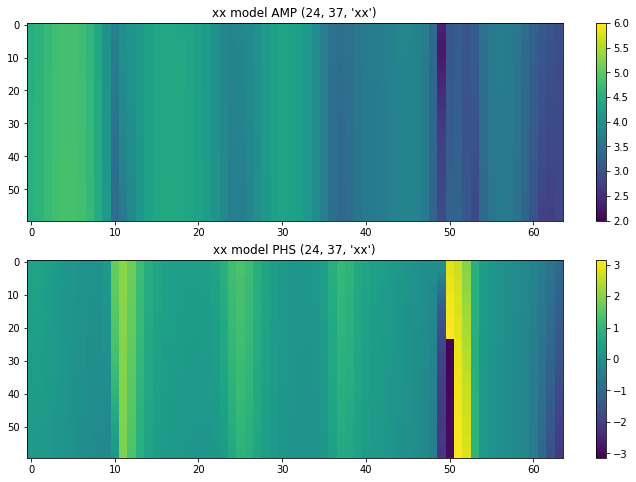

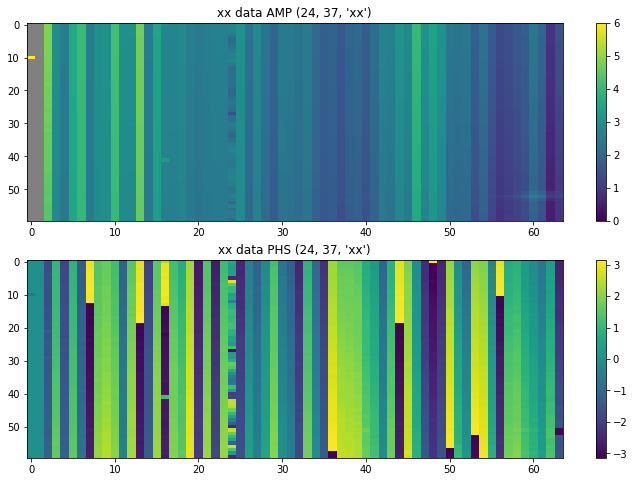

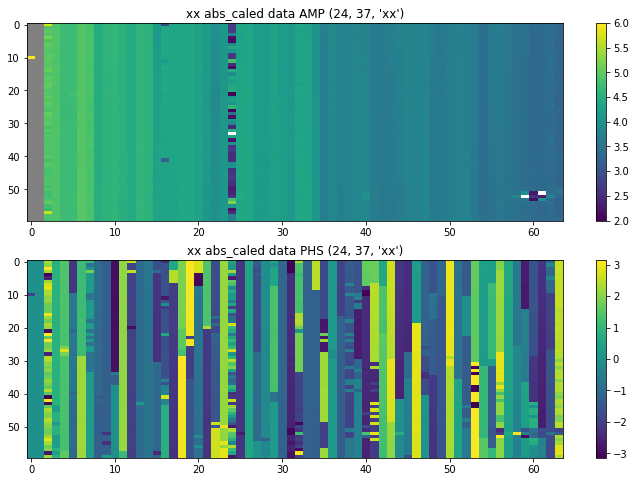

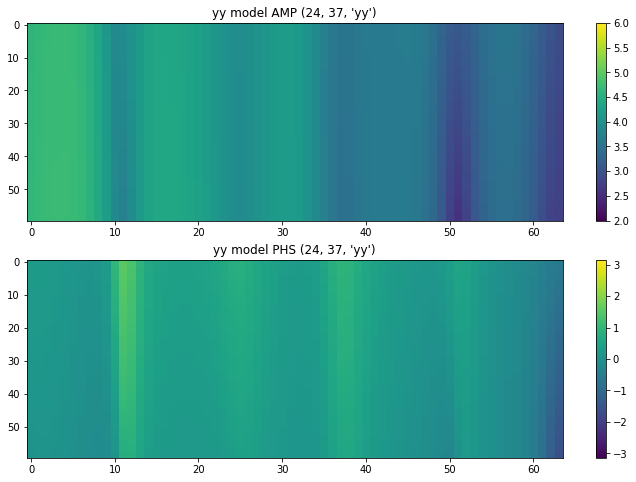

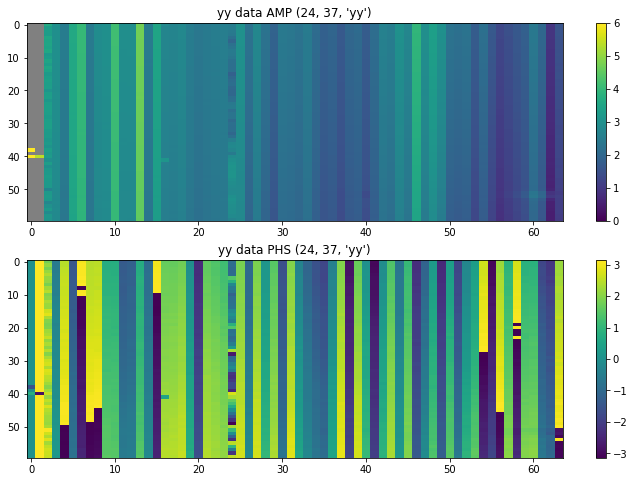

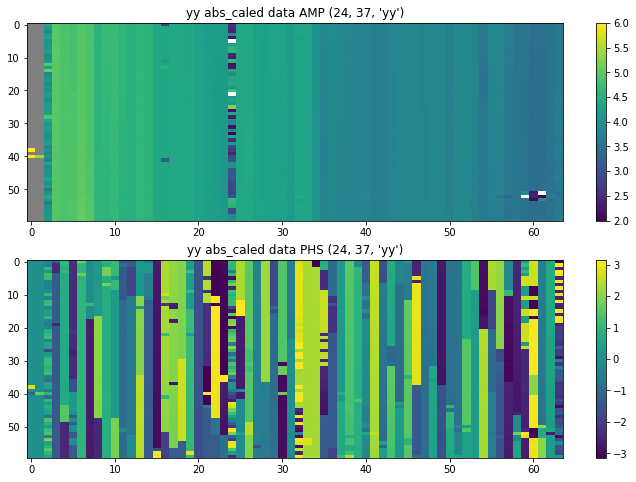

In [235]:
Absolute_Calibration_dred_mfreq_pscal = True

if Absolute_Calibration_dred_mfreq_pscal:
	
	for i in range(2):
		data_dred_mfreq_pscal[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				#model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq_pscal[i][key] = vis_data_dred_mfreq_pscal[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq_pscal[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq_pscal[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
				
		
				
	re_cal_times = 3

	for i in range(2):
		pol = ['xx', 'yy'][i]
		re_cal = 0
		
		if Absolute_Calibration_dred_mfreq_pscal:
			for re_cal in range(re_cal_times): # number of times of absolute calibration
				if re_cal == 0:
					model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
				else:
					#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
				# apply to data
				delay_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(AC_dred_mfreq_pscal[i].data, (AC_dred_mfreq_pscal[i].ant_dly_gain))
				# instantiate class
				DAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# avg phase solver
				DAC_dred_mfreq_pscal[i].phs_logcal(avg=True)
				# apply to data
				dly_phs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DAC_dred_mfreq_pscal[i].data, (DAC_dred_mfreq_pscal[i].ant_phi_gain))
				# instantiate class
				DPAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# run amp linsolve
				DPAC_dred_mfreq_pscal[i].abs_amp_logcal()
				# run phs linsolve
				DPAC_dred_mfreq_pscal[i].TT_phs_logcal(zero_psi=False, four_pol=False)
				# apply to data
				abs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DPAC_dred_mfreq_pscal[i].data, 
										(DPAC_dred_mfreq_pscal[i].abs_psi_gain, DPAC_dred_mfreq_pscal[i].TT_Phi_gain, DPAC_dred_mfreq_pscal[i].abs_eta_gain), gain_convention='multiply')
									
			vis_data_dred_mfreq_pscal_abscal[i] = np.zeros_like(vis_data_dred_mfreq_pscal[i], dtype='complex128')
			for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
				vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq_pscal[i][key].transpose()
				#vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq_pscal[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq_pscal[i][key].transpose()))*1j
			if add_Autobsl:
				autocorr_data_dred_mfreq_pscal_abscal[i] = abs_corr_data_dred_mfreq_pscal[i][auto_select_dred_mfreq_pscal[i]]
			else:
				autocorr_data_dred_mfreq_pscal_abscal[i] = autocorr_vis_mfreq[i]
				
			vis_data_dred_pscal_abscal[i] = vis_data_dred_mfreq_pscal_abscal[i][index_freq[i], :, :]
			if add_Autobsl: 
				autocorr_data_dred_pscal_abscal[i] = autocorr_data_dred_mfreq_pscal_abscal[i][:, index_freq[i]]
			else:
				autocorr_data_dred_pscal_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
			
	for i in range(2):
		pol = ['xx', 'yy'][i]
		
		if Absolute_Calibration_dred_mfreq_pscal:								
			plt.figure(85000000+10*i)
			fig4[i], axes4[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4[i][0])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4[i][1])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)			
			#plt.cla()
				
			plt.figure(95000000+10*i)
			fig4_data[i], axes4_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data[i][0])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=6)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data[i][1])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			#plt.cla()		
				
			####################### after ABS Calibration #########################	
			plt.figure(8500000+10*i)
			fig4_data_abscorr[i], axes4_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data_abscorr[i][0])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data_abscorr[i][1])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			#plt.cla()
	

In [236]:
################################### Store Visibility Data and prepare to Delete Variable ##################################
data_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data[0].astype('complex128').tofile(data_vis_xx_filename)
vis_data[1].astype('complex128').tofile(data_vis_yy_filename)

data_vis_dred_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_xx_dred.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_dred_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_yy_dred.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data_dred[0].astype('complex128').tofile(data_vis_dred_xx_filename)
vis_data_dred[1].astype('complex128').tofile(data_vis_dred_yy_filename)

data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%s_dred_mfreq.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%s_dred_mfreq.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
vis_data_dred_mfreq[0].astype('complex128').tofile(data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq[1].astype('complex128').tofile(data_vis_dred_mfreq_yy_filename)

abscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%s_dred_mfreq_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
abscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%s_dred_mfreq_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
vis_data_dred_mfreq_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_mfreq_yy_filename)

abscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_dred_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, freq)
abscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_dred_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, freq)
vis_data_dred_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_xx_filename)
vis_data_dred_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_yy_filename)

pscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_dred_mfreq_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
pscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_dred_mfreq_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
vis_data_dred_mfreq_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_mfreq_yy_filename)

pscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
pscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
vis_data_dred_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_xx_filename)
vis_data_dred_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_yy_filename)

sys.stdout.flush()


In [237]:
#print noise['x']

In [238]:
################
####read data and N
################
data = {}
Ni = {}
data_shape = {}
ubl_sort = {}
data_filename = full_sim_filename

Use_Simulation_noise = True
From_File_Data = True


for p in ['x', 'y']:
	pol = p + p
	print "%i UBLs to include, longest baseline is %i wavelengths" % (
	nUBL_used, np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq))
	if p == 'x':
		pol_index = 0
		sim_var_filename = sim_var_xx_filename
		sim_vis_filename = sim_vis_xx_filename
		try:
			data_var_filename = data_var_xx_filename
			data_var_filename_pscal = data_var_xx_filename_pscal
		except:
			pass
	elif p == 'y':
		pol_index = 1
		sim_var_filename = sim_var_yy_filename
		sim_vis_filename = sim_vis_yy_filename
		try:
			data_var_filename = data_var_yy_filename
			data_var_filename_pscal = data_var_yy_filename_pscal
		except:
			pass

	# get Ni (1/variance) and data
#	var_filename = datadir + tag + '_%s%s_%i_%i' % (p, p, nt, nUBL) + vartag + '.var'
#	Ni[pol] = 1. / (N[p].reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
	if Use_SimulatedData == 1:
#		Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
		Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
		data[pol] = np.fromfile(sim_vis_filename, dtype='complex128').reshape((nUBL_used, nt_used))
	else:
		if INSTRUMENT == 'miteor':
			if Use_Simulation_noise:
				Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())
			else:
				Ni[pol] = 1. / var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			data[pol] = vis_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')			
			data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0].conjugate()
#			data[pol] = (data[pol].flatten() * jansky2kelvin).conjugate()  # there's a conjugate convention difference
			data[pol] = (data[pol].flatten()).conjugate()  # there's a conjugate convention difference
		elif INSTRUMENT == 'hera47':
			if From_File_Data:
				if Use_PsAbsCal:
					Ni[pol] = 1. / (np.fromfile(data_var_filename_pscal, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			else:
				if Use_PsAbsCal:
					Ni[pol] = 1. / N_data_pscal[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / N_data[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			if From_File_Data:
				if Use_PsAbsCal:
					data[pol] = np.fromfile(globals()['pscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				elif Use_AbsCal:				
					data[pol] = np.fromfile(globals()['abscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				else:
					data[pol] = np.fromfile(globals()['data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
			else:
				if Use_PsAbsCal:
					data[pol] = vis_data_dred_pscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()#.conjugate()  # there's a conjugate convention difference
				elif Use_AbsCal:				
					data[pol] = vis_data_dred_abscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()#.conjugate()  # there's a conjugate convention difference
				else:
					data[pol] = vis_data_dred[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
			#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
			#data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
	data_shape[pol] = (nUBL_used, nt_used)
	ubl_sort[p] = np.argsort(la.norm(used_common_ubls, axis=1))
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024)
sys.stdout.flush()

# Merge data
data = np.array([data['xx'], data['yy']]).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
data = np.concatenate((np.real(data), np.imag(data))).astype('complex128')
Ni = np.concatenate((Ni['xx'], Ni['yy'])).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
Ni = np.concatenate((Ni * 2, Ni * 2))

sys.stdout.flush()

def get_complex_data(real_data, nubl=nUBL_used, nt=nt_used):
	if len(real_data.flatten()) != 2 * nubl * 2 * nt:
		raise ValueError("Incorrect dimensions: data has length %i where nubl %i and nt %i together require length of %i."%(len(real_data), nubl, nt, 2 * nubl * 2 * nt))
	input_shape = real_data.shape
	real_data.shape = (2, nubl, 2, nt)
	result = real_data[0] + 1.j * real_data[1]
	real_data.shape = input_shape
	return result

def stitch_complex_data(complex_data):
	return np.concatenate((np.real(complex_data.flatten()), np.imag(complex_data.flatten()))).astype('complex128')


9 UBLs to include, longest baseline is 14 wavelengths
9 UBLs to include, longest baseline is 14 wavelengths
Memory usage: 8201732.000MB


In [239]:
##################### Delete or Erase Data #######################
# Erase = False 
if Erase:
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	#data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}

	#	try:
	#		cdata = copy.deepcopy(data)
	#	except:
	#		pass

	try:
		del(dflags_sf) 
		#del(cdflags_sf)
	except:
		pass
		
	try:
		del(dflags_dred) 
		#del(cdflags_dred)
	except:
		pass

	try:
		del(dflags)
		#del(cdflags) 
	except:
		pass

	try:
		del(dflags_dred_mfreq)
		#del(cdflags_dred_mfreq) 
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)

	bl_select = 0
	#bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}

	bl_dred_select = 0
	#bl_dred = dflags_dred[0].keys()[bl_dred_select] #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}

	bl_dred_mfreq_select = 8
	#bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}

	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}

	vis_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]


	Del = True
	if Del:
		try:
			del(vis_data)
			del(vis_data_dred)
		except:
			pass
		try:
			del(vis_data_mfreq)
			del(vis_data_dred_mfreq)
		except:
			pass	
			
			
		try:
			del(N_data)
		except:
			pass
		try:
			del(noise_data)
		except:
			pass
		try:
			del(var_data)
		except:
			pass
	#	try:
	#		del(var_data)
	#	except:
	#		pass

sys.stdout.flush()


In [240]:
print Ni

[ 16.79464898+0.j  33.01997624+0.j 103.03378403+0.j ...  65.77391727+0.j
  11.0182705 +0.j  17.72367123+0.j]


In [241]:
# pre_ampcal = False

In [242]:
#pre_ampcal = True

In [243]:
################################
################################
####pre_calibrate################
################################
################################
#####1. antenna based calibration#######
for cal_index in range(1):
	if cal_index == 0:
		raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
#	if pre_ampcal:
#		pre_ampcal = False if cal_index == 0 else True
#		cal_index += 1
#	else:
#		cal_index = 2 
	if antpairs is not None:
		used_antpairs = antpairs[abs(ubl_index['x'])-1]
		n_usedants = np.unique(used_antpairs)
	#####2. re-phasing and crosstalk#######
	additive_A = np.zeros((nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)).astype('complex128')

	#put in autocorr regardless of whats saved on disk
	for p in range(2):
		additive_A[:, p, :, 0] = fullsim_vis[:, p]
		for i in range(nUBL_used):
			additive_A[i, p, :, 1 + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
			additive_A[i, p, :, 1 + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]
	additive_A.shape = (nUBL_used * 2 * nt_used, 1 + 4 * nUBL_used)

	if pre_calibrate:
		#import omnical.calibration_omni as omni
		#raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
		#raw_Ni = np.copy(Ni)

		real_additive_A = np.concatenate((np.real(additive_A), np.imag(additive_A)), axis=0).astype('complex128')
		if pre_ampcal:#if pre_ampcal, allow xx and yy to fit amp seperately
			n_prefit_amp = 2
			real_additive_A.shape = (2 * nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)
			real_additive_A_expand = np.zeros((2 * nUBL_used, 2, nt_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
			for i in range(n_prefit_amp):
				real_additive_A_expand[:, i, :, i] = real_additive_A[:, i, :, 0]
			real_additive_A_expand[..., n_prefit_amp:] = real_additive_A[..., 1:]
			real_additive_A = real_additive_A_expand
			real_additive_A.shape = (2 * nUBL_used * 2 * nt_used, n_prefit_amp + 4 * nUBL_used)
		else:
			n_prefit_amp = 1

		additive_AtNiA = np.empty((n_prefit_amp + 4 * nUBL_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
		if pre_addcal:
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.inv(additive_AtNiA)
		else:
			real_additive_A[..., n_prefit_amp:] = 0.
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.pinv(additive_AtNiA)

		niter = 0
		rephases = np.zeros((2,2))
		additive_term = np.zeros_like(data)
		additive_term_incr = np.zeros_like(data)
		while (niter == 0 or la.norm(rephases) > .001 or la.norm(additive_term_incr) / la.norm(data) > .001) and niter < 500:
			niter += 1

			if pre_phscal:
				cdata = get_complex_data(data)
				for p, pol in enumerate(['xx', 'yy']):
					#rephase = omni.solve_phase_degen_fast(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephase = solve_phase_degen(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephases[p] = rephase
					if p == 0:
						print 'pre process rephase', pol, rephase,
					else:
						print pol, rephase
					cdata[:, p] *= np.exp(1.j * used_common_ubls[:, :2].dot(rephase))[:, None]
				data = stitch_complex_data(cdata).astype('complex128')

			additive_sol = additive_AtNiAi.dot(np.transpose(real_additive_A).dot(data * Ni))
			print '>>>>>>>>>>>>>additive fitting amp', additive_sol[:n_prefit_amp],
			additive_term_incr = real_additive_A[:, n_prefit_amp:].dot(additive_sol[n_prefit_amp:])
			data -= additive_term_incr
			additive_term += additive_term_incr
			print "additive fraction", la.norm(additive_term_incr) / la.norm(data),

		cadd = get_complex_data(additive_term)

		if pre_ampcal:
			data = stitch_complex_data(get_complex_data(data) / additive_sol[:n_prefit_amp, None])
			if Use_PsAbsCal and not comply_ps2mod_autocorr:
				Ni = stitch_complex_data(get_complex_data(Ni) * additive_sol[:n_prefit_amp, None]**2)
			additive_term = stitch_complex_data(get_complex_data(additive_term) / additive_sol[:n_prefit_amp, None])
			
			print(additive_sol[:n_prefit_amp])
			
print 'saving data to', os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside)
np.savez(os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside),
		 data=data,
		 simdata=stitch_complex_data(fullsim_vis),
		 psdata=[stitch_complex_data(vis) for vis in pt_vis],
		 pt_sources=pt_sources,
		 ubls=used_common_ubls,
		 tlist=lsts,
		 Ni=Ni,
		 freq=freq)
	
	


Estimated time for A 2160 by 38 4.054752e-05 minutes pre process rephase xx [0.27450346 0.05968977] yy [-0.04367035 -0.02732008]
>>>>>>>>>>>>>additive fitting amp [-0.05201654+0.j -0.01696247+0.j] additive fraction 1.0850007040036715 pre process rephase xx [-0.10894622  0.12352712] yy [0.06101792 0.15301679]
>>>>>>>>>>>>>additive fitting amp [0.07683491+0.j 0.00026008+0.j] additive fraction 1.16772070244603 pre process rephase xx [-1.59142447e-03  1.59334937e-05] yy [-0.11874613 -0.17059628]
>>>>>>>>>>>>>additive fitting amp [ 0.07716679+0.j -0.00402957+0.j] additive fraction 0.08288475773942063 pre process rephase xx [-1.50156737e-03  2.40478356e-05] yy [0.09050272 0.12180508]
>>>>>>>>>>>>>additive fitting amp [ 0.07744289+0.j -0.01507526+0.j] additive fraction 0.3013079995788284 pre process rephase xx [-1.44869476e-03  2.28683749e-05] yy [-0.05525163  0.1558699 ]
>>>>>>>>>>>>>additive fitting amp [0.07767209+0.j 0.0164852 +0.j] additive fraction 0.501294057150062 pre process rephase 

>>>>>>>>>>>>>additive fitting amp [0.07649051+0.j 0.02230454+0.j] additive fraction 0.0033797210902543574 pre process rephase xx [-7.36357490e-05 -5.10683894e-05] yy [0.00039053 0.00030817]
>>>>>>>>>>>>>additive fitting amp [0.07647091+0.j 0.02234037+0.j] additive fraction 0.00321928513781107 pre process rephase xx [-6.82204086e-05 -5.04972126e-05] yy [0.00037208 0.00030788]
>>>>>>>>>>>>>additive fitting amp [0.07645254+0.j 0.02237488+0.j] additive fraction 0.0030797698373764846 pre process rephase xx [-6.32380254e-05 -4.98925229e-05] yy [0.00035559 0.00030752]
>>>>>>>>>>>>>additive fitting amp [0.07643534+0.j 0.02240816+0.j] additive fraction 0.00295483790520734 pre process rephase xx [-5.86532177e-05 -4.92588440e-05] yy [0.00034004 0.00030657]
>>>>>>>>>>>>>additive fitting amp [0.0764192 +0.j 0.02244022+0.j] additive fraction 0.002837055525938702 pre process rephase xx [-5.44317858e-05 -4.86032306e-05] yy [0.00031967 0.00030385]
>>>>>>>>>>>>>additive fitting amp [0.07640406+0.j 0.022

>>>>>>>>>>>>>additive fitting amp [0.07609907+0.j 0.02308619+0.j] additive fraction 0.0012793237048292585 pre process rephase xx [-1.38060954e-05 -2.78069948e-05] yy [0.00014315 0.00020224]
>>>>>>>>>>>>>additive fitting amp [0.07609422+0.j 0.02309144+0.j] additive fraction 0.0012664340185108524 pre process rephase xx [-1.37238539e-05 -2.75206825e-05] yy [0.00014172 0.00020062]
>>>>>>>>>>>>>additive fitting amp [0.07608942+0.j 0.02309639+0.j] additive fraction 0.0012542171589285738 pre process rephase xx [-1.36400213e-05 -2.72384989e-05] yy [0.00014037 0.00019902]
>>>>>>>>>>>>>additive fitting amp [0.07608464+0.j 0.02310104+0.j] additive fraction 0.001242609825533798 pre process rephase xx [-1.35547443e-05 -2.69603353e-05] yy [0.00013911 0.00019743]
>>>>>>>>>>>>>additive fitting amp [0.0760799 +0.j 0.02310541+0.j] additive fraction 0.001231557140834886 pre process rephase xx [-1.34681604e-05 -2.66860875e-05] yy [0.00013792 0.00019585]
>>>>>>>>>>>>>additive fitting amp [0.07607518+0.j 0.

>>>>>>>>>>>>>additive fitting amp [0.0759128 +0.j 0.02307261+0.j] additive fraction 0.0013371404884941526 pre process rephase xx [-9.91513777e-06 -1.81039505e-05] yy [0.00016298 0.00017287]
>>>>>>>>>>>>>additive fitting amp [0.07590935+0.j 0.02306662+0.j] additive fraction 0.001344458687735124 pre process rephase xx [-9.83488567e-06 -1.79420154e-05] yy [0.00016396 0.0001743 ]
>>>>>>>>>>>>>additive fitting amp [0.07590593+0.j 0.02306036+0.j] additive fraction 0.0013523756369370995 pre process rephase xx [-9.75511267e-06 -1.77817502e-05] yy [0.00016501 0.00017574]
>>>>>>>>>>>>>additive fitting amp [0.07590253+0.j 0.02305382+0.j] additive fraction 0.0013609297987868482 pre process rephase xx [-9.67582732e-06 -1.76231305e-05] yy [0.00017007 0.00017713]
>>>>>>>>>>>>>additive fitting amp [0.07589916+0.j 0.02304685+0.j] additive fraction 0.0013974881226886742 pre process rephase xx [-9.59703737e-06 -1.74661325e-05] yy [0.00017555 0.00017867]
>>>>>>>>>>>>>additive fitting amp [0.07589581+0.j 0

>>>>>>>>>>>>>additive fitting amp [0.0757981 +0.j 0.02204353+0.j] additive fraction 0.005376868910881652 pre process rephase xx [-3.35678828e-06 -9.83351976e-06] yy [0.00071149 0.00047356]
>>>>>>>>>>>>>additive fitting amp [0.07579665+0.j 0.02196486+0.j] additive fraction 0.005528419617984313 pre process rephase xx [-3.28056611e-06 -9.67275217e-06] yy [0.0007487  0.00050847]
>>>>>>>>>>>>>additive fitting amp [0.07579523+0.j 0.02187882+0.j] additive fraction 0.005823450537740459 pre process rephase xx [-3.21908509e-06 -9.52132531e-06] yy [0.00077696 0.00054551]
>>>>>>>>>>>>>additive fitting amp [0.07579383+0.j 0.02178549+0.j] additive fraction 0.006056690045789681 pre process rephase xx [-3.21219739e-06 -9.40296108e-06] yy [0.000792   0.00057512]
>>>>>>>>>>>>>additive fitting amp [0.07579245+0.j 0.02168595+0.j] additive fraction 0.006189618161453602 pre process rephase xx [-3.20336057e-06 -9.28667084e-06] yy [0.00080396 0.0006008 ]
>>>>>>>>>>>>>additive fitting amp [0.07579107+0.j 0.021

>>>>>>>>>>>>>additive fitting amp [0.07574694+0.j 0.00166478+0.j] additive fraction 0.004324661469267499 pre process rephase xx [-2.33114129e-06 -5.86999383e-06] yy [ 0.00230949 -0.00191899]
>>>>>>>>>>>>>additive fitting amp [0.07574599+0.j 0.00168546+0.j] additive fraction 0.0015279120957862131 pre process rephase xx [-2.31486554e-06 -5.80353138e-06] yy [ 0.0009799  -0.00060113]
>>>>>>>>>>>>>additive fitting amp [0.07574505+0.j 0.00164828+0.j] additive fraction 0.0009795573835175836 pre process rephase xx [-2.29819499e-06 -5.73800790e-06] yy [0.00032909 0.00018998]
>>>>>>>>>>>>>additive fitting amp [0.07574412+0.j 0.00155066+0.j] additive fraction 0.0020186820259714207 pre process rephase xx [-2.28117139e-06 -5.67339889e-06] yy [6.85197944e-04 8.80673745e-05]
>>>>>>>>>>>>>additive fitting amp [0.07574319+0.j 0.00141433+0.j] additive fraction 0.0028292048938610907 pre process rephase xx [-2.26383361e-06 -5.60968107e-06] yy [ 6.92558882e-05 -3.37360782e-05]
>>>>>>>>>>>>>additive fitting

In [244]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(raw_data)/la.norm(data)
print #la.norm(raw_Ni)
print la.norm(Ni)
print data
print fullsim_vis

1250863.3656815975
3043.145498751795
490013.22120103094
0.002432836057272794

45175.295018535166
[-10031.12359503+0.j  -9977.62713711+0.j  -9843.26638438+0.j ...
 -47922.59838697+0.j -50463.05033737+0.j -46365.54557477+0.j]
[[[ -6933.77123406+9.77620029e+02j  -6932.71429535+9.90285496e+02j
    -6931.54735726+1.00292621e+03j ...  -6710.71177322+1.62681606e+03j
    -6702.61150573+1.63660432e+03j  -6694.40249167+1.64631833e+03j]
  [-10985.34344495+8.07110421e+02j -10987.25437447+8.16943652e+02j
   -10989.07214343+8.26744406e+02j ... -10947.26104782+1.29942875e+03j
   -10943.28959943+1.30641289e+03j -10939.21712817+1.31333067e+03j]]

 [[ -4287.04953807-8.39421014e+02j  -4295.11989577-8.27811111e+02j
    -4303.13823568-8.16059590e+02j ...  -4573.57220637+1.74733880e+01j
    -4574.12338644+3.55429442e+01j  -4574.47470352+5.36660703e+01j]
  [ -2498.33371822-7.36639388e+02j  -2509.05309706-7.28157299e+02j
    -2519.7313397 -7.19513860e+02j ...  -2941.85886904-2.34884758e+01j
    -2945.25266905

In [245]:
print additive_sol[0], additive_sol[1], n_prefit_amp
print (additive_sol[0] * (pre_ampcal)+(not pre_ampcal))
print additive_sol[:n_prefit_amp, None]
print pre_ampcal

(0.07574227637525865+0j) (0.0014098392619016561+0j) 2
(0.07574227637525865+0j)
[[0.07574228+0.j]
 [0.00140984+0.j]]
True


In [246]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(fullsim_vis)/la.norm(data)
#print la.norm(raw_Ni)
print la.norm(Ni)
print Ni
print Ni.max()
print Ni**-0.5

1250863.3656815975
3043.145498751795
490013.22120103094
0.3917400050596429
45175.295018535166
[9.63490946e-02+0.j 1.89432052e-01+0.j 5.91093736e-01+0.j ...
 1.30735313e-04+0.j 2.19004295e-05+0.j 3.52283974e-05+0.j]
(30037.07268751297+0j)
[  3.22163386+0.j   2.29759389+0.j   1.30068407+0.j ...  87.45880626+0.j
 213.68482626+0.j 168.48201832+0.j]


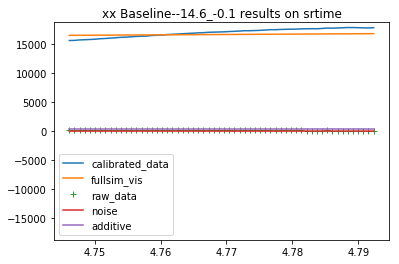

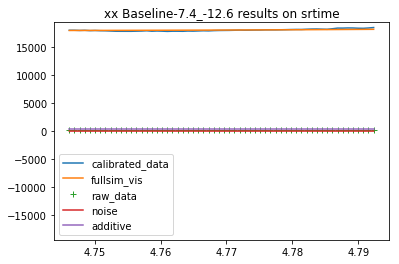

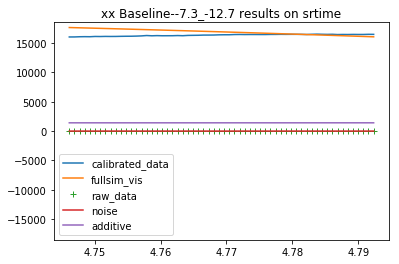

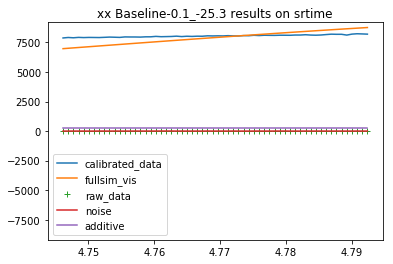

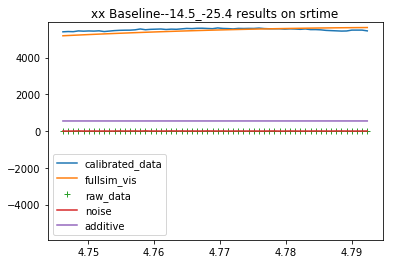

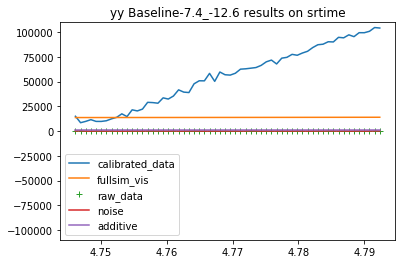

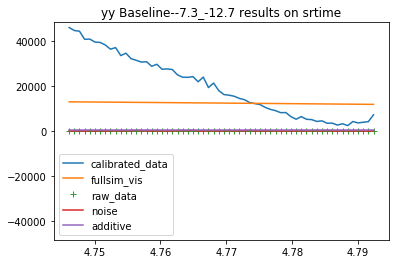

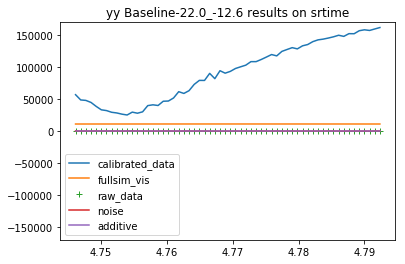

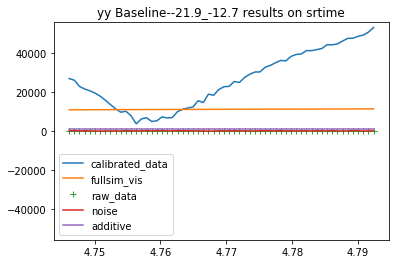

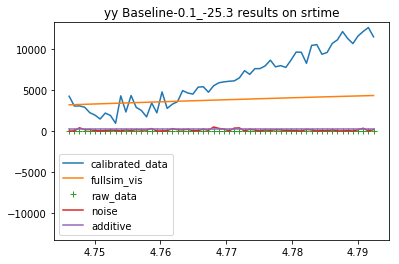

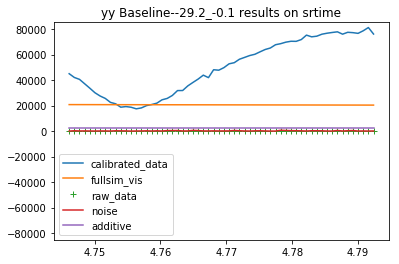

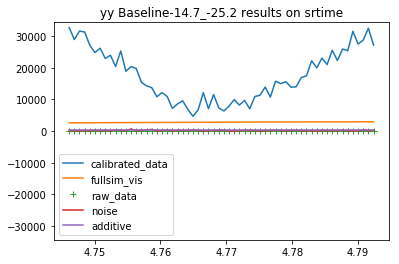

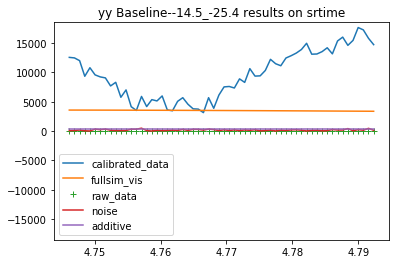

In [247]:
if plot_data_error:
	#plt.clf()
	
	cdata = get_complex_data(data)
	crdata = get_complex_data(raw_data) #/ (additive_sol[0] * (pre_ampcal) + (not pre_ampcal))
	cNi = get_complex_data(Ni)
	

	fun = np.abs
	srt = sorted((lsts - lst_offset)%24.+lst_offset)
	asrt = np.argsort((lsts - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	figure = {}
#		plt.figure(400)
#		plt.subplots_adjust(hspace=1.2,wspace=0.7)
	for p in range(2):
#			plt.figure(400+10*p)
#			plt.subplots_adjust(hspace=1.2,wspace=0.7)
#			for nu, u in enumerate(us):
#				
#				plt.subplot(5, (len(us) + 4) / 5, nu + 1)
#				plt.plot(srt, fun(cdata[u, p][asrt]))
#				plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#				plt.plot(srt, fun(crdata[u, p][asrt]))
#				plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#				if pre_calibrate:
#					plt.plot(srt, fun(cadd[u, p][asrt]))
#				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p]))), np.max(fun(cadd[u, p]))])
#				plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
#				plt.ylim([-1.05*data_range, 1.05*data_range])		
#			plt.savefig(script_dir + '/../Output/%s-dipole-precal_data_error-fullvis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, ['xx','yy'][p], beam_freqs[ind], bnside, nside_standard))
#			plt.show(block=False)
		
		#plt.figure(500+10*p)
		#plt.subplots_adjust(hspace=1.2,wspace=0.7)
		for nu, u in enumerate(us):
			plt.figure(5000+100*p+nu)
			#plt.subplot(5, (len(us) + 4) / 5, nu + 1)
			figure[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure[3], = plt.plot(srt, fun(crdata[u, p][asrt]), '+', label='raw_data')
			figure[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(fun(cadd[u, p]))]) #5 * np.max(np.abs(fun(cNi[u, p]))),
			else:
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p])))]) #5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure[1], figure[2], figure[3], figure[4], figure[5]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure[1], figure[2], figure[3], figure[4]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Full_vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			
			
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()

Del=True
if Del:
	try:
		del(crdata)
		del(cNi)
		del(cdata)
		del(cadd)
	except:
		pass
	
sys.stdout.flush()


In [248]:
################
####Use N and the par file generated by pixel_parameter_search to determine dynamic pixel parameters
################
if seek_optimal_threshs:
	par_result_filename = full_sim_filename.replace('.simvis', '_par_search.npz')
	par_file = np.load(par_result_filename)
	qualified_par_mask = (par_file['err_norm'] / np.sum(1./Ni)**.5) < dynamic_precision
	index_min_pix_in_mask = np.argmin(par_file['n_pix'][qualified_par_mask])
	thresh, valid_pix_thresh = par_file['parameters'][qualified_par_mask][index_min_pix_in_mask]
print "<<<<<<<<<<<<picked std thresh %.3f, pix thresh %.1e"%(thresh, valid_pix_thresh)

sys.stdout.flush()

<<<<<<<<<<<<picked std thresh 2.000, pix thresh 1.0e-04


In [249]:
########################################################################
########################processing dynamic pixelization######################
########################################################################
gsm_beamweighted = equatorial_GSM_standard * beam_weight
if AtNiA_only:
	valid_npix = pixel_scheme_number
	pixel_scheme_file = np.load(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq))
	fake_solution_map = pixel_scheme_file['gsm']
	thetas = pixel_scheme_file['thetas']
	phis= pixel_scheme_file['phis']
	sizes= pixel_scheme_file['sizes']
	nside_distribution= pixel_scheme_file['nside_distribution']
	final_index= pixel_scheme_file['final_index']
	npix = pixel_scheme_file['n_fullsky_pix']
	valid_pix_mask= pixel_scheme_file['valid_pix_mask']
	thresh= pixel_scheme_file['thresh']
else:
	nside_distribution = np.zeros(12 * nside_standard ** 2)
	final_index = np.zeros(12 * nside_standard ** 2, dtype=int)
	thetas, phis, sizes = [], [], []
	abs_thresh = np.mean(gsm_beamweighted) * thresh
	pixelize(gsm_beamweighted, nside_distribution, nside_standard, nside_start, abs_thresh,
			 final_index, thetas, phis, sizes)
	npix = len(thetas)
	valid_pix_mask = hpf.get_interp_val(gsm_beamweighted, thetas, phis, nest=True) > valid_pix_thresh * max(gsm_beamweighted)
	valid_npix = np.sum(valid_pix_mask)
	print '>>>>>>VALID NPIX =', valid_npix

	fake_solution_map = np.zeros_like(thetas)      
	for i in range(len(fake_solution_map)):
		fake_solution_map[i] = np.sum(equatorial_GSM_standard[final_index == i])
	fake_solution_map = fake_solution_map[valid_pix_mask]
	sizes = np.array(sizes)[valid_pix_mask]
	thetas = np.array(thetas)[valid_pix_mask]
	phis = np.array(phis)[valid_pix_mask]
	np.savez(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq), gsm=fake_solution_map, thetas=thetas, phis=phis, sizes=sizes, nside_distribution=nside_distribution, final_index=final_index, n_fullsky_pix=npix, valid_pix_mask=valid_pix_mask, thresh=thresh)#thresh is in there for idiotic reason  due to unneccessary inclusion of thresh in A filename

if not fit_for_additive:
	fake_solution = np.copy(fake_solution_map)
else:
	fake_solution = np.concatenate((fake_solution_map, np.zeros(4 * nUBL_used)))

def sol2map(sol):
	solx = sol[:valid_npix]
	full_sol = np.zeros(npix)
	full_sol[valid_pix_mask] = solx / sizes
	return full_sol[final_index]

def sol2additive(sol):
	return np.transpose(sol[valid_npix:].reshape(nUBL_used, 2, 2), (1, 0, 2))#ubl by pol by re/im before transpose


>>>>>>VALID NPIX = 10420


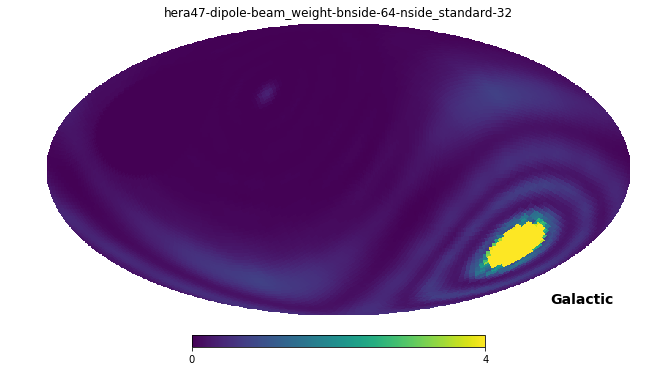

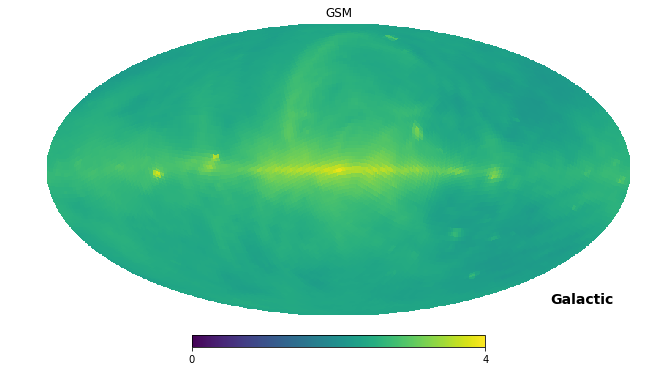

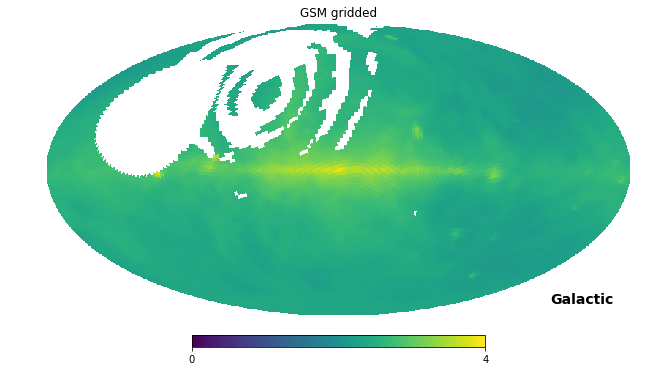

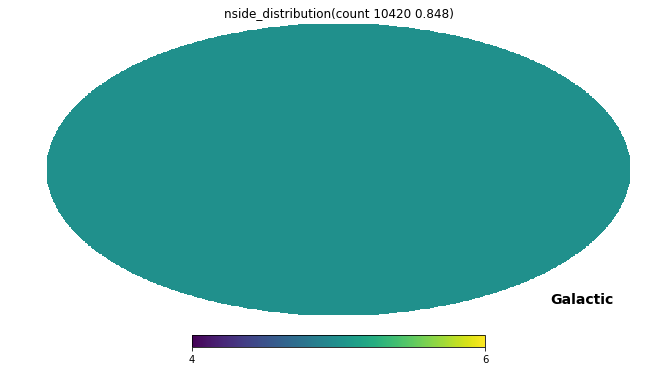

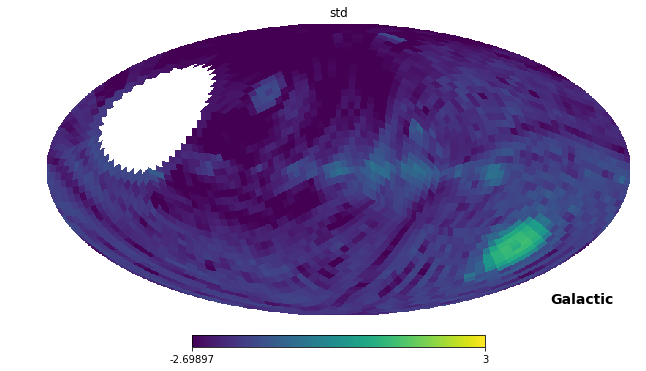

In [250]:
# final_index_filename = datadir + tag + '_%i.dyind%i_%.3f'%(nside_standard, npix, thresh)
# final_index.astype('float32').tofile(final_index_filename)
# sizes_filename = final_index_filename.replace('dyind', "dysiz")
# np.array(sizes).astype('float32').tofile(sizes_filename)
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)
	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'CG'
    
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

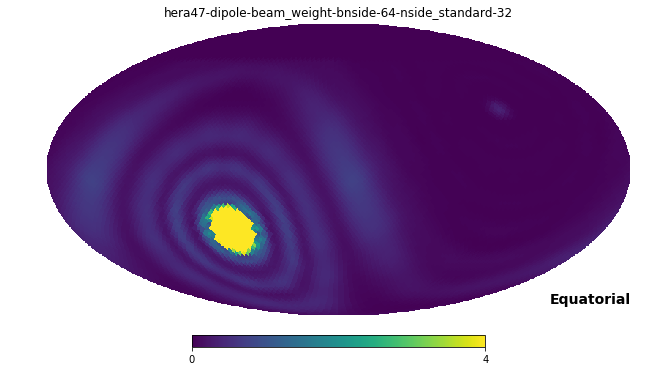

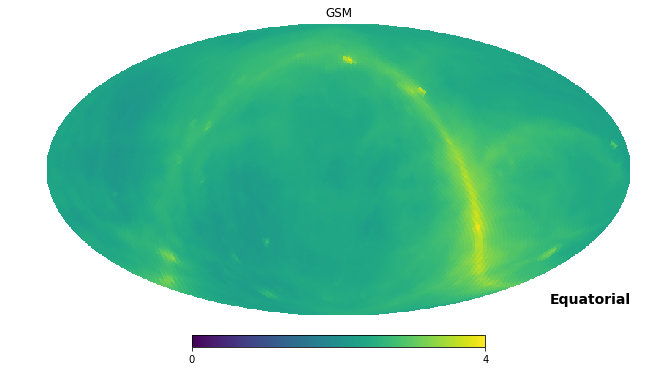

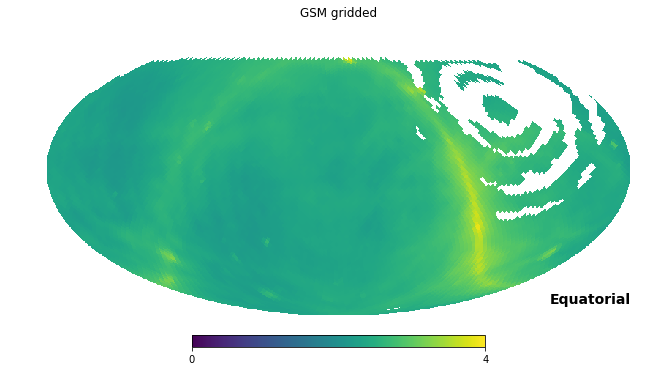

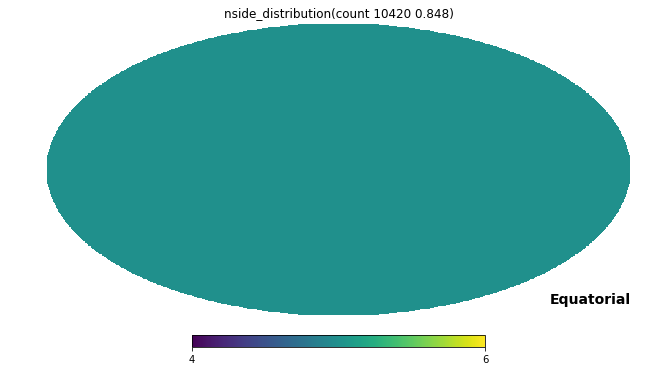

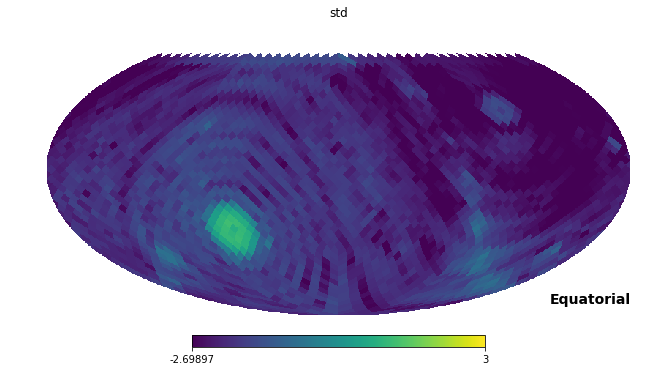

In [251]:
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)

	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'C'
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

In [252]:
##################################################################
####################compute dynamic A matrix########################
###############################################################
A_tag = 'A_dI'
A_filename = A_tag + '_u%i_t%i_p%i_n%i_%i_b%i_%.3f_v%.1f' % (nUBL_used, nt_used, valid_npix, nside_start, nside_standard, bnside, thresh, A_version)
A_path = datadir + tag + A_filename
AtNiA_tag = 'AtNiA_N%s'%vartag
if not fit_for_additive:
	AtNiA_tag += "_noadd"
elif crosstalk_type == 'autocorr':
	AtNiA_tag += "_autocorr"
if pre_ampcal:
	AtNiA_tag += "_ampcal"
AtNiA_filename = AtNiA_tag + A_filename
AtNiA_path = datadir + tag + AtNiA_filename
if os.path.isfile(AtNiA_path) and AtNiA_only and not force_recompute:
	sys.exit(0)


def get_A(additive_A=None):
	if os.path.isfile(A_path) and not force_recompute:
		print "Reading A matrix from %s" % A_path
		sys.stdout.flush()
		A = np.fromfile(A_path, dtype='complex128').reshape((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used))
	else:

		print "Computing A matrix..."
		sys.stdout.flush()
		A = np.empty((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used), dtype='complex128')
		timer = time.time()
		for n in range(valid_npix):
			ra = phis[n]
			dec = PI / 2 - thetas[n]
			print "\r%.1f%% completed, %f minutes left" % (
			100. * float(n) / (valid_npix), float(valid_npix - n) / (n + 1) * (float(time.time() - timer) / 60.)),
			sys.stdout.flush()

			A[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_x, tlist=lsts) / 2 #xx and yy are each half of I
			A[:, -1, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_y, tlist=lsts) / 2



		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		A.tofile(A_path)

	# #put in autocorr regardless of whats saved on disk
	# for i in range(nUBL_used):
	#     for p in range(2):
	#         A[i, p, :, valid_npix + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
	#         A[i, p, :, valid_npix + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]

	A.shape = (nUBL_used * 2 * nt_used, A.shape[-1])
	if not fit_for_additive:
		A = A[:, :valid_npix]
	else:
		A[:, valid_npix:] = additive_A[:, 1:]
	# Merge A
	try:
		return np.concatenate((np.real(A), np.imag(A))).astype('complex128')
	except MemoryError:
		print "Not enough memory, concatenating A on disk ", A_path + 'tmpre', A_path + 'tmpim',
		sys.stdout.flush()
		Ashape = list(A.shape)
		Ashape[0] = Ashape[0] * 2
		np.real(A).tofile(A_path + 'tmpre')
		np.imag(A).tofile(A_path + 'tmpim')
		del (A)
		os.system("cat %s >> %s" % (A_path + 'tmpim', A_path + 'tmpre'))

		os.system("rm %s" % (A_path + 'tmpim'))
		A = np.fromfile(A_path + 'tmpre', dtype='complex128').reshape(Ashape)
		os.system("rm %s" % (A_path + 'tmpre'))
		print "done."
		sys.stdout.flush()
		return A.astype('complex128')

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)
	
Ashape0, Ashape1 = A.shape

# for ipix in hpf.ang2pix(nside_standard, thetas, phis, nest=True):
#     if

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

sys.stdout.flush()


def get_vis_normalization(data, clean_sim_data):
	a = np.linalg.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	b = np.linalg.norm(clean_sim_data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	return a.dot(b) / b.dot(b)


Computing A matrix...


78.1% completed, 0.142892 minutes left

100.0% completed, 0.000062 minutes left                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [253]:
tlist

array([15.01222222, 15.01527778, 15.01833333, 15.02138889, 15.02416667,
       15.02722222, 15.03027778, 15.03333333, 15.03611111, 15.03916667,
       15.04222222, 15.045     , 15.04805556, 15.05111111, 15.05416667,
       15.05694444, 15.06      , 15.06305556, 15.06611111, 15.06888889,
       15.07194444, 15.075     , 15.07805556, 15.08083333, 15.08388889,
       15.08694444, 15.09      , 15.09277778, 15.09583333, 15.09888889,
       15.10166667, 15.10472222, 15.10777778, 15.11083333, 15.11361111,
       15.11666667, 15.11972222, 15.12277778, 15.12555556, 15.12861111,
       15.13166667, 15.13472222, 15.1375    , 15.14055556, 15.14361111,
       15.14666667, 15.14944444, 15.1525    , 15.15555556, 15.15833333,
       15.16138889, 15.16444444, 15.1675    , 15.17027778, 15.17333333,
       15.17638889, 15.17944444, 15.18222222, 15.18527778, 15.18833333])

In [254]:
Integration_Time
np.sum(Ni**-1)**.5

(6753.140554144768+0j)

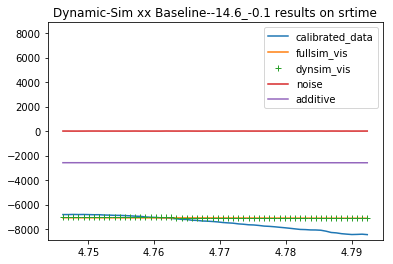

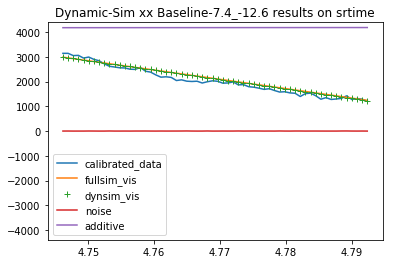

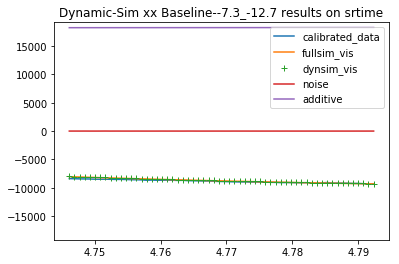

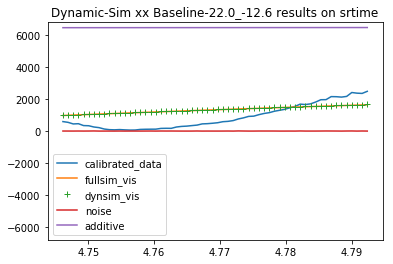

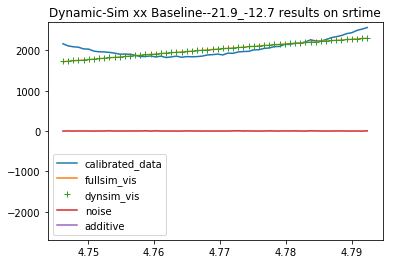

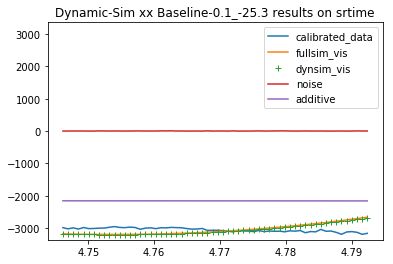

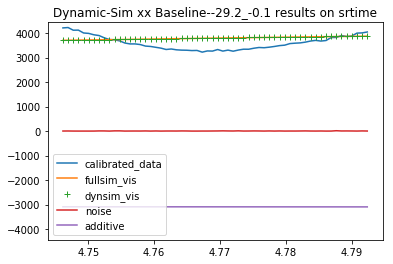

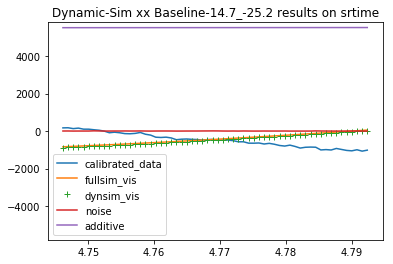

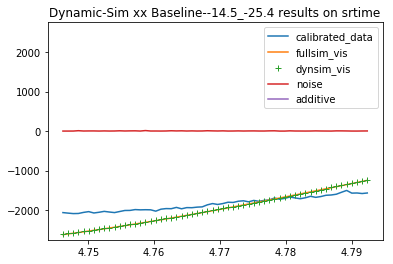

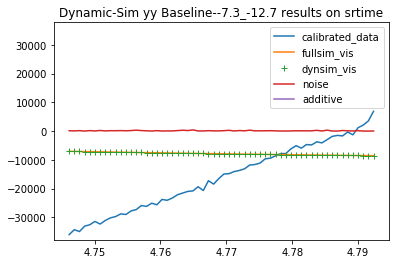

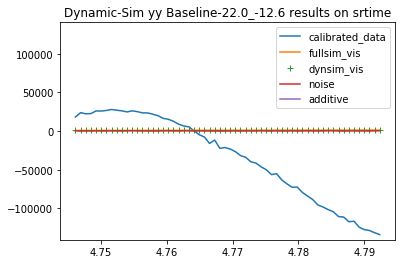

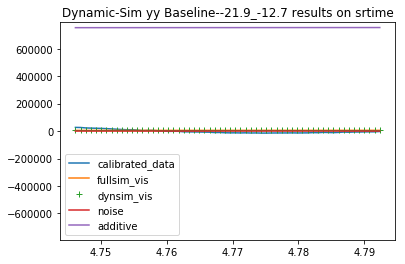

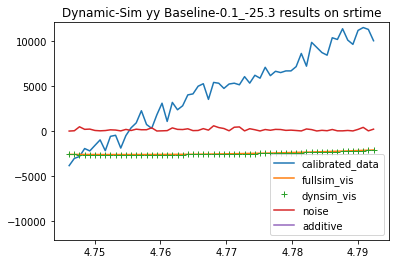

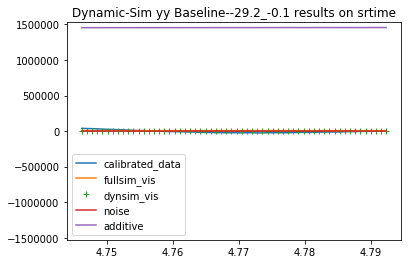

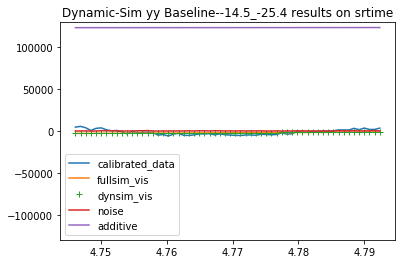

total deviation between dynamic and full sim compared to sim:  0.004945533540446285
total deviation between dynamic and full sim compared to data noise:  (0.35885182624023215+0j)


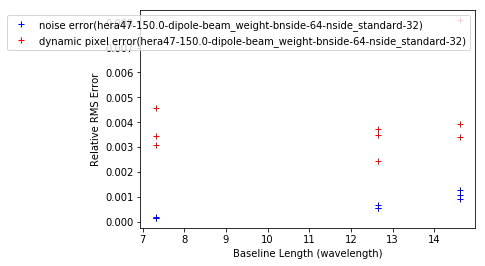

Normalization from visibilities 1.8766310717951957


In [255]:
##############
# simulate visibilities according to the pixelized A matrix
##############
clean_sim_data = A.dot(fake_solution.astype(A.dtype))

if plot_data_error:
	cdata = get_complex_data(data)
	cdynamicmodel = get_complex_data(clean_sim_data)
	cNi = get_complex_data(Ni)
	if pre_calibrate:
		cadd = get_complex_data(additive_term)

	fun = np.imag
	srt = sorted((lsts - lst_offset)%24.+lst_offset)
	asrt = np.argsort((lsts - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	#plt.clf()
#	plt.figure(60)
#	for p in range(2):
#		for nu, u in enumerate(us):
#
#			plt.subplot(2, len(us), len(us) * p + nu + 1)
#			plt.plot(srt, fun(cdata[u, p][asrt]))
#			plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#			plt.plot(srt, fun(cdynamicmodel[u, p][asrt]))
#			plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#			if pre_calibrate:
#				plt.plot(srt, fun(cadd[u, p][asrt]))
#			data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p])))])
#			plt.title("%.1f,%.1f"%(used_common_ubls[u, 0], used_common_ubls[u, 1]))
#			plt.ylim([-1.05*data_range, 1.05*data_range])
#
#	print "total deviation between dynamic and full sim compared to sim", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
#	print "total deviation between dynamic and full sim compared to data noise", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
#	plt.savefig(script_dir + '/../Output/data_error_dynamic-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
	
	figure_D={}
	for p in range(2):
		for nu, u in enumerate(us):
			plt.figure(6000+100*p+nu)
			#plt.subplot(2, len(us), len(us) * p + nu + 1)
			figure_D[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure_D[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure_D[3], = plt.plot(srt, fun(cdynamicmodel[u, p][asrt]), '+', label='dynsim_vis')
			figure_D[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure_D[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p]))), np.max(fun(cadd[u, p]))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			else:	
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p])))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("Dynamic-Sim %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4], figure_D[5]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Dynamic_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.clf()
			#plt.gcf().clear()
	print "total deviation between dynamic and full sim compared to sim: ", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
	print "total deviation between dynamic and full sim compared to data noise: ", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
	
	plt.figure(70)
	try:
		fullsim_vis2 = 4 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard / 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
		plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
		plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, bnside, nside_standard))
	except:
		try:
			fullsim_vis2 = .25 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard * 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
			plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
			plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, bnside, nside_standard))
		except:
			pass
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, np.sum(2. / np.real(get_complex_data(Ni)), axis=-1)[:, 0]**.5 / la.norm(fullsim_vis, axis=-1)[:, 0], 'b+', label='noise error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
#	plt.legend()
#	plt.xlabel('Baseline Length (wavelength)')
#	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/noise_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
#	plt.gcf().clear()
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - cdynamicmodel, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'r+', label='dynamic pixel error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.legend(loc=0)
	plt.xlabel('Baseline Length (wavelength)')
	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/dynamic_pixel_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()


vis_normalization = get_vis_normalization(data, stitch_complex_data(fullsim_vis))
print "Normalization from visibilities", vis_normalization

Del=True
if Del:
	try:
		del(cdata)
		del(cNi)
		del(cdynamicmodel)
	except:
		pass

sys.stdout.flush()



In [256]:
##renormalize the model
fake_solution *= vis_normalization # GSM Masked and being Normalized (abs calibration), Clean
clean_sim_data *= vis_normalization # Dynamic Simulated, Clean, being Normalized (abs calibration)
fullsim_vis *= vis_normalization # Full Simulated, Clean, being Normalized (abs calibration)
sim_data = stitch_complex_data(fullsim_vis) + np.random.randn(len(data)) / Ni ** .5 # Full Simulated, being Normalized (abs calibration), Noise
# "data" is Calibrated Full Simulated Visibilities

#add additive term
if fit_for_additive:
	sim_data.shape = (2, nUBL_used, 2, nt_used)
	sim_additive = np.random.randn(2, nUBL_used, 2) * np.median(np.abs(data)) / 2.
	sim_data = sim_data + np.array([np.outer(sim_additive[..., p], autocorr_vis_normalized[p]).reshape((2, nUBL_used, nt_used)) for p in range(2)]).transpose((1, 2, 0, 3))#sim_additive[..., None]
	sim_data = sim_data.flatten()


In [257]:
# compute AtNi.y
AtNi_data = np.transpose(A).dot((data * Ni).astype(A.dtype))
AtNi_sim_data = np.transpose(A).dot((sim_data * Ni).astype(A.dtype))
AtNi_clean_sim_data = np.transpose(A).dot((clean_sim_data * Ni).astype(A.dtype))


In [258]:
# compute S
print "computing S...",
sys.stdout.flush()
timer = time.time()

#diagonal of S consists of S_diag_I and S-diag_add
if S_type == 'none':
	S_diag = np.ones(Ashape1) * np.max(equatorial_GSM_standard)**2 * 1.e12
else:
	if 'lowI' in S_type:
		I_supress = 25.
	elif 'minI' in S_type:
		I_supress = 250.
	elif 'min2I' in S_type:
		I_supress = 2500
	elif 'min3I' in S_type:
		I_supress = 2.5*1.e4
	elif 'min4I' in S_type:
		I_supress = 2.5*1.e5
	elif 'min5I' in S_type:
		I_supress = 2.5*1.e6
	elif 'min6I' in S_type:
		I_supress = 2.5*1.e7
	elif 'min7I' in S_type:
		I_supress = 2.5*1.e8
	elif 'min8I' in S_type:
		I_supress = 2.5*1.e9
	elif 'min9I' in S_type:
		I_supress = 2.5*1.e10
	elif 'min10I' in S_type:
		I_supress = 2.5*1.e11
	elif 'maxI' in S_type:
		I_supress = 2.5*1.e-1
	elif 'ma2I' in S_type:
		I_supress = 2.5*1.e-2
	elif 'max3I' in S_type:
		I_supress = 2.5*1.e-3
	elif 'max4I' in S_type:
		I_supress = 2.5*1.e-4
	elif 'max5I' in S_type:
		I_supress = 2.5*1.e-5
	elif 'max6I' in S_type:
		I_supress = 2.5*1.e-6
	elif 'max7I' in S_type:
		I_supress = 2.5*1.e-7
	elif 'max8I' in S_type:
		I_supress = 2.5*1.e-8
	elif 'max9I' in S_type:
		I_supress = 2.5*1.e-9
	else:
		I_supress = 1.
		
	if 'Iuniform' in S_type:
		S_diag_I = (np.median(equatorial_GSM_standard) * sizes)**2 / I_supress
	else:
		S_diag_I = fake_solution_map ** 2 / I_supress  # np.array([[1+pol_frac,0,0,1-pol_frac],[0,pol_frac,pol_frac,0],[0,pol_frac,pol_frac,0],[1-pol_frac,0,0,1+pol_frac]]) / 4 * (2*sim_x_clean[i])**2

	data_max = np.transpose(np.percentile(np.abs(data.reshape((2, nUBL_used, 2, nt_used))), 95, axis=-1), (1, 2, 0)).flatten()
	if 'min2add' in S_type:
		add_supress = 1000000.
	elif 'minadd' in S_type:
		add_supress = 10000.
	elif 'lowadd' in S_type:
		add_supress = 100.
	else:
		add_supress = 1

	if 'adduniform' in S_type:
		S_diag_add = np.ones(nUBL_used * 4) * np.median(data_max)**2 / add_supress
	else:
		S_diag_add = data_max**2 / add_supress

	if not fit_for_additive:
		S_diag = S_diag_I.astype('complex128')
	else:
		S_diag = np.concatenate((S_diag_I, S_diag_add)).astype('complex128')
	print "Done."
	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()


computing S... Done.
0.000060 minutes used


In [259]:
# compute (AtNiA+Si)i
precision = 'complex128'
AtNiAi_tag = 'AtNiASii'
if not fit_for_additive:
	AtNiAi_version = 0.3
elif crosstalk_type == 'autocorr':
	AtNiAi_version = 0.2
else:
	AtNiAi_version = 0.1
if pre_ampcal:
	AtNiAi_version += 1.
# rcond_list = 10.**np.arange(-3., -0., 1.)

AtNiAi_candidate_files = glob.glob(datadir + tag + AtNiAi_tag + '_S%s_RE*_N%s_v%.1f'%(S_type, vartag, AtNiAi_version) + A_filename)
if len(AtNiAi_candidate_files) > 0 and not force_recompute_AtNiAi and not force_recompute and not force_recompute_S and not AtNiA_only:
	rcond = 10**min([float(fn.split('_RE')[1].split('_N')[0]) for fn in AtNiAi_candidate_files])

	AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
	AtNiAi_path = datadir + tag + AtNiAi_filename

	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)
else:
	if os.path.isfile(AtNiA_path) and not force_recompute:
		print "Reading AtNiA...",
		sys.stdout.flush()
		AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))
	else:
		print "Allocating AtNiA..."
		sys.stdout.flush()
		timer = time.time()
		AtNiA = np.zeros((A.shape[1], A.shape[1]), dtype=precision)
		print "Computing AtNiA...", datetime.datetime.now()
		sys.stdout.flush()
		ATNIA(A, Ni, AtNiA)
		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		AtNiA.tofile(AtNiA_path)
	if AtNiA_only:
		sys.exit(0)
	del (A)
	AtNiA_diag = np.diagonal(AtNiA)
	print "Computing Regularized AtNiAi, %s, expected time %.1f min"%(datetime.datetime.now(), 88. * (len(S_diag) / 4.6e4)**3.),
	sys.stdout.flush()
	timer = time.time()
	# if la.norm(S) != la.norm(np.diagonal(S)):
	#     raise Exception("Non-diagonal S not supported yet")

	for rcond in rcond_list:
		#add Si on top of AtNiA without renaming AtNiA to save memory
		maxAtNiA = np.max(AtNiA)
		AtNiA.shape = (len(AtNiA) ** 2)
		if Add_S_diag:
			AtNiA[::len(S_diag) + 1] += 1./S_diag

		print 'trying', rcond,
		sys.stdout.flush()
		try:
			AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
			AtNiAi_path = datadir + tag + AtNiAi_filename
			if Add_Rcond:
				AtNiA[::len(S_diag) + 1] += maxAtNiA * rcond
			AtNiA.shape = (Ashape1, Ashape1)
			AtNiAi = sv.InverseCholeskyMatrix(AtNiA).astype(precision)
			del(AtNiA)
			AtNiAi.tofile(AtNiAi_path, overwrite=True)
			print "%f minutes used" % (float(time.time() - timer) / 60.)
			print "regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes)
			break
		except:
			AtNiA[::len(S_diag) + 1] -= maxAtNiA * rcond
			continue

sys.stdout.flush()


Allocating AtNiA...
Computing AtNiA... 2018-03-08 19:14:49.548269
Estimated time for A 2160 by 10456 3.06992844288 minutes 0/20: 0.0mins 1/20: 0.0mins 2/20: 0.0mins 3/20: 0.0mins 4/20: 0.0mins 5/20: 0.0mins 6/20: 0.0mins 7/20: 0.0mins 8/20: 0.0mins 9/20: 0.0mins 10/20: 0.0mins 11/20: 0.0mins 12/20: 0.0mins 13/20: 0.0mins 14/20: 0.0mins 15/20: 0.0mins 16/20: 0.0mins 17/20: 0.0mins 18/20: 0.0mins 19/20: 0.0mins 0.644258 minutes used
Computing Regularized AtNiAi, 2018-03-08 19:15:30.468386, expected time 1.0 min trying 1e-15 0.762761 minutes used
regularization stength (869.178025871218+0j) median GSM ranges between 284.4070430340813 284.4070430340813


In [260]:
S_type
I_supress

1.0

Applying Regularized AtNiAi... Memory usage: 8398573.000MB
Reading A matrix from /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/../../../HERA_MapMaking_VisibilitySimulation/scripts/../Output/hera47-150.000000-ampcal-A_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0


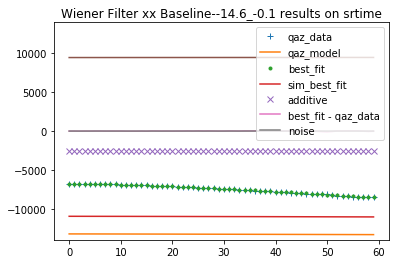

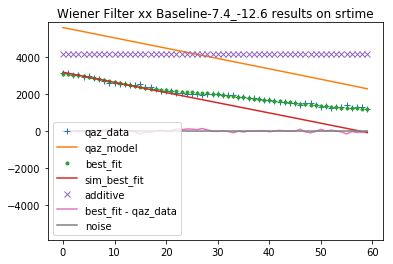

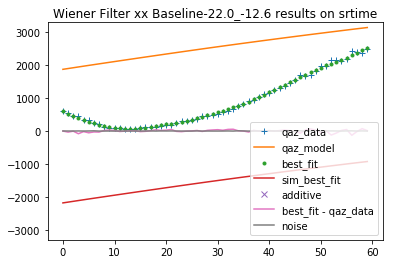

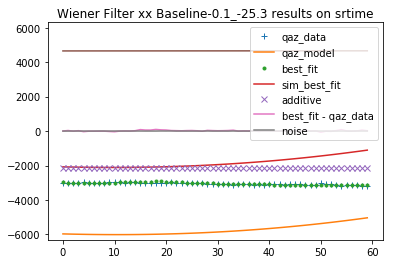

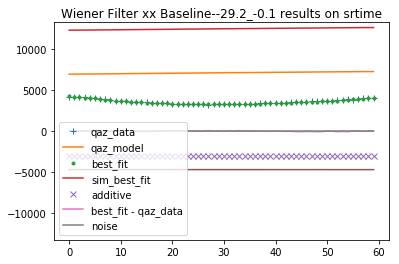

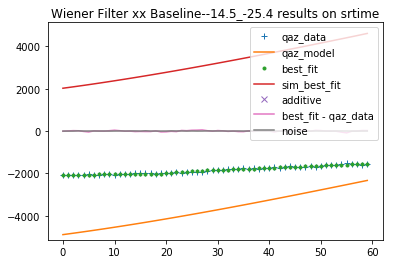

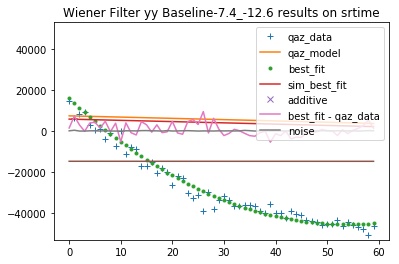

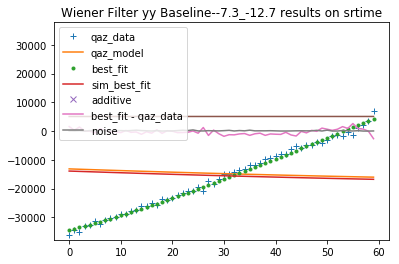

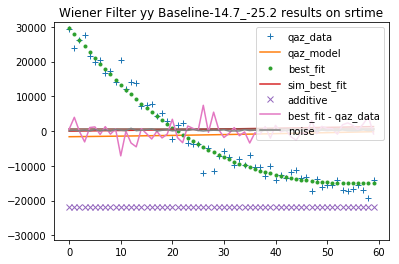

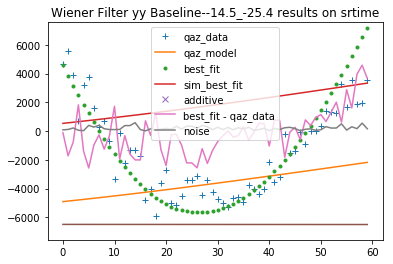

In [261]:
#####apply wiener filter##############
print "Applying Regularized AtNiAi...",
sys.stdout.flush()
w_solution = AtNiAi.dotv(AtNi_data)
w_GSM = AtNiAi.dotv(AtNi_clean_sim_data)
w_sim_sol = AtNiAi.dotv(AtNi_sim_data)
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

del (AtNiAi)

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)
	
best_fit = A.dot(w_solution.astype(A.dtype)) # Reversely-Calculated-masked-GSM Dynamically simulated Visibilities.
best_fit_no_additive = A[..., :valid_npix].dot(w_solution[:valid_npix].astype(A.dtype))

sim_best_fit = A.dot(w_sim_sol.astype(A.dtype))
sim_best_fit_no_additive = A[..., :valid_npix].dot(w_sim_sol[:valid_npix].astype(A.dtype))

if plot_data_error:
	qaz_model = (clean_sim_data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Dynamic Simulated, Clean, being Normalized    # * vis_normalization
	qaz_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Full Simulated, Calibrated, reference for normalization
	if pre_calibrate:
		qaz_add = np.copy(additive_term).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x'] #[::max(1, len(ubl_sort['x'])/70)]
	best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	best_fit_no_additive.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	sim_best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	ri = 1
	#plt.clf()

	figure_W = {}
	for p in range(2):
		
		for nu, u in enumerate(us):
			plt.figure(8000 + 10*p + nu)
			#plt.subplot(6, (len(us) + 5) / 6, nu + 1)
			# plt.errorbar(range(nt_used), qaz_data[ri, u, p], yerr=Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			figure_W[1], = plt.plot(qaz_data[ri, u, p],'+')
			figure_W[2], = plt.plot(qaz_model[ri, u, p],'-')
			figure_W[3], = plt.plot(best_fit[ri, u, p],'.')
			figure_W[4], = plt.plot(sim_best_fit[ri, u, p])
			if pre_calibrate:
				figure_W[5], = plt.plot(qaz_add[ri, u, p],'x')
			if fit_for_additive:
				figure_W[6], = plt.plot(autocorr_vis_normalized[p] * sol2additive(w_solution)[p, u, ri])
			figure_W[7], = plt.plot(best_fit[ri, u, p] - qaz_data[ri, u, p])
			figure_W[8], = plt.plot(Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			if pre_calibrate:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) # np.max(np.abs(qaz_add[ri, u, p])), #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[5], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'additive', 'best_fit - qaz_data', 'noise'], loc=0)
			else:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'best_fit - qaz_data', 'noise'], loc=0)
			plt.ylim([-1.05*data_range, 1.05*data_range])
			#plt.title("%.1f,%.1f,%.1e"%(used_common_ubls[u, 0], used_common_ubls[u, 1], la.norm(best_fit[ri, u, p] - qaz_data[ri, u, p])))
			plt.title("Wiener Filter %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-WienerFilter_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.gcf().clear()
			#plt.close()

# Del=True
# if Del:
# 	try:
# 		#del(additive_A)
# 		#del(real_additive_A)
# 	except:
# 		pass

sys.stdout.flush()

In [262]:
def plot_IQU(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), min=0, max=4, coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)

def plot_IQU_unlimit(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)


In [263]:
rescale_factor = np.max(np.abs(fake_solution))/ np.max(np.abs(w_solution))

In [264]:
%matplotlib inline

In [265]:
print('Number of Positive w_solution Pixels: %s'%len(w_solution[w_solution>=0]))
print('Number of Positive w_GSM Pixels: %s'%len(w_GSM[w_GSM>=0]))
print('Number of Positive w_sim Pixels: %s'%len(w_sim_sol[w_sim_sol>=0]))
print('Number of Positive GSM Pixels: %s'%len(fake_solution[fake_solution>=0]))

Number of Positive w_solution Pixels: 5184
Number of Positive w_GSM Pixels: 6106
Number of Positive w_sim Pixels: 5973
Number of Positive GSM Pixels: 10456


divide by zero encountered in log10


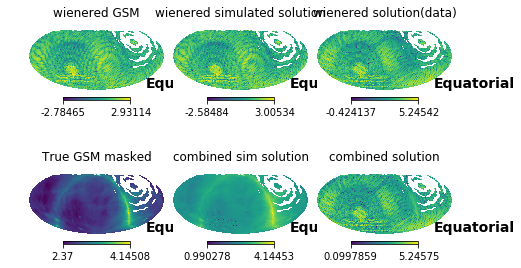

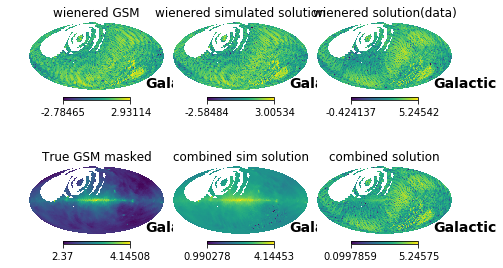

In [266]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(900 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	#plt.show(block=False)
	#plt.gcf().clear()
	


divide by zero encountered in log10


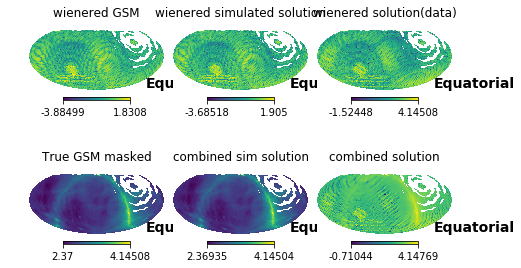

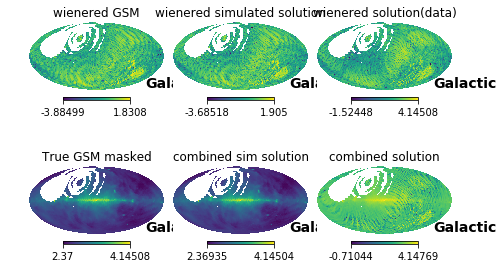

In [267]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000000 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()
	

divide by zero encountered in log10


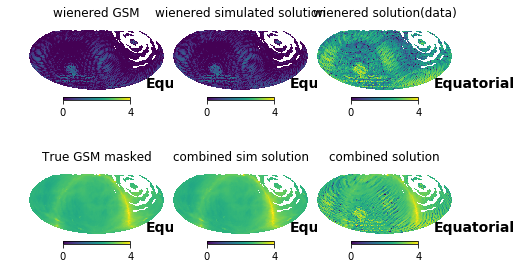

In [268]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9500000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


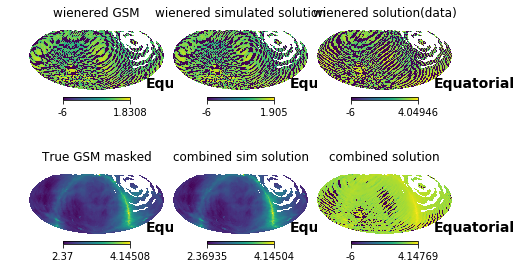

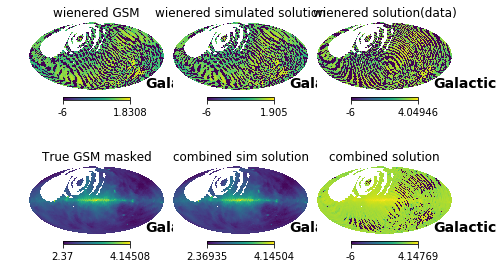

In [269]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(950 + crd)
	crd += 10
	plot_IQU_unlimit((w_GSM + np.abs(w_GSM))*0.5 * rescale_factor + 1.e-6, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit((w_sim_sol + np.abs(w_sim_sol))*0.5 * rescale_factor + 1.e-6, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit((w_solution + np.abs(w_solution))*0.5 * rescale_factor + 1.e-6, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit((fake_solution + np.abs(fake_solution))*0.5 + 1.e-6, 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit((((w_sim_sol - w_GSM) * rescale_factor + fake_solution) + np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution))*0.5 + 1.e-6, 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit((((w_solution - w_GSM) * rescale_factor + fake_solution) + np.abs((w_solution - w_GSM) * rescale_factor + fake_solution))*0.5 + 1.e-6, 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-denegative-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

In [270]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(90000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()
	

divide by zero encountered in log10


In [271]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM/vis_normalization), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol/vis_normalization), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution/vis_normalization), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM + fake_solution)/vis_normalization), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM + fake_solution)/vis_normalization), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener_renormalized-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

divide by zero encountered in log10


In [272]:
error = data.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])) - best_fit
chi = error * (Ni.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])))**.5
print "chi^2 = %.3e, data points %i, pixels %i"%(la.norm(chi)**2, len(data), valid_npix)
print "re/im chi2 %.3e, %.3e"%(la.norm(chi[0])**2, la.norm(chi[1])**2)
print "xx/yy chi2 %.3e, %.3e"%(la.norm(chi[:, :, 0])**2, la.norm(chi[:, :, 1])**2)
#plt.clf()
plt.figure(120)
plt.subplot(2, 2, 1)
plt.plot([la.norm(error[:, u]) for u in ubl_sort['x']])
plt.title('Error Norm-bsl')
plt.subplot(2, 2, 2)
plt.plot([la.norm(chi[:, u]) for u in ubl_sort['x']])
plt.title('Chi Norm-bsl')
plt.subplot(2, 2, 3)
plt.plot(lsts, [la.norm(error[..., t]) for t in range(error.shape[-1])])
plt.title('Error Norm-t')
plt.subplot(2, 2, 4)
plt.plot(lsts, [la.norm(chi[..., t]) for t in range(error.shape[-1])])
plt.title('Chi Norm-bsl')
plt.savefig(script_dir + '/../Output/chi-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
plt.show(block=False)
#plt.gcf().clear()

try:
	print('Additive_sol: %s' %additive_sol[:2])
	print ("regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes))
	print('Rescale_factor: %s'%rescale_factor)
except:
	pass	


sys.stdout.flush()

chi^2 = 8.603e+06, data points 2160, pixels 10420
re/im chi2 5.989e+06, 2.615e+06
xx/yy chi2 2.009e+06, 6.594e+06


Additive_sol: [0.07574228+0.j 0.00140984+0.j]
('regularization stength', (869.178025871218+0j), 'median GSM ranges between', 284.4070430340813, 284.4070430340813)
Rescale_factor: 0.07937075526988291


In [273]:
#S_type = 'none'
#point spread function:
if True and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	plt.figure(130)
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			iplot += 1
			choose_plots = [1, 12, 24]
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis) 
				hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
	plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()

In [274]:
print AtNiA_filename
print A_filename
print AtNiA_tag

AtNiA_N_2018__autocorr_ampcalA_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0
A_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0
AtNiA_N_2018__autocorr_ampcal


Reading Regularized AtNiAi... Reading AtNiA...

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


 1.5707963267948966 1.1086374892685592e-17


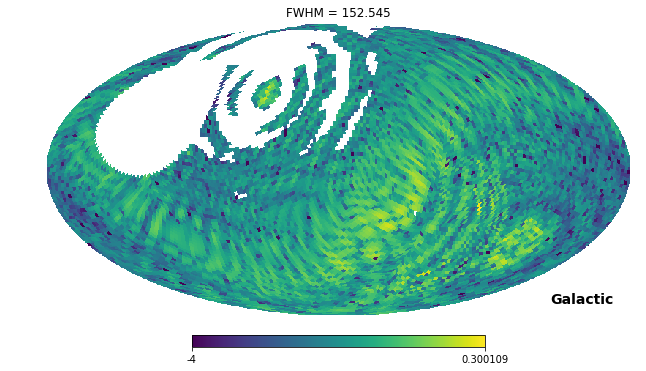

1.5707963267948966 -8.646464945411218e-18


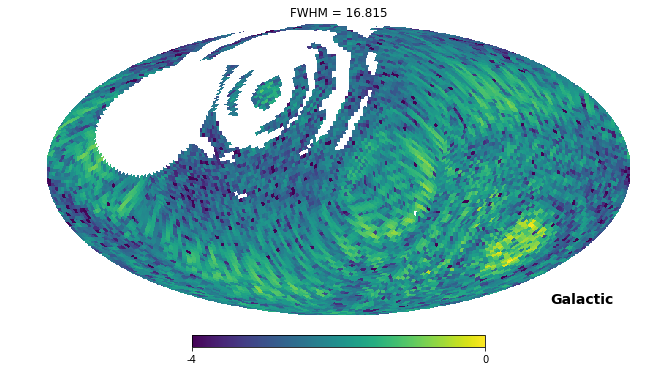

1.5707963267948966 -1.6639318226483292e-17


1.5707963267948966 1.1086374892685592e-17


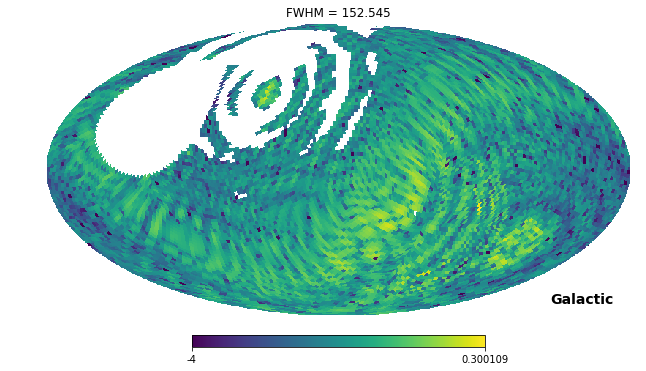

1.5707963267948966 3.1760954804746706e-18


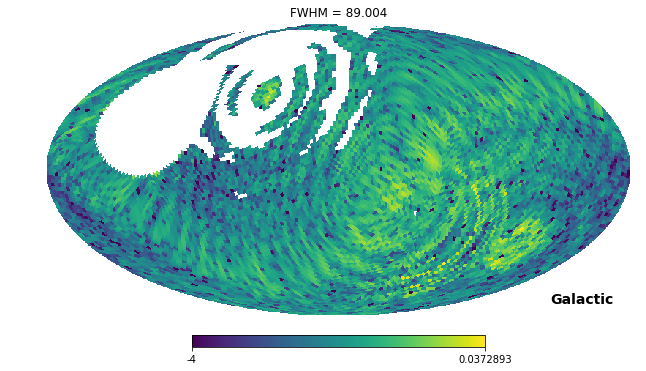

1.5707963267948963 -1.13058570356823e-17


1.5707963267948966 3.456445779394833e-17


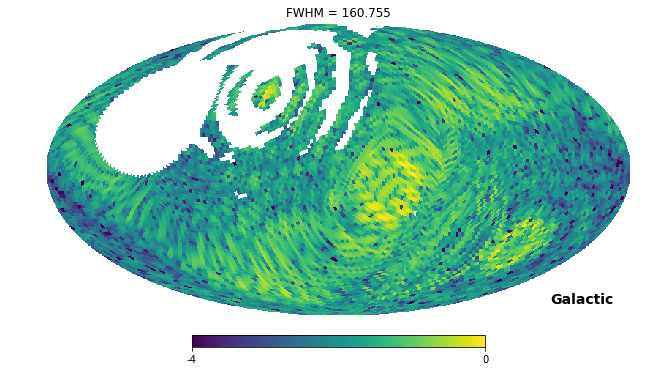

1.5707963267948966 -1.2902205254689176e-17


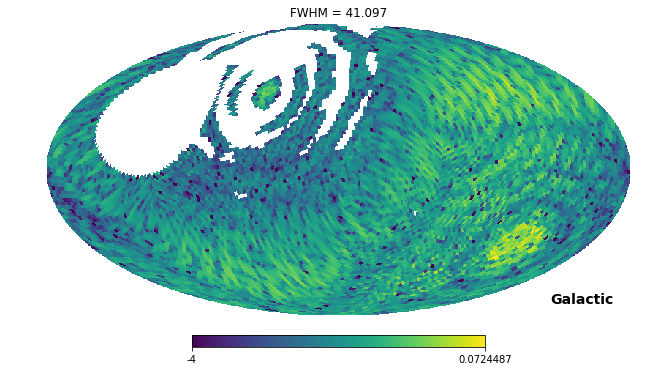

1.5707963267948963 -1.13058570356823e-17


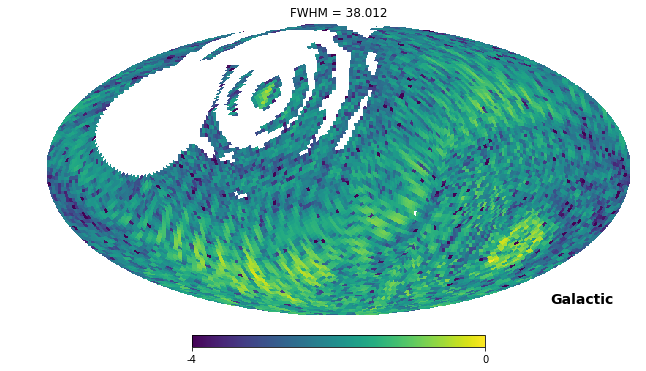

1.5707963267948966 1.970090588353492e-18


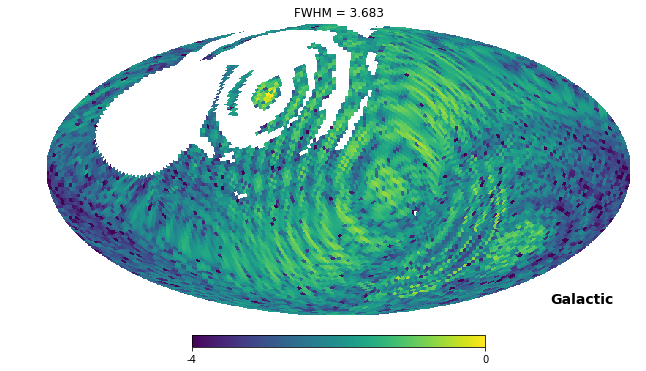

1.5707963267948966 8.427323318801169e-18


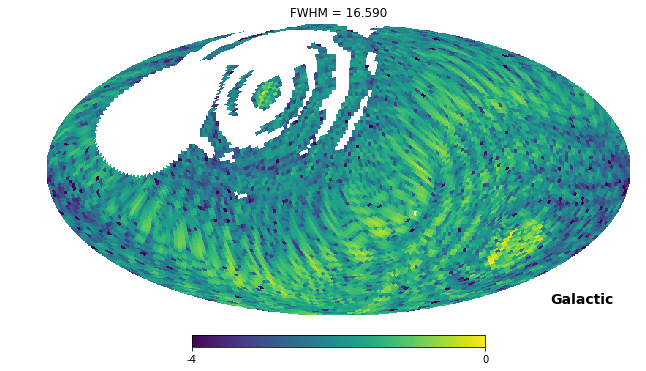

1.5707963267948963 3.2038213973335915e-17


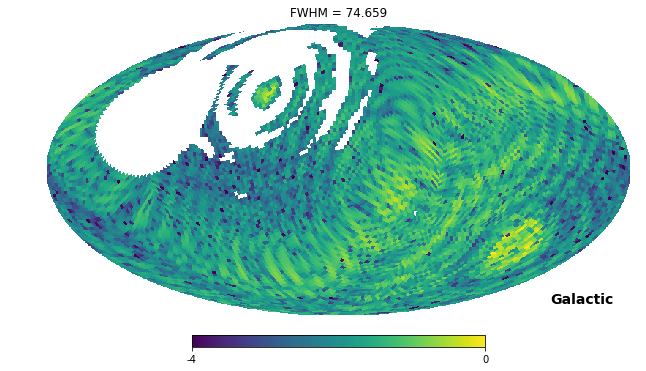

1.5707963267948966 2.1633359675602035e-17


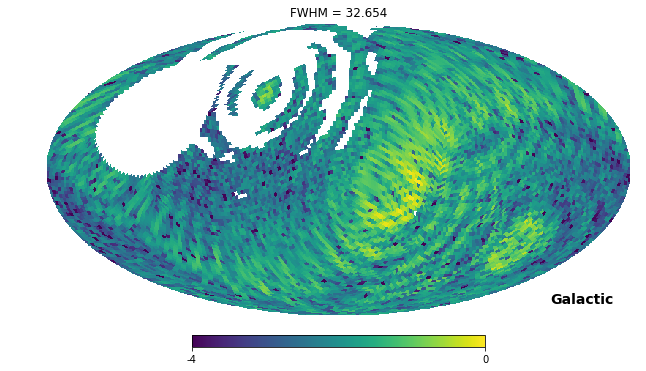

1.5707963267948966 1.6244824978284946e-17


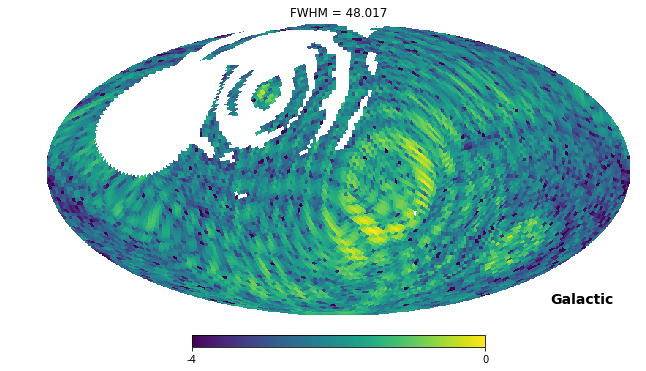

In [275]:
#S_type = 'none'
#point spread function:
if True:# and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			
			#choose_plots = [1, 6, 12, 18, 24, 30]
			choose_plots = [0, 1, 4, 6, 8, 12, 16, 20, 24, 28, 30, 32, 33, 35]
			
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis)
				plt.figure(1300+iplot) 
				#hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
				hpv.mollview(np.log10(np.abs(spreaded)), min=-4, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI))
				plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, iplot, freq, bnside, nside_standard))
				plt.show(block=False)
				#plt.gcf().clear()
			iplot += 1


sys.stdout.flush()


In [276]:
#point_vec